# Private Equity Data Analysis and Strategy Backtesting

This notebook analyzes private equity (PE) data and implements various quantitative investment strategies using historical stock and PE ratio data. The workflow includes:

- **Data Acquisition:** Downloading and cleaning stock price and PE ratio data, as well as risk-free rates and benchmark indices (XLI, S&P 500).
- **Return Calculations:** Computing log returns, excess returns, and annualized returns for the selected tickers.
- **Strategy Construction:** Implementing multiple strategies based on PE ratios (relative to benchmark and average), momentum, and combinations thereof, with both equal and unequal weighting schemes.
- **Performance Evaluation:** Calculating key performance metrics (annualized return, volatility, Sharpe ratio, skewness, kurtosis, drawdowns, and alphas/betas vs. benchmarks).
- **Visualization:** Plotting cumulative returns, return differentials, and drawdown profiles for each strategy.
- **Comparative Analysis:** Comparing the effectiveness of different strategies and weighting methods.

The notebook is structured to facilitate experimentation with factor-based and momentum-based strategies, providing a comprehensive framework for quantitative PE analysis and backtesting.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy.linalg import inv
from cvxopt import matrix, solvers
import cvxpy as cp
import warnings
import yfinance as yf
import os
from scipy.optimize import minimize, LinearConstraint
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Get Data

In [2]:
df = pd.read_csv(r"C:\Users\bjorn\FE 571 Final Project\FE 571 Final Project PE Data.csv", index_col = 0)
df = df.drop(columns =['UBER'])

In [3]:
tickers = []
for col in df.columns:
    tickers.append(col)

In [4]:
stock_prices = pd.DataFrame(columns = tickers)
df_tick =  yf.download(tickers,start = '1999-1-1', end = '2024-2-1', interval = '1mo')['Adj Close']
for ticker in tickers:
    stock_prices[ticker] = df_tick[ticker]
stock_prices = stock_prices[3:]

[*********************100%%**********************]  78 of 78 completed


In [5]:
df_rf =  yf.download('^IRX', start = '1999-1-1', end = '2024-2-1', interval = '1mo')['Adj Close']
df_rf = df_rf[3:]
df_rf =df_rf[::3]

[*********************100%%**********************]  1 of 1 completed


In [6]:
df_rf*.01/4

Date
1999-04-01    0.011075
1999-07-01    0.011550
1999-10-01    0.012400
2000-01-01    0.013825
2000-04-01    0.014125
                ...   
2023-01-01    0.011425
2023-04-01    0.012307
2023-07-01    0.013120
2023-10-01    0.013300
2024-01-01    0.012970
Name: Adj Close, Length: 100, dtype: float64

In [7]:
quarterly_stock_prices = stock_prices.iloc[::3,:]

In [8]:
stock_prices1 = stock_prices.set_index(np.arange(0,len(stock_prices)))

In [9]:
df.index = quarterly_stock_prices.index[::-1]
df = df.iloc[::-1]
bench = df["XLI"]
bench_ret = np.log(quarterly_stock_prices['XLI'])-np.log(quarterly_stock_prices['XLI'].shift(1))
bench_ret = bench_ret -(df_rf*.01/4)
df = df.drop(columns = ['XLI'])
df

CAT      GE     UNP    RTX    HON     BA    ETN    UPS     DE  \
Date                                                                          
1999-04-01  13.01   38.28      --  26.53  20.58  21.25  15.65    NaN   7.83   
1999-07-01  19.35    18.9      --  24.49   24.8  21.15  19.54    NaN  15.58   
1999-10-01  19.58   38.25  141.36  20.78  22.82  19.03  13.52    NaN  13.81   
2000-01-01   17.9   48.06      14  39.39  30.36  16.64   8.65  89.61  19.49   
2000-04-01  14.14   46.59   11.71  28.11  26.61  15.31   8.67  64.25  45.04   
...           ...     ...     ...    ...    ...    ...    ...    ...    ...   
2023-01-01  17.44      --   18.49  33.64  27.44     --  27.49  13.62  19.78   
2023-04-01   18.1  180.38   17.95   27.9  26.29     --  27.91  14.70  18.16   
2023-07-01   18.2   15.15   18.09  26.19  26.95     --  31.42  14.50  14.05   
2023-10-01     17   11.96    18.6  19.09  22.86     --  31.50  13.52  14.45   
2024-01-01  16.76   13.28   23.57  38.77  25.99     --  32.24  15.91  10.83   

              ADP  ...    ROL   ALLE    ITT    HII    AOS    AAL   PAYC  \
Date               ...                                                    
1999-04-01  38.67  ...  76.39    NaN     --    NaN   9.59   4.19    NaN   
1999-07-01  40.00  ...  61.26    NaN     --    NaN  12.06   5.39    NaN   
1999-10-01  39.49  ...  57.14    NaN  96.41    NaN  14.83   4.86    NaN   
2000-01-01  44.90  ...  41.67    NaN  13.22    NaN  10.37   7.42    NaN   
2000-04-01  38.29  ...  40.59    NaN  11.72    NaN   8.20   6.88    NaN   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2023-01-01  33.08  ...  52.20  21.44  19.26  16.08  18.23     --  72.17   
2023-04-01  29.61  ...  50.04  20.56  19.61  14.34  45.79  77.63  62.81   
2023-07-01  28.11  ...  54.91  21.66  19.75  16.06  45.77   6.57  60.38   
2023-10-01  29.30  ...  47.25  17.81  19.12  15.74  36.34    3.3  47.66   
2024-01-01  27.67  ...  52.61  20.05  22.77   19.6  41.01   5.75   35.4   

             CHRW    RHI   GNRC  
Date                             
1999-04-01  23.13  22.63    NaN  
1999-07-01  31.68  17.32    NaN  
1999-10-01  28.07  15.94    NaN  
2000-01-01  30.82  18.67    NaN  
2000-04-01  26.80  29.26    NaN  
...           ...    ...    ...  
2023-01-01  11.10  11.99  15.16  
2023-04-01  13.43  13.36  19.93  
2023-07-01  14.95  13.31  38.24  
2023-10-01  19.31  14.51  45.59  
2024-01-01  25.71  19.89  51.08  

[100 rows x 77 columns]

In [10]:
sp = yf.download('^GSPC', start = '1999-1-1', end = '2024-2-1', interval = '1mo')['Adj Close']
sp = sp[3:]
sp = sp[::3]

[*********************100%%**********************]  1 of 1 completed


In [11]:
sp_ret = np.log(sp)-np.log(sp.shift(1))
sp_ret = sp_ret-(df_rf*.01/4)

# Momentum Strategy

In [12]:
quarterly_stock_prices1 = quarterly_stock_prices.drop(columns = ['XLI'])
log_returns_3 = pd.DataFrame()
for i in tickers[1:]:    
    log_returns_3[i] = np.log(quarterly_stock_prices1[i])-np.log(quarterly_stock_prices1[i].shift(1))

In [13]:
for tick in tickers[1:]:
    log_returns_3[tick] = log_returns_3[tick]-(df_rf*.01/4)
log_returns_3

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.100239  0.022272 -0.105670 -0.091815  0.087544  0.102256   
1999-10-01 -0.065085  0.212784  0.017813 -0.107181 -0.137346  0.005682   
2000-01-01 -0.272755 -0.021696 -0.335305 -0.143810 -0.181824 -0.045162   
2000-04-01 -0.081163  0.149564  0.037127  0.150739  0.144093 -0.125158   
...              ...       ...       ...       ...       ...       ...   
2023-01-01  0.148417  0.271165  0.029854  0.046110  0.015085  0.390455   
2023-04-01 -0.149971  0.195662 -0.048053 -0.006320 -0.049351 -0.041944   
2023-07-01  0.184507  0.130365  0.163876 -0.134620 -0.036876  0.131060   
2023-10-01 -0.167975 -0.061826 -0.118627 -0.083635 -0.065464 -0.258990   
2024-01-01  0.276243  0.185848  0.153846  0.107299  0.091545  0.108932   

                 ETN       UPS        DE       ADP  ...       ROL      ALLE  \
Date                                                ...                       
1999-04-01       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1999-07-01  0.069332       NaN -0.120516 -0.114771  ...  0.002500       NaN   
1999-10-01 -0.281632       NaN -0.057174  0.174089  ... -0.093313       NaN   
2000-01-01 -0.059788       NaN  0.178065 -0.027789  ... -0.022756       NaN   
2000-04-01  0.154146  0.091832 -0.086992  0.113993  ... -0.086283       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2023-01-01  0.071498  0.096890  0.057403 -0.074595  ... -0.153329  0.103671   
2023-04-01  0.022435 -0.033236 -0.121231 -0.032727  ...  0.140393 -0.070082   
2023-07-01  0.197856  0.036345  0.117877  0.109484  ... -0.044183  0.046850   
2023-10-01  0.003205 -0.285551 -0.171753 -0.133245  ... -0.092228 -0.181401   
2024-01-01  0.159568  0.003264  0.065098  0.112007  ...  0.132089  0.221592   

                 ITT       HII       AOS       AAL      PAYC      CHRW  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01  0.029786       NaN  0.136286       NaN       NaN  0.157463   
1999-10-01 -0.097285       NaN -0.191606       NaN       NaN -0.055475   
2000-01-01 -0.087488       NaN -0.214101       NaN       NaN  0.173545   
2000-04-01 -0.010480       NaN  0.031939       NaN       NaN  0.193590   
...              ...       ...       ...       ...       ...       ...   
2023-01-01  0.173265 -0.159298  0.206133  0.118043 -0.077305  0.019443   
2023-04-01 -0.090426 -0.096170  0.001352 -0.180601 -0.121710  0.000813   
2023-07-01  0.155353  0.123096  0.052949  0.192272  0.227215 -0.013511   
2023-10-01 -0.075257 -0.051488 -0.049537 -0.420259 -0.420992 -0.209158   
2024-01-01  0.247349  0.156188  0.098396  0.230943 -0.263704  0.021780   

                 RHI      GNRC  
Date                            
1999-04-01       NaN       NaN  
1999-07-01  0.090401       NaN  
1999-10-01  0.010966       NaN  
2000-01-01  0.341925       NaN  
2000-04-01  0.444897       NaN  
...              ...       ...  
2023-01-01  0.087741  0.028240  
2023-04-01 -0.146206 -0.177659  
2023-07-01  0.009540  0.394755  
2023-10-01  0.001424 -0.616653  
2024-01-01  0.054772  0.288680  

[100 rows x 77 columns]

In [14]:
# maybe should do excess returns?

log_returns_3["Mean"] = np.nan
for i in range(len(log_returns_3)):
    log_returns_3['Mean'].iloc[i] = log_returns_3.iloc[i].mean()
log_returns_3.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.100239  0.022272 -0.105670 -0.091815  0.087544  0.102256   
1999-10-01 -0.065085  0.212784  0.017813 -0.107181 -0.137346  0.005682   
2000-01-01 -0.272755 -0.021696 -0.335305 -0.143810 -0.181824 -0.045162   
2000-04-01 -0.081163  0.149564  0.037127  0.150739  0.144093 -0.125158   

                 ETN       UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                                ...                        
1999-04-01       NaN       NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01  0.069332       NaN -0.120516 -0.114771  ...   NaN  0.029786  NaN   
1999-10-01 -0.281632       NaN -0.057174  0.174089  ...   NaN -0.097285  NaN   
2000-01-01 -0.059788       NaN  0.178065 -0.027789  ...   NaN -0.087488  NaN   
2000-04-01  0.154146  0.091832 -0.086992  0.113993  ...   NaN -0.010480  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC      Mean  
Date                                                                 
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN       NaN  
1999-07-01  0.136286  NaN   NaN  0.157463  0.090401   NaN -0.029861  
1999-10-01 -0.191606  NaN   NaN -0.055475  0.010966   NaN -0.131833  
2000-01-01 -0.214101  NaN   NaN  0.173545  0.341925   NaN -0.068756  
2000-04-01  0.031939  NaN   NaN  0.193590  0.444897   NaN  0.068548  

[5 rows x 78 columns]

In [15]:
annual_log_returns = pd.DataFrame()
for i in tickers[1:]:    
    annual_log_returns[i] = np.log(quarterly_stock_prices1[i])-np.log(quarterly_stock_prices1[i].shift(4))

annual_log_returns["Mean"] = np.nan
for i in range(len(annual_log_returns)):
    annual_log_returns['Mean'].iloc[i] = annual_log_returns.iloc[i].mean()
annual_log_returns.head(7)

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-10-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2000-04-01 -0.467342  0.414825 -0.334136 -0.140167 -0.035633 -0.010481   
2000-07-01 -0.517065  0.366994 -0.210326 -0.120143 -0.630363  0.086323   
2000-10-01 -0.425881  0.206733 -0.153413  0.156705 -0.040943  0.399889   

                 ETN  UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                           ...                        
1999-04-01       NaN  NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01       NaN  NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-10-01       NaN  NaN       NaN       NaN  ...   NaN       NaN  NaN   
2000-01-01       NaN  NaN       NaN       NaN  ...   NaN       NaN  NaN   
2000-04-01 -0.066041  NaN -0.034717  0.197422  ...   NaN -0.113567  NaN   
2000-07-01 -0.355563  NaN  0.033957  0.219898  ...   NaN -0.109461  NaN   
2000-10-01 -0.076346  NaN  0.039214  0.310763  ...   NaN -0.029563  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC      Mean  
Date                                                                 
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN       NaN  
1999-07-01       NaN  NaN   NaN       NaN       NaN   NaN       NaN  
1999-10-01       NaN  NaN   NaN       NaN       NaN   NaN       NaN  
2000-01-01       NaN  NaN   NaN       NaN       NaN   NaN       NaN  
2000-04-01 -0.185582  NaN   NaN  0.521024  0.940089   NaN -0.110418  
2000-07-01 -0.570222  NaN   NaN  0.596987  0.955693   NaN -0.096886  
2000-10-01 -0.515501  NaN   NaN  0.487859  0.812724   NaN  0.065921  

[7 rows x 78 columns]

# PE Ratios

In [16]:
#treat as negative earnings
df1 = df.replace('--',np.nan)

for i in tickers[1:]:
    df1[i] = df1[i].astype(float)

df1['MEAN PE'] = 0.0 
for i in range(len(df1)):
    df1['MEAN PE'].iloc[i] = df1.iloc[i].mean()
df1 = df1.replace(np.nan,-1)

df1.tail()

CAT      GE    UNP    RTX    HON   BA    ETN    UPS     DE  \
Date                                                                       
2023-01-01  17.44   -1.00  18.49  33.64  27.44 -1.0  27.49  13.62  19.78   
2023-04-01  18.10  180.38  17.95  27.90  26.29 -1.0  27.91  14.70  18.16   
2023-07-01  18.20   15.15  18.09  26.19  26.95 -1.0  31.42  14.50  14.05   
2023-10-01  17.00   11.96  18.60  19.09  22.86 -1.0  31.50  13.52  14.45   
2024-01-01  16.76   13.28  23.57  38.77  25.99 -1.0  32.24  15.91  10.83   

              ADP  ...   ALLE    ITT    HII    AOS    AAL   PAYC   CHRW  \
Date               ...                                                    
2023-01-01  33.08  ...  21.44  19.26  16.08  18.23  -1.00  72.17  11.10   
2023-04-01  29.61  ...  20.56  19.61  14.34  45.79  77.63  62.81  13.43   
2023-07-01  28.11  ...  21.66  19.75  16.06  45.77   6.57  60.38  14.95   
2023-10-01  29.30  ...  17.81  19.12  15.74  36.34   3.30  47.66  19.31   
2024-01-01  27.67  ...  20.05  22.77  19.60  41.01   5.75  35.40  25.71   

              RHI   GNRC    MEAN PE  
Date                                 
2023-01-01  11.99  15.16  28.881644  
2023-04-01  13.36  19.93  29.543816  
2023-07-01  13.31  38.24  27.173733  
2023-10-01  14.51  45.59  26.422000  
2024-01-01  19.89  51.08  29.095867  

[5 rows x 78 columns]

In [17]:
df2 = df.replace('--',np.nan)
df2 = df2.ffill()
for i in tickers[1:]:
    df2[i] = df2[i].astype(float)

df2['MEAN PE'] = 0.0 
for i in range(len(df2)):
    df2['MEAN PE'].iloc[i] = df2.iloc[i].mean()
df2 = df2.replace(np.nan,-1)
df2

CAT      GE     UNP    RTX    HON     BA    ETN    UPS     DE  \
Date                                                                          
1999-04-01  13.01   38.28   -1.00  26.53  20.58  21.25  15.65  -1.00   7.83   
1999-07-01  19.35   18.90   -1.00  24.49  24.80  21.15  19.54  -1.00  15.58   
1999-10-01  19.58   38.25  141.36  20.78  22.82  19.03  13.52  -1.00  13.81   
2000-01-01  17.90   48.06   14.00  39.39  30.36  16.64   8.65  89.61  19.49   
2000-04-01  14.14   46.59   11.71  28.11  26.61  15.31   8.67  64.25  45.04   
...           ...     ...     ...    ...    ...    ...    ...    ...    ...   
2023-01-01  17.44   71.57   18.49  33.64  27.44  49.66  27.49  13.62  19.78   
2023-04-01  18.10  180.38   17.95  27.90  26.29  49.66  27.91  14.70  18.16   
2023-07-01  18.20   15.15   18.09  26.19  26.95  49.66  31.42  14.50  14.05   
2023-10-01  17.00   11.96   18.60  19.09  22.86  49.66  31.50  13.52  14.45   
2024-01-01  16.76   13.28   23.57  38.77  25.99  49.66  32.24  15.91  10.83   

              ADP  ...   ALLE    ITT    HII    AOS    AAL   PAYC   CHRW  \
Date               ...                                                    
1999-04-01  38.67  ...  -1.00  -1.00  -1.00   9.59   4.19  -1.00  23.13   
1999-07-01  40.00  ...  -1.00  -1.00  -1.00  12.06   5.39  -1.00  31.68   
1999-10-01  39.49  ...  -1.00  96.41  -1.00  14.83   4.86  -1.00  28.07   
2000-01-01  44.90  ...  -1.00  13.22  -1.00  10.37   7.42  -1.00  30.82   
2000-04-01  38.29  ...  -1.00  11.72  -1.00   8.20   6.88  -1.00  26.80   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2023-01-01  33.08  ...  21.44  19.26  16.08  18.23   3.22  72.17  11.10   
2023-04-01  29.61  ...  20.56  19.61  14.34  45.79  77.63  62.81  13.43   
2023-07-01  28.11  ...  21.66  19.75  16.06  45.77   6.57  60.38  14.95   
2023-10-01  29.30  ...  17.81  19.12  15.74  36.34   3.30  47.66  19.31   
2024-01-01  27.67  ...  20.05  22.77  19.60  41.01   5.75  35.40  25.71   

              RHI   GNRC    MEAN PE  
Date                                 
1999-04-01  22.63  -1.00  22.764615  
1999-07-01  17.32  -1.00  76.592545  
1999-10-01  15.94  -1.00  25.392414  
2000-01-01  18.67  -1.00  24.685593  
2000-04-01  29.26  -1.00  41.780339  
...           ...    ...        ...  
2023-01-01  11.99  15.16  29.121299  
2023-04-01  13.36  19.93  29.805065  
2023-07-01  13.31  38.24  28.100130  
2023-10-01  14.51  45.59  27.149615  
2024-01-01  19.89  51.08  29.720641  

[100 rows x 78 columns]

## Compared to Benchmark XLI PE Ratio

In [18]:
bench

Date
1999-04-01    19.67
1999-07-01    21.41
1999-10-01    20.89
2000-01-01    21.06
2000-04-01    19.99
              ...  
2023-01-01    18.88
2023-04-01    20.97
2023-07-01    20.09
2023-10-01    19.21
2024-01-01    21.29
Freq: 3MS, Name: XLI, Length: 100, dtype: float64

In [19]:
bench_ret

Date
1999-04-01         NaN
1999-07-01   -0.009187
1999-10-01   -0.031422
2000-01-01   -0.043773
2000-04-01    0.073797
                ...   
2023-01-01    0.069826
2023-04-01   -0.026544
2023-07-01    0.089992
2023-10-01   -0.124892
2024-01-01    0.130266
Freq: 3MS, Length: 100, dtype: float64

In [20]:
df1PELS = pd.DataFrame(index = df.index, columns = tickers[1:])

for i in tickers[1:]:
    df1PELS[i] =  np.where(df1[i] == bench, 0, 1)*np.where(df1[i] < bench, 1, -1)*np.where(df1[i] == -1, 0, 1)

In [21]:
df1PELS.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    1  -1    0   -1   -1  -1    1    0   1   -1  ...   -1     0   
1999-07-01    1   1    0   -1   -1   1    1    0   1   -1  ...   -1     0   
1999-10-01    1  -1   -1    1   -1   1    1    0   1   -1  ...   -1     0   
2000-01-01    1  -1    1   -1   -1   1    1   -1   1   -1  ...   -1     0   
2000-04-01    1  -1    1   -1   -1   1    1   -1  -1   -1  ...   -1     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    1    1     0    -1   -1     0  
1999-07-01    0    0    1    1     0    -1    1     0  
1999-10-01   -1    0    1    1     0    -1    1     0  
2000-01-01    1    0    1    1     0    -1    1     0  
2000-04-01    1    0    1    1     0    -1   -1     0  

[5 rows x 77 columns]

In [22]:
# df1 is a dataframe of the position sizes, df2 is an (excess) return dataframe
# We get a return dataframe with a portfolio of returns
def calc_return(df1, df2):
    stocks = []
    for col in df1.columns:
        stocks.append(col)
    return_df = pd.DataFrame(index = df1.index, columns = stocks)
    for i in stocks:
        return_vec = [np.nan]
        for j in range(len(df1)-1):
            val = df1[i].iloc[j]*df2[i].iloc[j+1]
            return_vec.append(val)
        return_df[i] = return_vec
    
    
    transact_df = pd.DataFrame(np.where(df1 != df1.shift(1), .001, 0), index = df1.index, columns = stocks)
    
    ret_df = pd.DataFrame(return_df.values-transact_df.values, columns=return_df.columns, index=return_df.index)
    
    ret_df['Portfolio'] = np.nan
    for i in range(len(ret_df)):
        ret_df['Portfolio'].iloc[i] = ret_df.iloc[i].mean()
            
    return ret_df

#metrics for how we did on each stock in the strategy
#We take a return data frame and calculate metrics from this
def calc_metrics(returns_df):
    stocks = []
    for col in returns_df.columns:
        stocks.append(col)
        
    metrics = ["Annualized Return", 'Annualized Vol', 'Sharpe Ratio', 'Skewness','Excess Kurtosis',
               'High Water Mark', 'Max Drawdown', 'XLI Beta', 'Annualized XLI Alpha',
               'S&P Beta', 'Annualized S&P Alpha']
    metrics_df = pd.DataFrame(index = metrics, columns = stocks)
    
    
    for i in stocks:
        annual_return = returns_df[i].mean()*4
        annual_vol = returns_df[i].std()*np.sqrt(4)
        if annual_vol == 0:
            sharpe_ratio = 0
        else:
            sharpe_ratio = annual_return/annual_vol
            
        skews = skew(returns_df[i][1:])
        kurts = kurtosis(returns_df[i][1:])
        
        returns_df = returns_df.replace(np.nan,0)
        upper = 0
        lower = 0
        mdd_track = []
        HWMs = []
        for j in range(len(returns_df)):
            
            upper = max(returns_df[i].iloc[0:j+1].cumsum().iloc[-1], upper)
            diff = upper-returns_df[i].iloc[0:j+1].cumsum().iloc[-1]
            HWMs.append(upper)
            mdd_track.append(diff)    
        max_drawdown = max(mdd_track)
        HWM = max(HWMs)
        
        reg_xli = LinearRegression().fit(bench_ret.to_numpy()[1:].reshape(-1,1), returns_df[i].to_numpy()[1:].reshape(-1,1))
        beta_xli = reg_xli.coef_[0][0]
        alpha_xli = reg_xli.intercept_[0]*4
        
        reg_sp = LinearRegression().fit(sp_ret.to_numpy()[1:].reshape(-1,1), returns_df[i].to_numpy()[1:].reshape(-1,1))
        beta_sp = reg_sp.coef_[0][0]
        alpha_sp = reg_sp.intercept_[0]*4
        
        metrics_i = [annual_return, annual_vol, sharpe_ratio, skews, kurts, HWM, max_drawdown, beta_xli, alpha_xli, beta_sp, alpha_sp]
        metrics_df[i] = metrics_i
    
    
    return metrics_df, HWMs, mdd_track
        

In [23]:
#graph cumulative returns vs benchmark
def graph(port_ret_df, bench_ret, HWMs, mdd_track):
    x = port_ret_df.index
    y1 = port_ret_df['Portfolio']
    y2 = bench_ret
    fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, figsize = (10,16))
    
    ax1.plot(x,y1.cumsum(), label ='Portfolio')
    ax1.plot(x,y2.cumsum(),label = 'XLI')
    ax1.plot(x,sp_ret.cumsum(), label = 'S&P 500')
    #ax1.fill_between(x, y1.cumsum(), y2.cumsum(), where = y1.cumsum() >= y2.cumsum(), facecolor ='green', interpolate = True)
    #ax1.fill_between(x, y1.cumsum(), y2.cumsum(), where = y1.cumsum() <= y2.cumsum(), facecolor ='red', interpolate = True)
    ax1.set_title("Cumulative Returns")
    ax1.legend()
    
    #ax2.plot(x,y1.cumsum(), color='b', label ='Portfolio')
    #ax2.plot(x,y2.cumsum(), color='black' ,label = 'XLI')
    ax2.fill_between(x, y1.cumsum()-y2.cumsum(), 0, where = (y1.cumsum()-y2.cumsum()) >= 0, facecolor ='green', interpolate = True)
    ax2.fill_between(x, y1.cumsum()-y2.cumsum(), 0, where = (y1.cumsum()-y2.cumsum()) <= 0, facecolor ='red', interpolate = True)
    ax2.set_title("Portfolio, XLI Differential")
    #ax2.legend()
    
    ax3.scatter(x,y1, label ='Portfolio')
    ax3.scatter(x,y2, label = 'XLI')
    #ax3.hist(y1,bins = 10, histtype = 'step')
    #ax3.hist(y2,bins = 10, histtype='step')
    ax3.set_title("Quarterly returns")
    ax3.legend()
    fig.tight_layout()
    
    
    ax4.plot(x,y1.cumsum(), 'b--', label ='Portfolio')
    ax4.plot(x,HWMs, color='red' ,label = 'High Water Mark')
    ax4.plot(x,mdd_track, 'g--' ,label = 'Drawdown')
    ind = mdd_track.index(max(mdd_track))
    ax4.plot(x[ind],max(mdd_track), 'go',label = 'Max Drawdown', fillstyle ='none')
    ax4.set_title('Max Drawdown and High Water Mark')
    ax4.legend()
    
    return fig

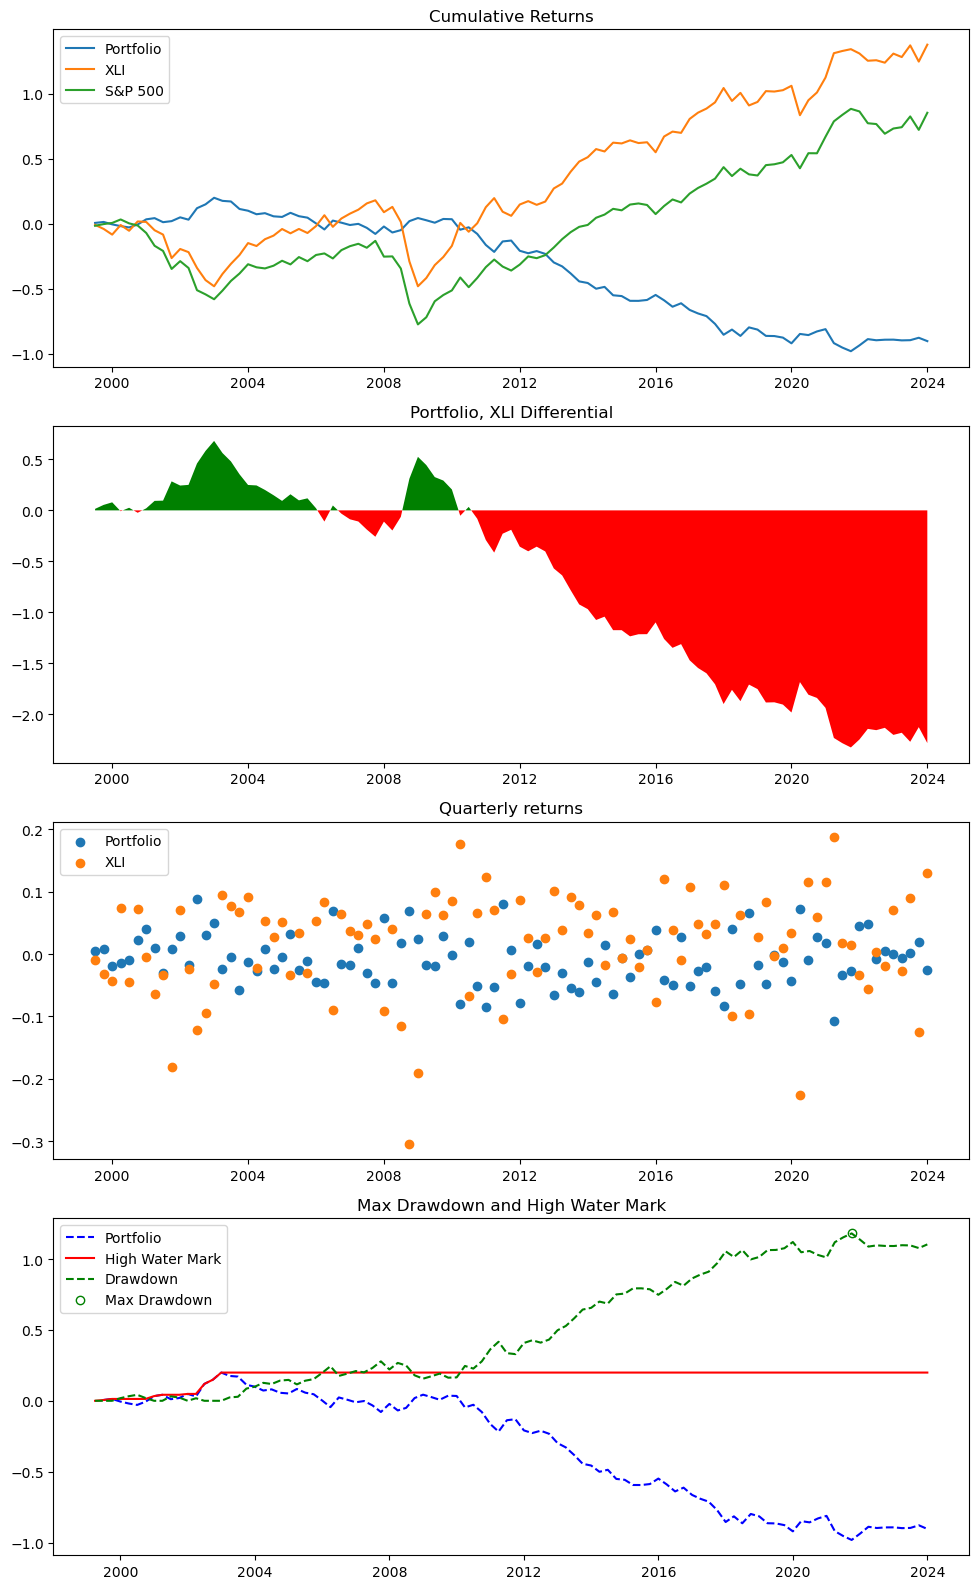

In [24]:
returns_df1 =  calc_return(df1PELS, log_returns_3)
metrics_1, HWMs_1, mdd_track_1  = calc_metrics(returns_df1)
res = graph(returns_df1, bench_ret, HWMs_1, mdd_track_1)
plt.show()

In [25]:
returns_df1.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.100239 -0.023272 -0.000000  0.091815 -0.087544 -0.103256   
1999-10-01 -0.065085  0.211784 -0.001000  0.106181  0.137346  0.005682   
2000-01-01 -0.272755  0.021696  0.334305 -0.144810  0.181824 -0.045162   
2000-04-01 -0.081163 -0.149564  0.037127 -0.150739 -0.144093 -0.125158   

                 ETN       UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                                ...                        
1999-04-01       NaN       NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01  0.069332       NaN -0.120516  0.114771  ...   NaN  0.000000  NaN   
1999-10-01 -0.281632       NaN -0.057174 -0.174089  ...   NaN -0.001000  NaN   
2000-01-01 -0.059788       NaN  0.178065  0.027789  ...   NaN  0.086488  NaN   
2000-04-01  0.154146 -0.091832 -0.087992 -0.113993  ...   NaN -0.010480  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC  Portfolio  
Date                                                                  
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN        NaN  
1999-07-01  0.136286  NaN   NaN -0.157463 -0.091401   NaN   0.005604  
1999-10-01 -0.191606  NaN   NaN  0.055475  0.010966   NaN   0.007487  
2000-01-01 -0.214101  NaN   NaN -0.173545  0.341925   NaN  -0.018565  
2000-04-01  0.031939  NaN   NaN -0.193590  0.443897   NaN  -0.013625  

[5 rows x 78 columns]

In [26]:
metrics_1

CAT        GE       UNP       RTX       HON  \
Annualized Return    -0.027491  0.058436 -0.019362 -0.022276 -0.011825   
Annualized Vol        0.294122  0.270826  0.223017  0.210830  0.259988   
Sharpe Ratio         -0.093467  0.215769 -0.086820 -0.105657 -0.045484   
Skewness             -0.566324  0.433121  0.735534  0.231035  0.552627   
Excess Kurtosis       1.147945  3.991828  1.443144  1.037829  4.357992   
High Water Mark       0.000000  1.469239  0.759034  0.518306  1.055442   
Max Drawdown          1.388699  1.354361  2.064077  1.405070  1.867941   
XLI Beta              0.302761 -0.215264 -0.445383 -0.201020 -0.292016   
Annualized XLI Alpha -0.044340  0.071006  0.005228 -0.011314  0.004306   
S&P Beta              0.336378 -0.054127 -0.531440 -0.127537 -0.208325   
Annualized S&P Alpha -0.039086  0.060892 -0.001238 -0.018104 -0.004763   

                            BA       ETN       UPS        DE       ADP  ...  \
Annualized Return    -0.079307 -0.042986 -0.055278  0.039863 -0.066576  ...   
Annualized Vol        0.303625  0.244465  0.193303  0.271489  0.184187  ...   
Sharpe Ratio         -0.261200 -0.175839 -0.285965  0.146830 -0.361457  ...   
Skewness              0.983147 -0.529391 -0.954329  0.674840  0.521113  ...   
Excess Kurtosis       9.146611  0.493345  2.858262  1.929440  1.062591  ...   
High Water Mark       0.411637  0.167166  0.446377  1.239901  0.430418  ...   
Max Drawdown          3.389286  1.262677  1.831590  0.715644  2.117108  ...   
XLI Beta             -0.168404  0.191313 -0.641029 -0.296131 -0.545329  ...   
Annualized XLI Alpha -0.070736 -0.054067 -0.020163  0.056745 -0.036900  ...   
S&P Beta             -0.102553  0.068467 -0.661802 -0.286708 -0.711953  ...   
Annualized S&P Alpha -0.076573 -0.045781 -0.033023  0.050149 -0.042706  ...   

                          ALLE       ITT       HII       AOS        AAL  \
Annualized Return    -0.013963  0.046582  0.031818 -0.109057  -0.095993   
Annualized Vol        0.126490  0.252367  0.178000  0.277953   0.297997   
Sharpe Ratio         -0.110391  0.184581  0.178755 -0.392357  -0.322128   
Skewness              0.482624 -0.175250  0.186102  0.630570  -2.243615   
Excess Kurtosis       5.320801  0.735447  2.576516  0.408284  12.320224   
High Water Mark       0.000000  1.438815  0.823129  0.173789   0.185010   
Max Drawdown          1.028517  1.428346  0.981979  3.341712   2.815778   
XLI Beta             -0.257080 -0.477121 -0.112121 -0.256046   0.462888   
Annualized XLI Alpha  0.000202  0.073605  0.038379 -0.095909  -0.122723   
S&P Beta             -0.264606 -0.510255 -0.065848 -0.317813   0.427663   
Annualized S&P Alpha -0.004983  0.064642  0.034410 -0.099203  -0.111705   

                          PAYC      CHRW       RHI      GNRC  Portfolio  
Annualized Return    -0.087286 -0.087175  0.029355  0.007511  -0.036161  
Annualized Vol        0.259214  0.209587  0.287752  0.386819   0.078566  
Sharpe Ratio         -0.336734 -0.415936  0.102015  0.019417  -0.460257  
Skewness              0.359227  0.076674  0.243603  1.516361   0.184395  
Excess Kurtosis       3.605725  0.109334  0.380368  5.363068  -0.150316  
High Water Mark       0.000000  0.000000  1.491426  0.476449   0.199080  
Max Drawdown          3.316354  2.491613  1.764284  2.210461   1.180611  
XLI Beta             -0.323550 -0.204974 -0.176555 -0.596071  -0.341942  
Annualized XLI Alpha -0.070162 -0.076649  0.039477  0.040758  -0.017496  
S&P Beta             -0.391000 -0.156529 -0.253713 -0.739428  -0.390081  
Annualized S&P Alpha -0.074690 -0.082660  0.038398  0.033076  -0.023079  

[11 rows x 78 columns]

In [27]:
df2PELS = pd.DataFrame(index = df2.index, columns = tickers[1:])
for i in tickers[1:]:
    df2PELS[i] =  np.where(df2[i] == bench, 0, 1)*np.where(df2[i] < bench, 1, -1)*np.where(df2[i] == -1, 0, 1)

In [28]:
df2PELS.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    1  -1    0   -1   -1  -1    1    0   1   -1  ...   -1     0   
1999-07-01    1   1    0   -1   -1   1    1    0   1   -1  ...   -1     0   
1999-10-01    1  -1   -1    1   -1   1    1    0   1   -1  ...   -1     0   
2000-01-01    1  -1    1   -1   -1   1    1   -1   1   -1  ...   -1     0   
2000-04-01    1  -1    1   -1   -1   1    1   -1  -1   -1  ...   -1     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    1    1     0    -1   -1     0  
1999-07-01    0    0    1    1     0    -1    1     0  
1999-10-01   -1    0    1    1     0    -1    1     0  
2000-01-01    1    0    1    1     0    -1    1     0  
2000-04-01    1    0    1    1     0    -1   -1     0  

[5 rows x 77 columns]

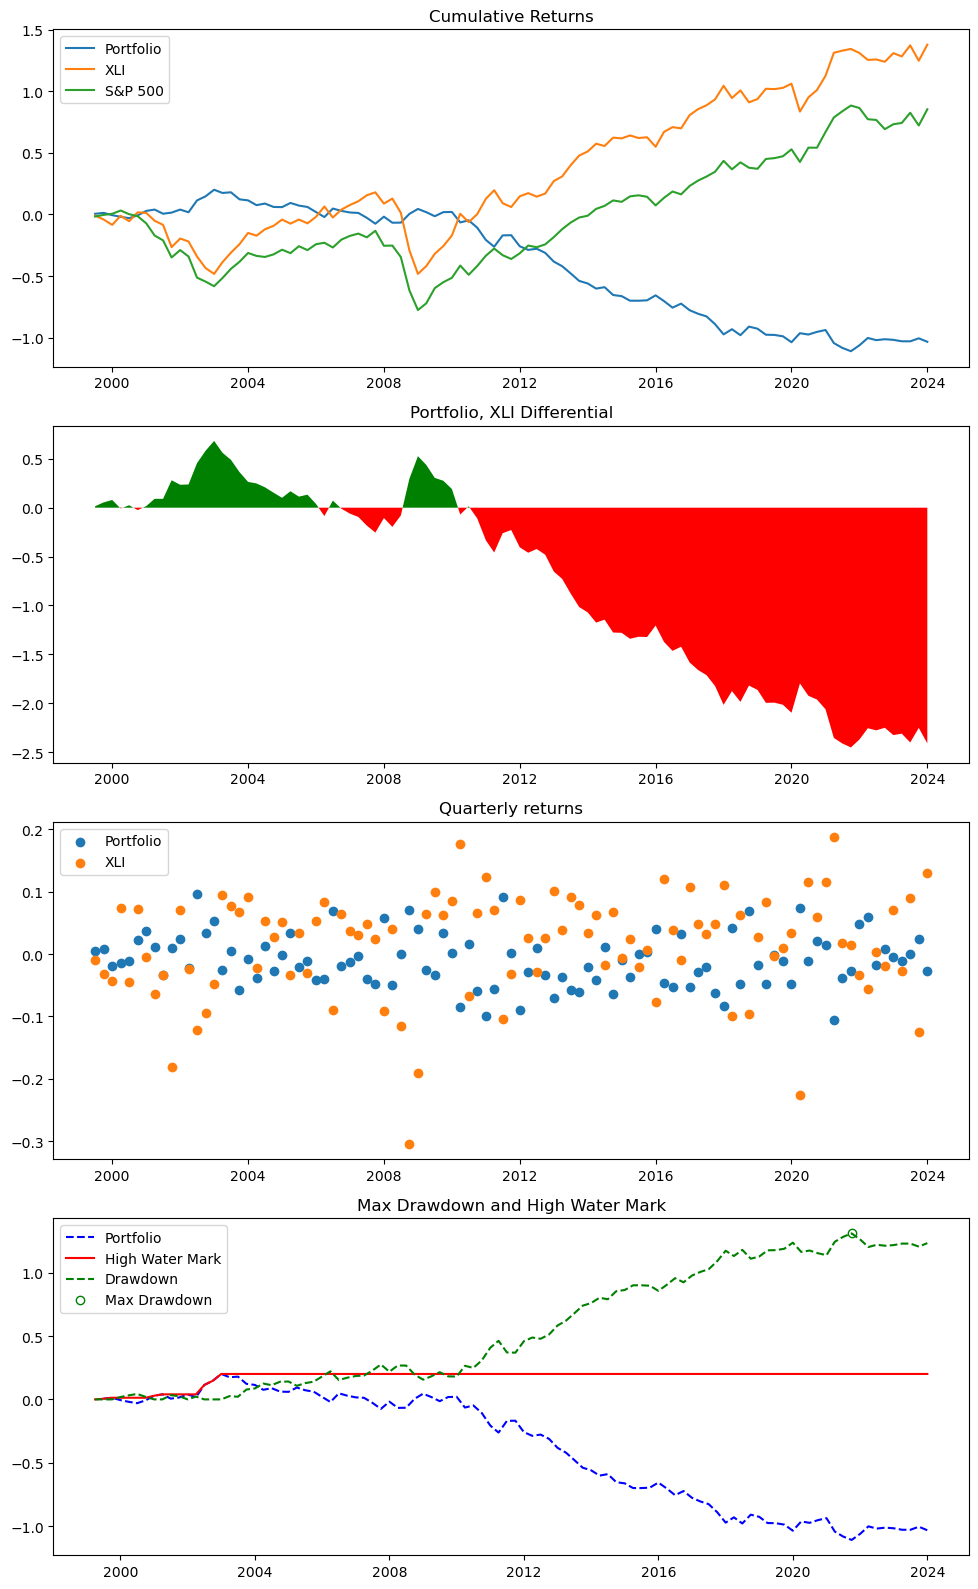

In [29]:
returns_df2 =  calc_return(df2PELS, log_returns_3)
metrics_2, HWMs_2, mdd_track_2  = calc_metrics(returns_df2)
res = graph(returns_df2, bench_ret, HWMs_2, mdd_track_2)
plt.show()

In [30]:
returns_df2.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.100239 -0.023272 -0.000000  0.091815 -0.087544 -0.103256   
1999-10-01 -0.065085  0.211784 -0.001000  0.106181  0.137346  0.005682   
2000-01-01 -0.272755  0.021696  0.334305 -0.144810  0.181824 -0.045162   
2000-04-01 -0.081163 -0.149564  0.037127 -0.150739 -0.144093 -0.125158   

                 ETN       UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                                ...                        
1999-04-01       NaN       NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01  0.069332       NaN -0.120516  0.114771  ...   NaN  0.000000  NaN   
1999-10-01 -0.281632       NaN -0.057174 -0.174089  ...   NaN -0.001000  NaN   
2000-01-01 -0.059788       NaN  0.178065  0.027789  ...   NaN  0.086488  NaN   
2000-04-01  0.154146 -0.091832 -0.087992 -0.113993  ...   NaN -0.010480  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC  Portfolio  
Date                                                                  
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN        NaN  
1999-07-01  0.136286  NaN   NaN -0.157463 -0.091401   NaN   0.005604  
1999-10-01 -0.191606  NaN   NaN  0.055475  0.010966   NaN   0.007487  
2000-01-01 -0.214101  NaN   NaN -0.173545  0.341925   NaN  -0.018565  
2000-04-01  0.031939  NaN   NaN -0.193590  0.443897   NaN  -0.013607  

[5 rows x 78 columns]

In [31]:
metrics_2

CAT        GE       UNP       RTX       HON  \
Annualized Return    -0.039276  0.051476 -0.019362 -0.025280  0.006120   
Annualized Vol        0.296904  0.291132  0.223017  0.211008  0.267248   
Sharpe Ratio         -0.132286  0.176813 -0.086820 -0.119804  0.022899   
Skewness             -0.510715  0.315477  0.735534  0.252475  0.466062   
Excess Kurtosis       0.973256  2.670057  1.443144  1.027953  3.599938   
High Water Mark       0.000000  1.804107  0.759034  0.518306  1.504064   
Max Drawdown          1.595084  1.354361  2.064077  1.480172  1.867941   
XLI Beta              0.290943 -0.271179 -0.445383 -0.200992 -0.272053   
Annualized XLI Alpha -0.055467  0.067087  0.005228 -0.014350  0.021321   
S&P Beta              0.319066 -0.102754 -0.531440 -0.133805 -0.190919   
Annualized S&P Alpha -0.050275  0.055538 -0.001238 -0.020922  0.012763   

                            BA       ETN       UPS        DE       ADP  ...  \
Annualized Return    -0.099521 -0.042986 -0.055278  0.041408 -0.066576  ...   
Annualized Vol        0.342488  0.244465  0.193303  0.273106  0.184187  ...   
Sharpe Ratio         -0.290583 -0.175839 -0.285965  0.151619 -0.361457  ...   
Skewness              0.760409 -0.529391 -0.954329  0.652180  0.521113  ...   
Excess Kurtosis       5.192457  0.493345  2.858262  1.811441  1.062591  ...   
High Water Mark       0.411637  0.167166  0.446377  1.278533  0.430418  ...   
Max Drawdown          3.574520  1.262677  1.831590  0.677013  2.117108  ...   
XLI Beta             -0.444709  0.191313 -0.641029 -0.300039 -0.545329  ...   
Annualized XLI Alpha -0.075778 -0.054067 -0.020163  0.058524 -0.036900  ...   
S&P Beta             -0.501430  0.068467 -0.661802 -0.308550 -0.711953  ...   
Annualized S&P Alpha -0.083241 -0.045781 -0.033023  0.052463 -0.042706  ...   

                          ALLE       ITT       HII       AOS       AAL  \
Annualized Return    -0.013963  0.052480  0.048178 -0.109057 -0.138450   
Annualized Vol        0.126490  0.259101  0.184969  0.277953  0.460980   
Sharpe Ratio         -0.110391  0.202545  0.260465 -0.392357 -0.300339   
Skewness              0.482624 -0.185038  0.208251  0.630570 -0.595865   
Excess Kurtosis       5.320801  0.478316  2.170209  0.408284  1.932190   
High Water Mark       0.000000  1.438815  1.232121  0.173789  0.759326   
Max Drawdown          1.028517  1.280907  0.853409  3.341712  4.451528   
XLI Beta             -0.257080 -0.436671 -0.076921 -0.256046  0.629534   
Annualized XLI Alpha  0.000202  0.077311  0.052945 -0.095909 -0.174883   
S&P Beta             -0.264606 -0.475314 -0.033025 -0.317813  0.736126   
Annualized S&P Alpha -0.004983  0.069395  0.049803 -0.099203 -0.165225   

                          PAYC      CHRW       RHI      GNRC  Portfolio  
Annualized Return    -0.102735 -0.087175  0.015045  0.007511  -0.041297  
Annualized Vol        0.269283  0.209587  0.294144  0.386819   0.083206  
Sharpe Ratio         -0.381513 -0.415936  0.051149  0.019417  -0.496326  
Skewness              0.205257  0.076674  0.219794  1.516361   0.274945  
Excess Kurtosis       3.240885  0.109334  0.274106  5.363068  -0.101953  
High Water Mark       0.000000  0.000000  1.491426  0.476449   0.200813  
Max Drawdown          3.702570  2.491613  2.122031  2.210461   1.309682  
XLI Beta             -0.312058 -0.204974 -0.208818 -0.596071  -0.361775  
Annualized XLI Alpha -0.086406 -0.076649  0.026818  0.040758  -0.021581  
S&P Beta             -0.374314 -0.156529 -0.301070 -0.739428  -0.415504  
Annualized S&P Alpha -0.090869 -0.082660  0.025576  0.033076  -0.027391  

[11 rows x 78 columns]

## Compared to average PE, equal weights

In [32]:
df3 = df1
'''time_mean = []
for i in range(len(df3)):
    mean = df3.iloc[i].mean()
    time_mean.append(mean)
df3['MEAN PE'] = time_mean
'''
df3PELS = pd.DataFrame(index = df.index, columns = tickers[1:])

for i in tickers[1:]:
    df3PELS[i] =  np.where(df3[i] == df3['MEAN PE'], 0, 1)*np.where(df3[i] < df3['MEAN PE'], 1, -1)*np.where(df3[i] == -1, 0, 1)
df3PELS.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    1  -1    0   -1    1   1    1    0   1   -1  ...   -1     0   
1999-07-01    1   1    0    1    1   1    1    0   1    1  ...    1     0   
1999-10-01    1  -1   -1    1    1   1    1    0   1   -1  ...   -1     0   
2000-01-01    1  -1    1   -1   -1   1    1   -1   1   -1  ...   -1     0   
2000-04-01    1  -1    1    1    1   1    1   -1  -1    1  ...    1     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    1    1     0    -1    1     0  
1999-07-01    0    0    1    1     0     1    1     0  
1999-10-01   -1    0    1    1     0    -1    1     0  
2000-01-01    1    0    1    1     0    -1    1     0  
2000-04-01    1    0    1    1     0     1    1     0  

[5 rows x 77 columns]

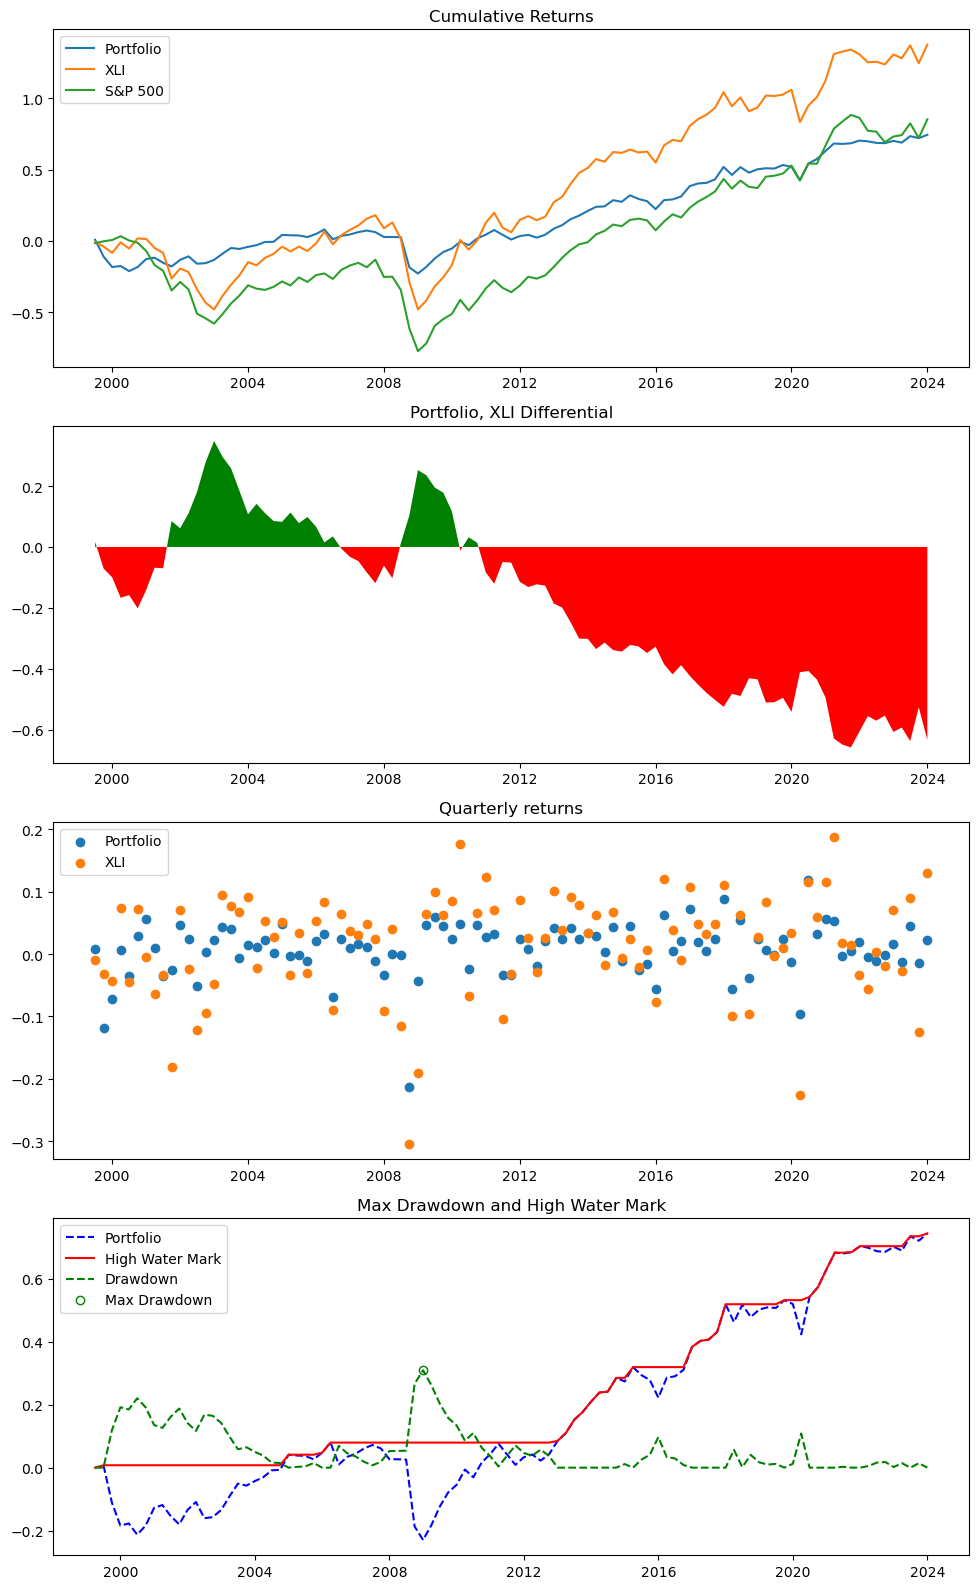

In [33]:
returns_df3 =  calc_return(df3PELS, log_returns_3)
metrics_3, HWMs_3, mdd_track_3  = calc_metrics(returns_df3)
res = graph(returns_df3, bench_ret, HWMs_3, mdd_track_3)
plt.show()

In [34]:
returns_df3.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.100239 -0.023272 -0.000000  0.090815  0.087544  0.102256   
1999-10-01 -0.065085  0.211784 -0.001000 -0.107181 -0.137346  0.005682   
2000-01-01 -0.272755  0.021696  0.334305 -0.144810 -0.182824 -0.045162   
2000-04-01 -0.081163 -0.149564  0.037127 -0.151739 -0.145093 -0.125158   

                 ETN       UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                                ...                        
1999-04-01       NaN       NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01  0.069332       NaN -0.120516  0.113771  ...   NaN  0.000000  NaN   
1999-10-01 -0.281632       NaN -0.057174  0.173089  ...   NaN -0.001000  NaN   
2000-01-01 -0.059788       NaN  0.178065  0.027789  ...   NaN  0.086488  NaN   
2000-04-01  0.154146 -0.091832 -0.087992 -0.114993  ...   NaN -0.010480  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC  Portfolio  
Date                                                                  
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN        NaN  
1999-07-01  0.136286  NaN   NaN -0.158463  0.090401   NaN   0.007636  
1999-10-01 -0.191606  NaN   NaN -0.056475  0.010966   NaN  -0.119143  
2000-01-01 -0.214101  NaN   NaN -0.173545  0.341925   NaN  -0.072689  
2000-04-01  0.031939  NaN   NaN -0.194590  0.444897   NaN   0.006892  

[5 rows x 78 columns]

In [35]:
metrics_3

CAT        GE       UNP       RTX       HON  \
Annualized Return     0.017718  0.075870  0.111486 -0.003467 -0.012659   
Annualized Vol        0.296302  0.269774  0.216196  0.211329  0.260318   
Sharpe Ratio          0.059799  0.281235  0.515670 -0.016407 -0.048628   
Skewness             -0.686685  0.401378 -0.679139 -0.555458 -0.784107   
Excess Kurtosis       1.239871  4.021877  2.203880  0.968810  4.216226   
High Water Mark       0.438532  1.905092  2.823070  1.112712  0.087544   
Max Drawdown          1.129201  1.158951  0.625556  1.305695  1.831733   
XLI Beta              0.891112  0.505741  0.746059  0.739614  0.790859   
Annualized XLI Alpha -0.031873  0.048491  0.071093 -0.044663 -0.056799   
S&P Beta              0.974618  0.674766  0.877973  0.719233  0.816217   
Annualized S&P Alpha -0.015879  0.053376  0.082346 -0.028296 -0.040923   

                            BA       ETN       UPS        DE       ADP  ...  \
Annualized Return     0.072631  0.060370  0.013001  0.090785 -0.011962  ...   
Annualized Vol        0.304018  0.243649  0.195116  0.268479  0.187074  ...   
Sharpe Ratio          0.238903  0.247774  0.066629  0.338148 -0.063944  ...   
Skewness              0.727522 -0.840254  0.594719 -0.962410 -0.549828  ...   
Excess Kurtosis       8.231736  1.109111  3.167609  2.884820  0.567238  ...   
High Water Mark       1.815767  1.672020  0.738161  2.379644  0.341561  ...   
Max Drawdown          1.445564  0.776144  0.768484  0.692360  0.792137  ...   
XLI Beta              0.336500  0.797449  0.072207  0.845499  0.107482  ...   
Annualized XLI Alpha  0.054638  0.016601  0.009113  0.044650 -0.018065  ...   
S&P Beta              0.433235  0.807941  0.044238  0.915845  0.216052  ...   
Annualized S&P Alpha  0.058430  0.033128  0.011607  0.060131 -0.019531  ...   

                          ALLE       ITT       HII       AOS        AAL  \
Annualized Return    -0.035481  0.066725  0.059960  0.109952  -0.095993   
Annualized Vol        0.125533  0.251336  0.176415  0.277578   0.297997   
Sharpe Ratio         -0.282646  0.265480  0.339881  0.396113  -0.322128   
Skewness             -0.732607 -0.256651  0.280865 -0.015545  -2.243615   
Excess Kurtosis       4.966353  0.808829  2.561870 -0.070817  12.320224   
High Water Mark       0.033771  1.668116  1.526674  2.981956   0.185010   
Max Drawdown          1.142399  0.721875  0.555040  0.765482   2.815778   
XLI Beta              0.085179  0.608026  0.385031  0.339671   0.462888   
Annualized XLI Alpha -0.040580  0.033561  0.039138  0.092160  -0.122723   
S&P Beta              0.075511  0.686832  0.343046  0.369593   0.427663   
Annualized S&P Alpha -0.038443  0.043722  0.048740  0.098322  -0.111705   

                          PAYC      CHRW       RHI      GNRC  Portfolio  
Annualized Return    -0.080529 -0.024131  0.073225  0.103549   0.029769  
Annualized Vol        0.259722  0.213764  0.285895  0.383149   0.086484  
Sharpe Ratio         -0.310057 -0.112886  0.256124  0.270258   0.344214  
Skewness              0.323755  0.399576  0.261564  1.749391  -1.564294  
Excess Kurtosis       3.538069  0.121414  0.313422  4.664296   6.101396  
High Water Mark       0.000000  0.033363  2.219867  2.877411   0.744224  
Max Drawdown          3.147411  1.161817  0.724996  1.406652   0.309315  
XLI Beta             -0.297869  0.019405  0.322507 -0.111553   0.415611  
Annualized XLI Alpha -0.064765 -0.025455  0.056016  0.110803   0.006941  
S&P Beta             -0.351886  0.049436  0.420516 -0.270670   0.441480  
Annualized S&P Alpha -0.069212 -0.026079  0.059468  0.113926   0.014851  

[11 rows x 78 columns]

In [36]:
df4 = df2
'''time_mean = []
for i in range(len(df4)):
    mean = df4.iloc[i].mean()
    time_mean.append(mean)
df4['MEAN PE'] = time_mean
'''

df4PELS = pd.DataFrame(index = df4.index, columns = tickers[1:])
for i in tickers[1:]:
    df4PELS[i] =  np.where(df4[i] == df4['MEAN PE'], 0, 1)*np.where(df4[i] < df4['MEAN PE'], 1, -1)*np.where(df4[i] == -1, 0, 1)
df4PELS.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    1  -1    0   -1    1   1    1    0   1   -1  ...   -1     0   
1999-07-01    1   1    0    1    1   1    1    0   1    1  ...    1     0   
1999-10-01    1  -1   -1    1    1   1    1    0   1   -1  ...   -1     0   
2000-01-01    1  -1    1   -1   -1   1    1   -1   1   -1  ...   -1     0   
2000-04-01    1  -1    1    1    1   1    1   -1  -1    1  ...    1     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    1    1     0    -1    1     0  
1999-07-01    0    0    1    1     0     1    1     0  
1999-10-01   -1    0    1    1     0    -1    1     0  
2000-01-01    1    0    1    1     0    -1    1     0  
2000-04-01    1    0    1    1     0     1    1     0  

[5 rows x 77 columns]

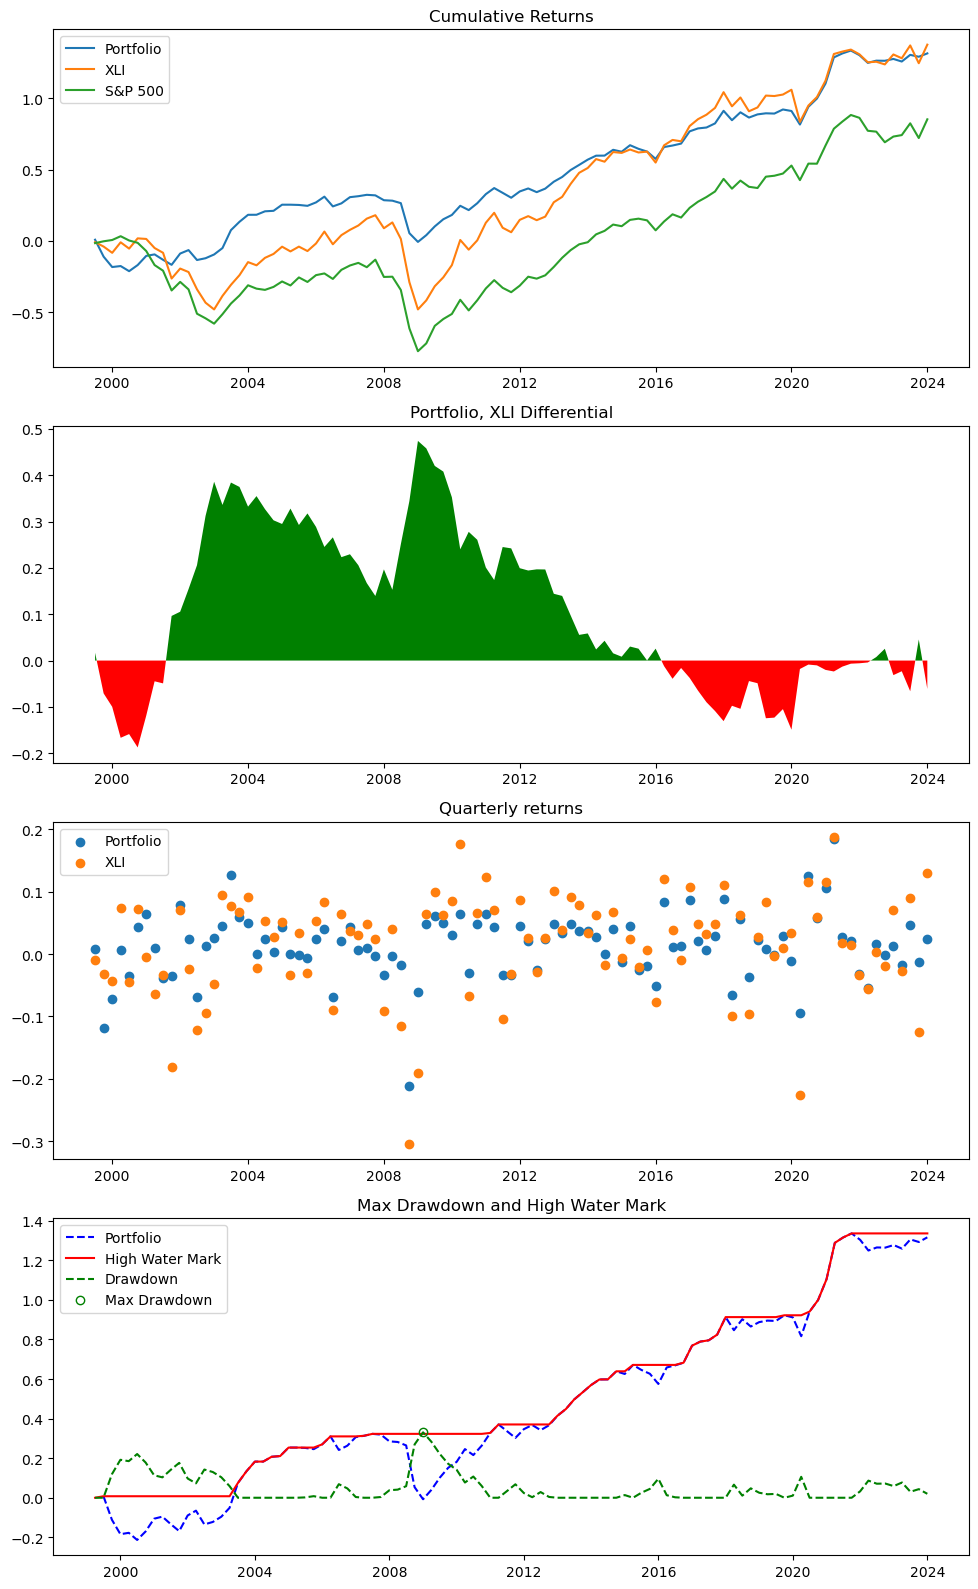

In [37]:
returns_df4 =  calc_return(df4PELS, log_returns_3)
metrics_4, HWMs_4, mdd_track_4  = calc_metrics(returns_df4)
res = graph(returns_df4, bench_ret, HWMs_4, mdd_track_4)
plt.show()

In [38]:
returns_df4.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.100239 -0.023272 -0.000000  0.090815  0.087544  0.102256   
1999-10-01 -0.065085  0.211784 -0.001000 -0.107181 -0.137346  0.005682   
2000-01-01 -0.272755  0.021696  0.334305 -0.144810 -0.182824 -0.045162   
2000-04-01 -0.081163 -0.149564  0.037127 -0.151739 -0.145093 -0.125158   

                 ETN       UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                                ...                        
1999-04-01       NaN       NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01  0.069332       NaN -0.120516  0.113771  ...   NaN  0.000000  NaN   
1999-10-01 -0.281632       NaN -0.057174  0.173089  ...   NaN -0.001000  NaN   
2000-01-01 -0.059788       NaN  0.178065  0.027789  ...   NaN  0.086488  NaN   
2000-04-01  0.154146 -0.091832 -0.087992 -0.114993  ...   NaN -0.010480  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC  Portfolio  
Date                                                                  
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN        NaN  
1999-07-01  0.136286  NaN   NaN -0.158463  0.090401   NaN   0.007636  
1999-10-01 -0.191606  NaN   NaN -0.056475  0.010966   NaN  -0.119143  
2000-01-01 -0.214101  NaN   NaN -0.173545  0.341925   NaN  -0.072689  
2000-04-01  0.031939  NaN   NaN -0.194590  0.444897   NaN   0.006909  

[5 rows x 78 columns]

In [39]:
log_returns_3['CAT'].std()

0.14772095528373116

In [40]:
metrics_4

CAT        GE       UNP       RTX       HON  \
Annualized Return     0.032797  0.013866  0.111486  0.049420  0.009261   
Annualized Vol        0.299135  0.292199  0.216196  0.210163  0.267600   
Sharpe Ratio          0.109641  0.047455  0.515670  0.235151  0.034608   
Skewness             -0.609563  0.282200 -0.679139 -0.564323 -0.775118   
Excess Kurtosis       1.148990  2.717544  2.203880  1.259434  3.661780   
High Water Mark       0.857589  1.219219  2.823070  1.420105  0.407166   
Max Drawdown          1.078808  1.158951  0.625556  0.594274  1.371726   
XLI Beta              0.986776  0.598559  0.746059  0.897133  0.823481   
Annualized XLI Alpha -0.022118 -0.019304  0.071093 -0.000007 -0.036473   
S&P Beta              1.076180  0.820072  0.877973  0.884855  0.872161   
Annualized S&P Alpha -0.004301 -0.014263  0.082346  0.019416 -0.020711   

                            BA       ETN       UPS        DE       ADP  ...  \
Annualized Return     0.048762  0.081841  0.038867  0.115702  0.086834  ...   
Annualized Vol        0.345180  0.242084  0.194245  0.267709  0.181767  ...   
Sharpe Ratio          0.141265  0.338069  0.200093  0.432192  0.477720  ...   
Skewness              0.447718 -0.890534  0.615415 -1.056776 -0.582173  ...   
Excess Kurtosis       4.449127  1.315523  3.062045  3.107233  1.287011  ...   
High Water Mark       1.822394  2.208799  1.384826  3.002552  2.283847  ...   
Max Drawdown          2.010108  0.776144  0.442353  0.692360  0.483100  ...   
XLI Beta              0.339031  0.918044  0.292233  0.843139  0.257753  ...   
Annualized XLI Alpha  0.030387  0.031578  0.022997  0.069949  0.073367  ...   
S&P Beta              0.478607  0.963506  0.237196  0.925306  0.250683  ...   
Annualized S&P Alpha  0.032756  0.049454  0.031083  0.084973  0.079069  ...   

                          ALLE       ITT       HII       AOS       AAL  \
Annualized Return    -0.009107  0.090430  0.076360  0.101297 -0.138450   
Annualized Vol        0.126701  0.256648  0.182816  0.278541  0.460980   
Sharpe Ratio         -0.071878  0.352350  0.417687  0.363670 -0.300339   
Skewness              0.004728 -0.292473  0.282014 -0.022457 -0.595865   
Excess Kurtosis       5.187546  0.617858  2.164096 -0.067231  1.932190   
High Water Mark       0.033771  2.260748  1.936667  2.765578  0.759326   
Max Drawdown          0.483040  0.656723  0.555040  1.096780  4.451528   
XLI Beta              0.228223  0.872756  0.420359  0.320992  0.629534   
Annualized XLI Alpha -0.021900  0.042774  0.053738  0.084457 -0.174883   
S&P Beta              0.230774  0.997256  0.375976  0.365772  0.736126   
Annualized S&P Alpha -0.017154  0.056966  0.064170  0.089712 -0.165225   

                          PAYC      CHRW       RHI      GNRC  Portfolio  
Annualized Return    -0.060562 -0.016670  0.029307  0.155787   0.052642  
Annualized Vol        0.272409  0.214021  0.294060  0.378709   0.104750  
Sharpe Ratio         -0.222321 -0.077888  0.099662  0.411362   0.502547  
Skewness              0.125780  0.297162  0.326981  1.249108  -0.565756  
Excess Kurtosis       2.998118  0.082164  0.235612  4.857858   3.287909  
High Water Mark       0.000000  0.000000  1.166821  4.183348   1.335959  
Max Drawdown          3.160111  1.106598  1.259794  1.147555   0.330612  
XLI Beta             -0.244933  0.001486  0.274206  0.267555   0.527901  
Annualized XLI Alpha -0.047543 -0.016921  0.014343  0.142471   0.023795  
S&P Beta             -0.333157  0.046065  0.394710  0.183347   0.572420  
Annualized S&P Alpha -0.049689 -0.018426  0.015996  0.151040   0.033441  

[11 rows x 78 columns]

# Unequal Weights

In [41]:
#underweight
df3PEUW = pd.DataFrame(index = df.index, columns = tickers[1:])

for i in tickers[1:]:
    df3PEUW[i] =  np.where(df3[i] == df3['MEAN PE'], 0, 1)*np.where(df3[i] < df3['MEAN PE'], np.minimum(df3['MEAN PE']/df3[i],10), -1*np.minimum(df3[i]/df3['MEAN PE'],10))*np.where(df3[i] == -1, 0, 1)
df3PEUW.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01  1.749778 -1.681557 -0.000000 -1.165405  1.106152  1.071276   
1999-07-01  3.958271  4.052516 -0.000000  3.127503  3.088409  3.621397   
1999-10-01  1.296855 -1.506355 -5.567017  1.221964  1.112726  1.334336   
2000-01-01  1.379083 -1.946885  1.763257 -1.595668 -1.229867  1.483509   
2000-04-01  2.953214 -1.115702  3.566050  1.485537  1.569277  2.727528   

                 ETN       UPS        DE       ADP  ...       ROL  ALLE  \
Date                                                ...                   
1999-04-01  1.454608 -0.000000  2.907358 -1.698689  ... -3.355646  -0.0   
1999-07-01  3.919782 -0.000000  4.916081  1.914814  ...  1.250286  -0.0   
1999-10-01  1.878137 -0.000000  1.838698 -1.555189  ... -2.250278  -0.0   
2000-01-01  2.853826 -3.630053  1.266577 -1.818875  ... -1.688029  -0.0   
2000-04-01  4.816430 -1.538611 -1.078584  1.090584  ...  1.028787  -0.0   

                 ITT  HII       AOS        AAL  PAYC      CHRW       RHI  GNRC  
Date                                                                            
1999-04-01 -0.000000 -0.0  2.373787   5.433082  -0.0 -1.016051  1.005949  -0.0  
1999-07-01 -0.000000 -0.0  6.350957  10.000000  -0.0  2.417694  4.422202  -0.0  
1999-10-01 -3.796803 -0.0  1.712233   5.224777  -0.0 -1.105448  1.593000  -0.0  
2000-01-01  1.867291 -0.0  2.380482   3.326899  -0.0 -1.248501  1.322206  -0.0  
2000-04-01  3.563008 -0.0  5.092494   6.069542  -0.0  1.558151  1.427151  -0.0  

[5 rows x 77 columns]

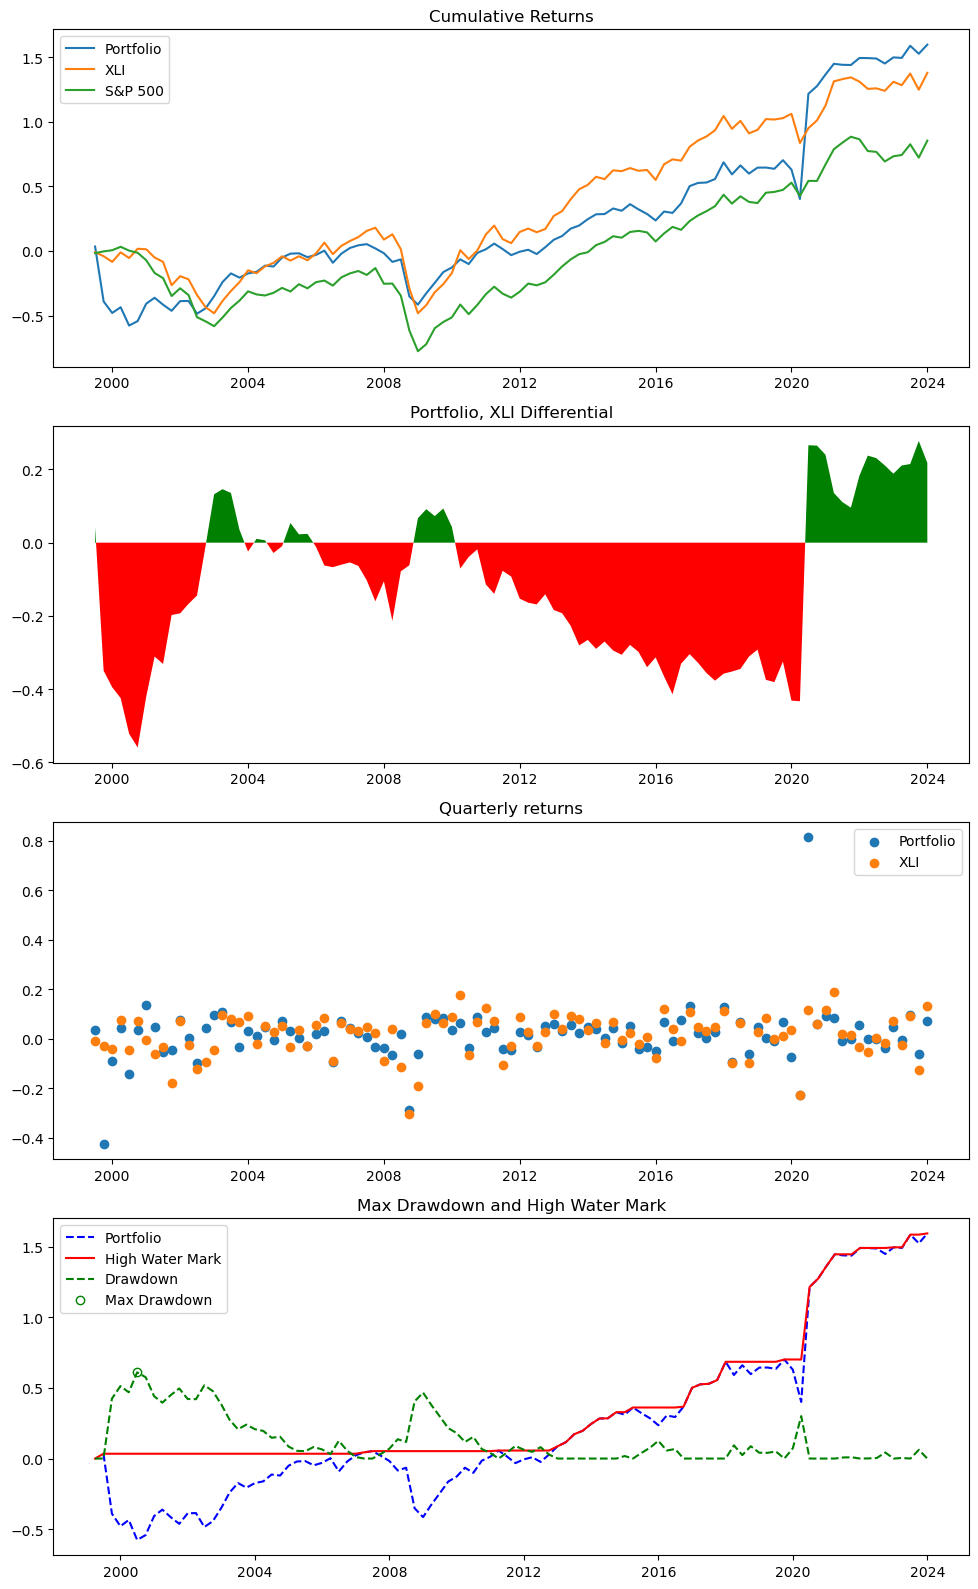

In [42]:
returns_df3UW =  calc_return(df3PEUW, log_returns_3)
metrics_3UW, HWMs_3UW, mdd_track_3UW = calc_metrics(returns_df3UW)
res = graph(returns_df3UW, bench_ret,HWMs_3UW, mdd_track_3UW)
plt.show()

In [43]:
returns_df3UW.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.176396 -0.038452  0.000000  0.106002  0.095837  0.108544   
1999-10-01 -0.258625  0.861311 -0.001000 -0.336210 -0.425182  0.019577   
2000-01-01 -0.354724  0.031681  1.865650 -0.176730 -0.203320 -0.061261   
2000-04-01 -0.112931 -0.292185  0.064464 -0.241529 -0.178215 -0.186673   

                 ETN       UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                                ...                        
1999-04-01       NaN       NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01  0.099851       NaN -0.351383  0.193960  ...   NaN -0.000000  NaN   
1999-10-01 -1.104935       NaN -0.282074  0.332349  ...   NaN -0.001000  NaN   
2000-01-01 -0.113289       NaN  0.326409  0.042217  ...   NaN  0.331176  NaN   
2000-04-01  0.438906 -0.334354 -0.111182 -0.208338  ...   NaN -0.020569  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC  Portfolio  
Date                                                                  
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN        NaN  
1999-07-01  0.322514  NaN   NaN -0.160990  0.089939   NaN   0.034101  
1999-10-01 -1.217881  NaN   NaN -0.135121  0.047493   NaN  -0.424674  
2000-01-01 -0.367591  NaN   NaN -0.192845  0.543687   NaN  -0.088814  
2000-04-01  0.075030  NaN   NaN -0.242698  0.587245   NaN   0.044082  

[5 rows x 78 columns]

In [44]:
metrics_3UW

CAT         GE        UNP       RTX       HON  \
Annualized Return     0.003501   0.298798   0.267070 -0.051058  0.021280   
Annualized Vol        0.686377   1.312191   0.495060  0.404987  0.430336   
Sharpe Ratio          0.005101   0.227709   0.539470 -0.126073  0.049449   
Skewness             -1.066133   7.502554   3.773183 -1.740068  0.193404   
Excess Kurtosis       9.780464  66.065674  26.174204  6.591340  6.610007   
High Water Mark       0.442312   7.970219   6.679724  1.611751  0.732821   
Max Drawdown          3.512154   1.859091   0.830402  3.035711  2.115093   
XLI Beta              1.487362  -1.046913   1.076226  0.885560  1.072657   
Annualized XLI Alpha -0.079272   0.360078   0.209875 -0.100856 -0.038200   
S&P Beta              1.674511  -0.146162   1.418286  0.800127  1.165202   
Annualized S&P Alpha -0.054223   0.306855   0.220876 -0.079156 -0.018672   

                            BA       ETN        UPS        DE       ADP  ...  \
Annualized Return     0.087392  0.089095   0.239517  0.180693 -0.013544  ...   
Annualized Vol        0.468016  0.538601   0.843366  0.517475  0.264672  ...   
Sharpe Ratio          0.186728  0.165419   0.284001  0.349182 -0.051174  ...   
Skewness              0.085472 -1.205940   4.450263  1.503438 -0.782019  ...   
Excess Kurtosis       7.105123  5.502163  22.381762  9.749335  2.042460  ...   
High Water Mark       2.184793  2.423306   6.636852  4.732471  0.773608  ...   
Max Drawdown          2.412378  1.875412   1.579458  0.944869  1.295221  ...   
XLI Beta              0.648932  1.636395  -1.024186  1.518964  0.021157  ...   
Annualized XLI Alpha  0.052161 -0.001072   0.298933  0.097986 -0.014859  ...   
S&P Beta              0.810253  1.596540  -1.179472  1.685162  0.122653  ...   
Annualized S&P Alpha  0.060343  0.034959   0.282595  0.124427 -0.017909  ...   

                          ALLE       ITT       HII       AOS        AAL  \
Annualized Return    -0.067636  0.165559  0.080947  0.117553  -0.217534   
Annualized Vol        0.176705  0.453119  0.383033  0.581467   1.086717   
Sharpe Ratio         -0.382760  0.365377  0.211333  0.202166  -0.200175   
Skewness             -0.484852 -0.013463 -0.070954 -1.160570  -2.513519   
Excess Kurtosis       4.171324  2.514808  7.675166  6.759835  19.669949   
High Water Mark       0.000000  4.138980  2.373892  3.164557   1.155158   
Max Drawdown          2.018636  1.245687  1.785248  3.146212   8.441587   
XLI Beta              0.130468  1.017815  0.676791  0.820209   1.873661   
Annualized XLI Alpha -0.075580  0.110589  0.044101  0.073095  -0.324002   
S&P Beta              0.102844  1.210672  0.540080  0.813890   1.618232   
Annualized S&P Alpha -0.071864  0.125497  0.063147  0.090684  -0.275515   

                           PAYC       CHRW       RHI       GNRC  Portfolio  
Annualized Return     -0.430437   0.044699  0.060102   0.274986   0.063819  
Annualized Vol         1.179008   0.529784  0.578491   0.869270   0.227381  
Sharpe Ratio          -0.365084   0.084371  0.103894   0.316342   0.280669  
Skewness              -1.218010   5.399125 -1.160089   4.159321   2.589969  
Excess Kurtosis       10.877995  41.404333  6.130892  21.296145  24.728271  
High Water Mark        0.000000   1.697970  2.871951   7.373762   1.595465  
Max Drawdown          14.814667   1.653738  3.283259   1.718174   0.610924  
XLI Beta              -1.312940   0.335732  0.527338   0.219092   0.745370  
Annualized XLI Alpha  -0.361719   0.026466  0.031362   0.265571   0.022983  
S&P Beta              -1.589872   0.521338  0.728092   0.169516   0.807322  
Annualized S&P Alpha  -0.379979   0.027178  0.035610   0.271920   0.036633  

[11 rows x 78 columns]

In [45]:
#overweight
df3PEOW = pd.DataFrame(index = df.index, columns = tickers[1:])

for i in tickers[1:]:
    df3PEOW[i] =  np.where(df3[i] == df3['MEAN PE'], 0, 1)*np.where(df3[i] < df3['MEAN PE'], df3['MEAN PE']/df3[i], -1*df3[i]/df3['MEAN PE'])*np.where(df3[i] == -1, 0, 1)
df3PEOW.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01  1.749778 -1.681557 -0.000000 -1.165405  1.106152  1.071276   
1999-07-01  3.958271  4.052516 -0.000000  3.127503  3.088409  3.621397   
1999-10-01  1.296855 -1.506355 -5.567017  1.221964  1.112726  1.334336   
2000-01-01  1.379083 -1.946885  1.763257 -1.595668 -1.229867  1.483509   
2000-04-01  2.953214 -1.115702  3.566050  1.485537  1.569277  2.727528   

                 ETN       UPS        DE       ADP  ...       ROL  ALLE  \
Date                                                ...                   
1999-04-01  1.454608 -0.000000  2.907358 -1.698689  ... -3.355646  -0.0   
1999-07-01  3.919782 -0.000000  4.916081  1.914814  ...  1.250286  -0.0   
1999-10-01  1.878137 -0.000000  1.838698 -1.555189  ... -2.250278  -0.0   
2000-01-01  2.853826 -3.630053  1.266577 -1.818875  ... -1.688029  -0.0   
2000-04-01  4.816430 -1.538611 -1.078584  1.090584  ...  1.028787  -0.0   

                 ITT  HII       AOS        AAL  PAYC      CHRW       RHI  GNRC  
Date                                                                            
1999-04-01 -0.000000 -0.0  2.373787   5.433082  -0.0 -1.016051  1.005949  -0.0  
1999-07-01 -0.000000 -0.0  6.350957  14.210120  -0.0  2.417694  4.422202  -0.0  
1999-10-01 -3.796803 -0.0  1.712233   5.224777  -0.0 -1.105448  1.593000  -0.0  
2000-01-01  1.867291 -0.0  2.380482   3.326899  -0.0 -1.248501  1.322206  -0.0  
2000-04-01  3.563008 -0.0  5.092494   6.069542  -0.0  1.558151  1.427151  -0.0  

[5 rows x 77 columns]

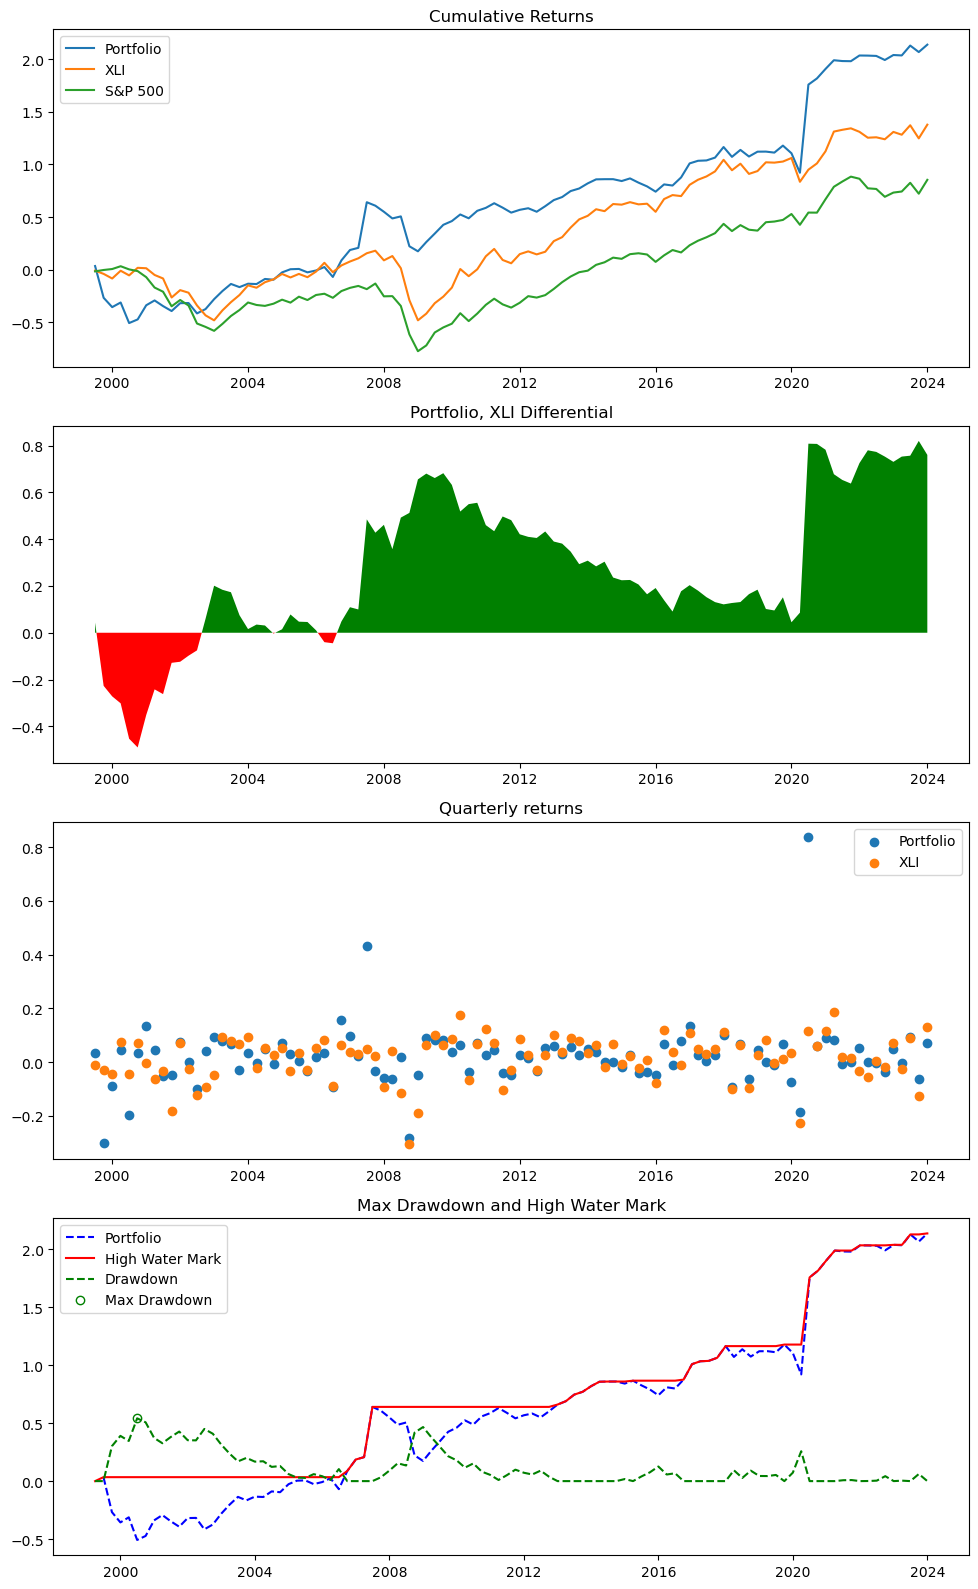

In [46]:
returns_df3OW =  calc_return(df3PEOW, log_returns_3)
metrics_3OW, HWMs_3OW, mdd_track_3OW = calc_metrics(returns_df3OW)
res = graph(returns_df3OW, bench_ret,HWMs_3OW, mdd_track_3OW)
plt.show()

In [47]:
returns_df3OW.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.176396 -0.038452  0.000000  0.106002  0.095837  0.108544   
1999-10-01 -0.258625  0.861311 -0.001000 -0.336210 -0.425182  0.019577   
2000-01-01 -0.354724  0.031681  1.865650 -0.176730 -0.203320 -0.061261   
2000-04-01 -0.112931 -0.292185  0.064464 -0.241529 -0.178215 -0.186673   

                 ETN       UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                                ...                        
1999-04-01       NaN       NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01  0.099851       NaN -0.351383  0.193960  ...   NaN -0.000000  NaN   
1999-10-01 -1.104935       NaN -0.282074  0.332349  ...   NaN -0.001000  NaN   
2000-01-01 -0.113289       NaN  0.326409  0.042217  ...   NaN  0.331176  NaN   
2000-04-01  0.438906 -0.334354 -0.111182 -0.208338  ...   NaN -0.020569  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC  Portfolio  
Date                                                                  
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN        NaN  
1999-07-01  0.322514  NaN   NaN -0.160990  0.089939   NaN   0.034101  
1999-10-01 -1.217881  NaN   NaN -0.135121  0.047493   NaN  -0.301727  
2000-01-01 -0.367591  NaN   NaN -0.192845  0.543687   NaN  -0.088814  
2000-04-01  0.075030  NaN   NaN -0.242698  0.587245   NaN   0.044082  

[5 rows x 78 columns]

In [48]:
metrics_3OW

CAT         GE        UNP       RTX       HON  \
Annualized Return     -0.076375   0.425477   0.267070 -0.051058  0.021280   
Annualized Vol         0.997368   1.910189   0.495060  0.404987  0.430336   
Sharpe Ratio          -0.076576   0.222741   0.539470 -0.126073  0.049449   
Skewness              -4.808677   8.695040   3.773183 -1.740068  0.193404   
Excess Kurtosis       39.016682  80.177299  26.174204  6.591340  6.610007   
High Water Mark        0.442312  11.137176   6.679724  1.611751  0.732821   
Max Drawdown           5.646355   1.859091   0.830402  3.035711  2.115093   
XLI Beta               1.207220  -2.168008   1.076226  0.885560  1.072657   
Annualized XLI Alpha  -0.143557   0.550426   0.209875 -0.100856 -0.038200   
S&P Beta               1.346799  -0.895163   1.418286  0.800127  1.165202   
Annualized S&P Alpha  -0.122801   0.460632   0.220876 -0.079156 -0.018672   

                            BA       ETN        UPS        DE       ADP  ...  \
Annualized Return     0.087392  0.089095   0.286735  0.180693 -0.013544  ...   
Annualized Vol        0.468016  0.538601   0.968190  0.517475  0.264672  ...   
Sharpe Ratio          0.186728  0.165419   0.296156  0.349182 -0.051174  ...   
Skewness              0.085472 -1.205940   4.693918  1.503438 -0.782019  ...   
Excess Kurtosis       7.105123  5.502163  23.689473  9.749335  2.042460  ...   
High Water Mark       2.184793  2.423306   7.817308  4.732471  0.773608  ...   
Max Drawdown          2.412378  1.875412   1.579458  0.944869  1.295221  ...   
XLI Beta              0.648932  1.636395  -1.416436  1.518964  0.021157  ...   
Annualized XLI Alpha  0.052161 -0.001072   0.368457  0.097986 -0.014859  ...   
S&P Beta              0.810253  1.596540  -1.653528  1.685162  0.122653  ...   
Annualized S&P Alpha  0.060343  0.034959   0.346632  0.124427 -0.017909  ...   

                          ALLE       ITT       HII       AOS        AAL  \
Annualized Return    -0.067636  0.165559  0.080947  0.117553  -0.301739   
Annualized Vol        0.176705  0.453119  0.383033  0.581467   1.216744   
Sharpe Ratio         -0.382760  0.365377  0.211333  0.202166  -0.247989   
Skewness             -0.484852 -0.013463 -0.070954 -1.160570  -2.679076   
Excess Kurtosis       4.171324  2.514808  7.675166  6.759835  15.711184   
High Water Mark       0.000000  4.138980  2.373892  3.164557   1.155158   
Max Drawdown          2.018636  1.245687  1.785248  3.146212  10.546725   
XLI Beta              0.130468  1.017815  0.676791  0.820209   1.559932   
Annualized XLI Alpha -0.075580  0.110589  0.044101  0.073095  -0.391599   
S&P Beta              0.102844  1.210672  0.540080  0.813890   1.136647   
Annualized S&P Alpha -0.071864  0.125497  0.063147  0.090684  -0.343970   

                           PAYC       CHRW        RHI       GNRC  Portfolio  
Annualized Return     -0.632678   0.044699  -0.029400   0.274986   0.085510  
Annualized Vol         1.738182   0.529784   0.818076   0.869270   0.238108  
Sharpe Ratio          -0.363988   0.084371  -0.035938   0.316342   0.359121  
Skewness              -4.365459   5.399125  -3.309147   4.159321   3.165340  
Excess Kurtosis       29.462661  41.404333  17.772733  21.296145  22.045136  
High Water Mark        0.000000   1.697970   2.871951   7.373762   2.137741  
Max Drawdown          19.870689   1.653738   5.713105   1.718174   0.541884  
XLI Beta              -1.594775   0.335732   0.431126   0.219092   0.745245  
Annualized XLI Alpha  -0.550318   0.026466  -0.053690   0.265571   0.044900  
S&P Beta              -1.973555   0.521338   0.656720   0.169516   0.768792  
Annualized S&P Alpha  -0.571036   0.027178  -0.052336   0.271920   0.059872  

[11 rows x 78 columns]

In [49]:
#Underweight
df4PEUW = pd.DataFrame(index = df.index, columns = tickers[1:])

for i in tickers[1:]:
    df4PEUW[i] =  np.where(df4[i] == df4['MEAN PE'], 0, 1)*np.where(df4[i] < df4['MEAN PE'],  np.minimum(df4['MEAN PE']/df4[i],10), -1*np.minimum((df4[i]/df4['MEAN PE']),10))*np.where(df4[i]==-1,0,1)
df4PEUW.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01  1.749778 -1.681557 -0.000000 -1.165405  1.106152  1.071276   
1999-07-01  3.958271  4.052516 -0.000000  3.127503  3.088409  3.621397   
1999-10-01  1.296855 -1.506355 -5.567017  1.221964  1.112726  1.334336   
2000-01-01  1.379083 -1.946885  1.763257 -1.595668 -1.229867  1.483509   
2000-04-01  2.954762 -1.115118  3.567920  1.486316  1.570099  2.728957   

                 ETN       UPS        DE       ADP  ...       ROL  ALLE  \
Date                                                ...                   
1999-04-01  1.454608 -0.000000  2.907358 -1.698689  ... -3.355646  -0.0   
1999-07-01  3.919782 -0.000000  4.916081  1.914814  ...  1.250286  -0.0   
1999-10-01  1.878137 -0.000000  1.838698 -1.555189  ... -2.250278  -0.0   
2000-01-01  2.853826 -3.630053  1.266577 -1.818875  ... -1.688029  -0.0   
2000-04-01  4.818955 -1.537805 -1.078019  1.091155  ...  1.029326  -0.0   

                 ITT  HII       AOS        AAL  PAYC      CHRW       RHI  GNRC  
Date                                                                            
1999-04-01 -0.000000 -0.0  2.373787   5.433082  -0.0 -1.016051  1.005949  -0.0  
1999-07-01 -0.000000 -0.0  6.350957  10.000000  -0.0  2.417694  4.422202  -0.0  
1999-10-01 -3.796803 -0.0  1.712233   5.224777  -0.0 -1.105448  1.593000  -0.0  
2000-01-01  1.867291 -0.0  2.380482   3.326899  -0.0 -1.248501  1.322206  -0.0  
2000-04-01  3.564875 -0.0  5.095163   6.072724  -0.0  1.558968  1.427899  -0.0  

[5 rows x 77 columns]

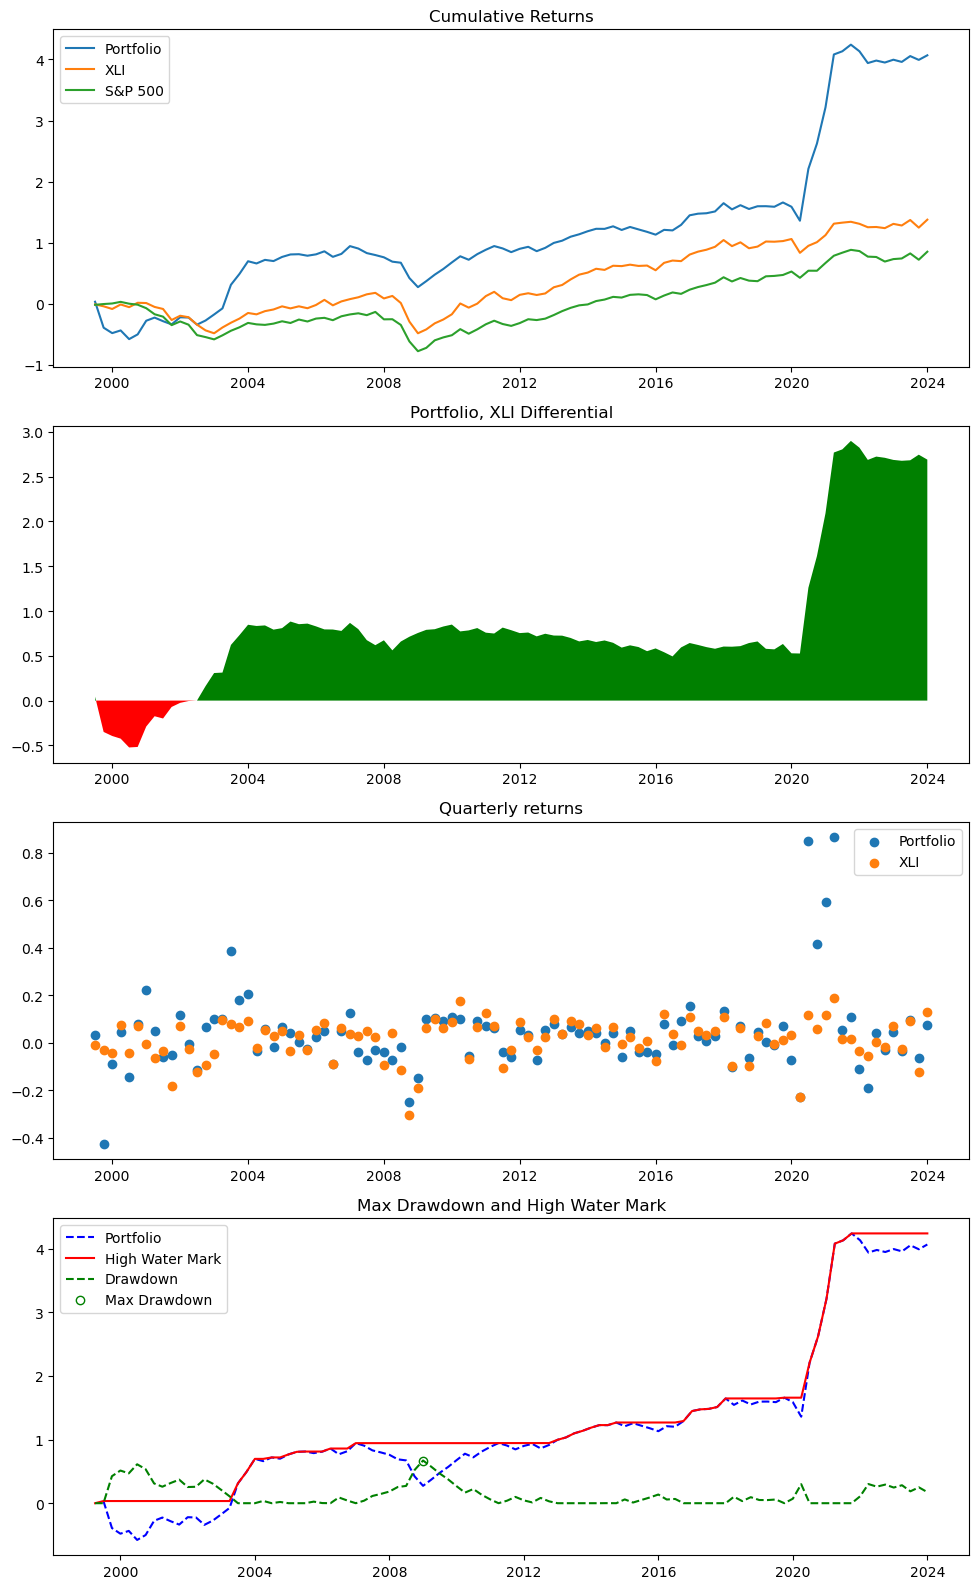

In [50]:
returns_df4UW =  calc_return(df4PEUW, log_returns_3)
metrics_4UW,HWMs_4UW, mdd_track_4UW = calc_metrics(returns_df4UW)
res = graph(returns_df4UW, bench_ret,HWMs_4UW, mdd_track_4UW)
plt.show()

In [51]:
returns_df4UW.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.176396 -0.038452  0.000000  0.106002  0.095837  0.108544   
1999-10-01 -0.258625  0.861311 -0.001000 -0.336210 -0.425182  0.019577   
2000-01-01 -0.354724  0.031681  1.865650 -0.176730 -0.203320 -0.061261   
2000-04-01 -0.112931 -0.292185  0.064464 -0.241529 -0.178215 -0.186673   

                 ETN       UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                                ...                        
1999-04-01       NaN       NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01  0.099851       NaN -0.351383  0.193960  ...   NaN -0.000000  NaN   
1999-10-01 -1.104935       NaN -0.282074  0.332349  ...   NaN -0.001000  NaN   
2000-01-01 -0.113289       NaN  0.326409  0.042217  ...   NaN  0.331176  NaN   
2000-04-01  0.438906 -0.334354 -0.111182 -0.208338  ...   NaN -0.020569  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC  Portfolio  
Date                                                                  
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN        NaN  
1999-07-01  0.322514  NaN   NaN -0.160990  0.089939   NaN   0.034101  
1999-10-01 -1.217881  NaN   NaN -0.135121  0.047493   NaN  -0.424674  
2000-01-01 -0.367591  NaN   NaN -0.192845  0.543687   NaN  -0.088814  
2000-04-01  0.075030  NaN   NaN -0.242698  0.587245   NaN   0.044082  

[5 rows x 78 columns]

In [52]:
metrics_4UW

CAT         GE        UNP       RTX       HON  \
Annualized Return     0.128589   0.353895   0.346267  0.088245  0.167504   
Annualized Vol        0.843825   1.501126   0.534561  0.447933  0.589431   
Sharpe Ratio          0.152389   0.235753   0.647760  0.197006  0.284179   
Skewness              0.031414   5.545238   2.982124 -0.760442  1.040893   
Excess Kurtosis       5.395844  38.961446  17.961403  5.350947  3.747462   
High Water Mark       3.182586  11.770730   8.896689  3.130956  4.951204   
Max Drawdown          3.979338   3.344248   0.775538  1.925757  1.704046   
XLI Beta              2.018042  -0.150626   1.333577  1.359305  1.623838   
Annualized XLI Alpha  0.016284   0.365852   0.275550  0.013490  0.078828   
S&P Beta              2.076752   0.954412   1.707422  1.331179  1.756546   
Annualized S&P Alpha  0.056999   0.324569   0.290907  0.043248  0.108644   

                            BA       ETN        UPS         DE       ADP  ...  \
Annualized Return     0.083589  0.231771   0.338825   0.387287  0.187673  ...   
Annualized Vol        0.610332  0.628713   0.901841   0.780502  0.346139  ...   
Sharpe Ratio          0.136956  0.368644   0.375704   0.496203  0.542190  ...   
Skewness             -0.116087 -0.468035   3.864412   2.458400  0.895457  ...   
Excess Kurtosis       3.005118  3.345596  17.734520   9.785155  4.684863  ...   
High Water Mark       3.577647  6.031272   9.140475  10.243735  4.813703  ...   
Max Drawdown          3.167736  1.890561   1.186884   0.851216  0.998196  ...   
XLI Beta              0.866310  2.120367  -0.475750   2.098738  0.422057  ...   
Annualized XLI Alpha  0.036222  0.116112   0.368724   0.274403  0.166081  ...   
S&P Beta              1.089615  2.107254  -0.669069   2.236807  0.379942  ...   
Annualized S&P Alpha  0.046872  0.161471   0.365312   0.314092  0.176471  ...   

                           ALLE       ITT        HII       AOS       AAL  \
Annualized Return     -0.041942  0.325825   0.188938  0.185361 -0.235339   
Annualized Vol         0.276369  0.763575   0.839863  0.728156  1.908520   
Sharpe Ratio          -0.151759  0.426710   0.224963  0.254563 -0.123310   
Skewness               1.586202  0.468215   3.267591 -0.369690  0.175256   
Excess Kurtosis       12.962571  5.544797  27.286077  4.720288  5.599661   
High Water Mark        0.024934  8.145624   4.723461  5.338280  1.930527   
Max Drawdown           1.410268  1.471276   3.058937  3.453468  9.713008   
XLI Beta               0.508316  2.014221   1.239323  1.119169  3.459755   
Annualized XLI Alpha  -0.070653  0.217023   0.121878  0.124951 -0.430255   
S&P Beta               0.527958  2.343029   1.083117  1.168378  3.613083   
Annualized S&P Alpha  -0.060565  0.248347   0.153510  0.146957 -0.362267   

                           PAYC       CHRW        RHI       GNRC  Portfolio  
Annualized Return     -0.542562   0.094207  -0.030438   0.395515   0.162686  
Annualized Vol         1.267344   0.580290   1.024566   0.977540   0.340451  
Sharpe Ratio          -0.428110   0.162345  -0.029708   0.404603   0.477854  
Skewness              -3.530359   4.586016  -1.070972   3.053185   2.381544  
Excess Kurtosis       16.679021  31.652814  11.923777  16.207516  10.064864  
High Water Mark        0.000000   2.950716   2.083070  10.373642   4.241343  
Max Drawdown          16.583010   1.420825   6.895711   2.166114   0.671257  
XLI Beta              -0.879717   0.378806   0.835010   1.023548   1.220200  
Annualized XLI Alpha  -0.499086   0.074078  -0.077214   0.342549   0.096424  
S&P Beta              -1.079534   0.599226   1.231220   1.106861   1.344196  
Annualized S&P Alpha  -0.510829   0.074502  -0.073188   0.361355   0.117992  

[11 rows x 78 columns]

In [53]:
df4PEOW = pd.DataFrame(index = df.index, columns = tickers[1:])

for i in tickers[1:]:
    df4PEOW[i] = np.where(df4[i] == df4['MEAN PE'], 0, 1)*np.where(df4[i] < df4['MEAN PE'],  0.5*df4['MEAN PE']/df4[i], -.5*(df4[i]/df4['MEAN PE']))*np.where(df4[i]==-1,0,1)
df4PEOW.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01  0.874889 -0.840779 -0.000000 -0.582703  0.553076  0.535638   
1999-07-01  1.979136  2.026258 -0.000000  1.563751  1.544205  1.810698   
1999-10-01  0.648427 -0.753178 -2.783509  0.610982  0.556363  0.667168   
2000-01-01  0.689542 -0.973442  0.881628 -0.797834 -0.614934  0.741755   
2000-04-01  1.477381 -0.557559  1.783960  0.743158  0.785050  1.364479   

                 ETN       UPS        DE       ADP  ...       ROL  ALLE  \
Date                                                ...                   
1999-04-01  0.727304 -0.000000  1.453679 -0.849344  ... -1.677823  -0.0   
1999-07-01  1.959891 -0.000000  2.458041  0.957407  ...  0.625143  -0.0   
1999-10-01  0.939069 -0.000000  0.919349 -0.777594  ... -1.125139  -0.0   
2000-01-01  1.426913 -1.815026  0.633289 -0.909437  ... -0.844015  -0.0   
2000-04-01  2.409477 -0.768902 -0.539010  0.545578  ...  0.514663  -0.0   

                 ITT  HII       AOS       AAL  PAYC      CHRW       RHI  GNRC  
Date                                                                           
1999-04-01 -0.000000 -0.0  1.186893  2.716541  -0.0 -0.508025  0.502974  -0.0  
1999-07-01 -0.000000 -0.0  3.175479  7.105060  -0.0  1.208847  2.211101  -0.0  
1999-10-01 -1.898402 -0.0  0.856116  2.612388  -0.0 -0.552724  0.796500  -0.0  
2000-01-01  0.933646 -0.0  1.190241  1.663450  -0.0 -0.624251  0.661103  -0.0  
2000-04-01  1.782438 -0.0  2.547582  3.036362  -0.0  0.779484  0.713950  -0.0  

[5 rows x 77 columns]

In [54]:
df4PEOW.loc['2020-07-01'].to_numpy()

array([  4.53911171,   5.41451183,   3.08456422,   4.67560004,
         3.6487685 ,   1.2211545 ,   3.52777967,   2.69402632,
         4.27964238,   2.37441396,   3.66198868,   3.60967455,
         2.67030086,   2.26193706,   3.374654  ,   2.62521786,
         3.56511067,   2.03021535,   4.80908267,   3.42226481,
         3.18166487,  -1.66277686,   4.93429882,   1.47584649,
         3.31198976,   4.63627924,   6.20701458,   2.32435924,
         2.70846505,   2.82320915,   1.96763571,   2.57614836,
         2.76906541,   1.82988933,   3.03668165,   2.15963435,
         4.79008945,   1.043941  ,   2.49763313,   0.86262493,
         1.73661319,   0.78329285,   3.35412237,   1.85792073,
         1.40701931,  11.61734338,   2.59156122,   1.7010528 ,
         4.86307397,   4.32234729,   3.20351466,   6.01612425,
         3.56092381, -29.18743542,   2.63205436,   0.89390525,
        -0.        ,   2.34866508,   2.09112181,   5.45346515,
         2.80233514,   2.66092727,   2.20438141,   5.13

In [55]:
log_returns_3['PAYC'].cumsum().to_numpy()

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.32849665, 0.71671237, 0.90555971,
       0.91767701, 1.08962037, 0.85720606, 1.09363589, 1.30454432,
       1.39523898, 1.28179633, 1.5445037 , 1.69314864, 1.84971

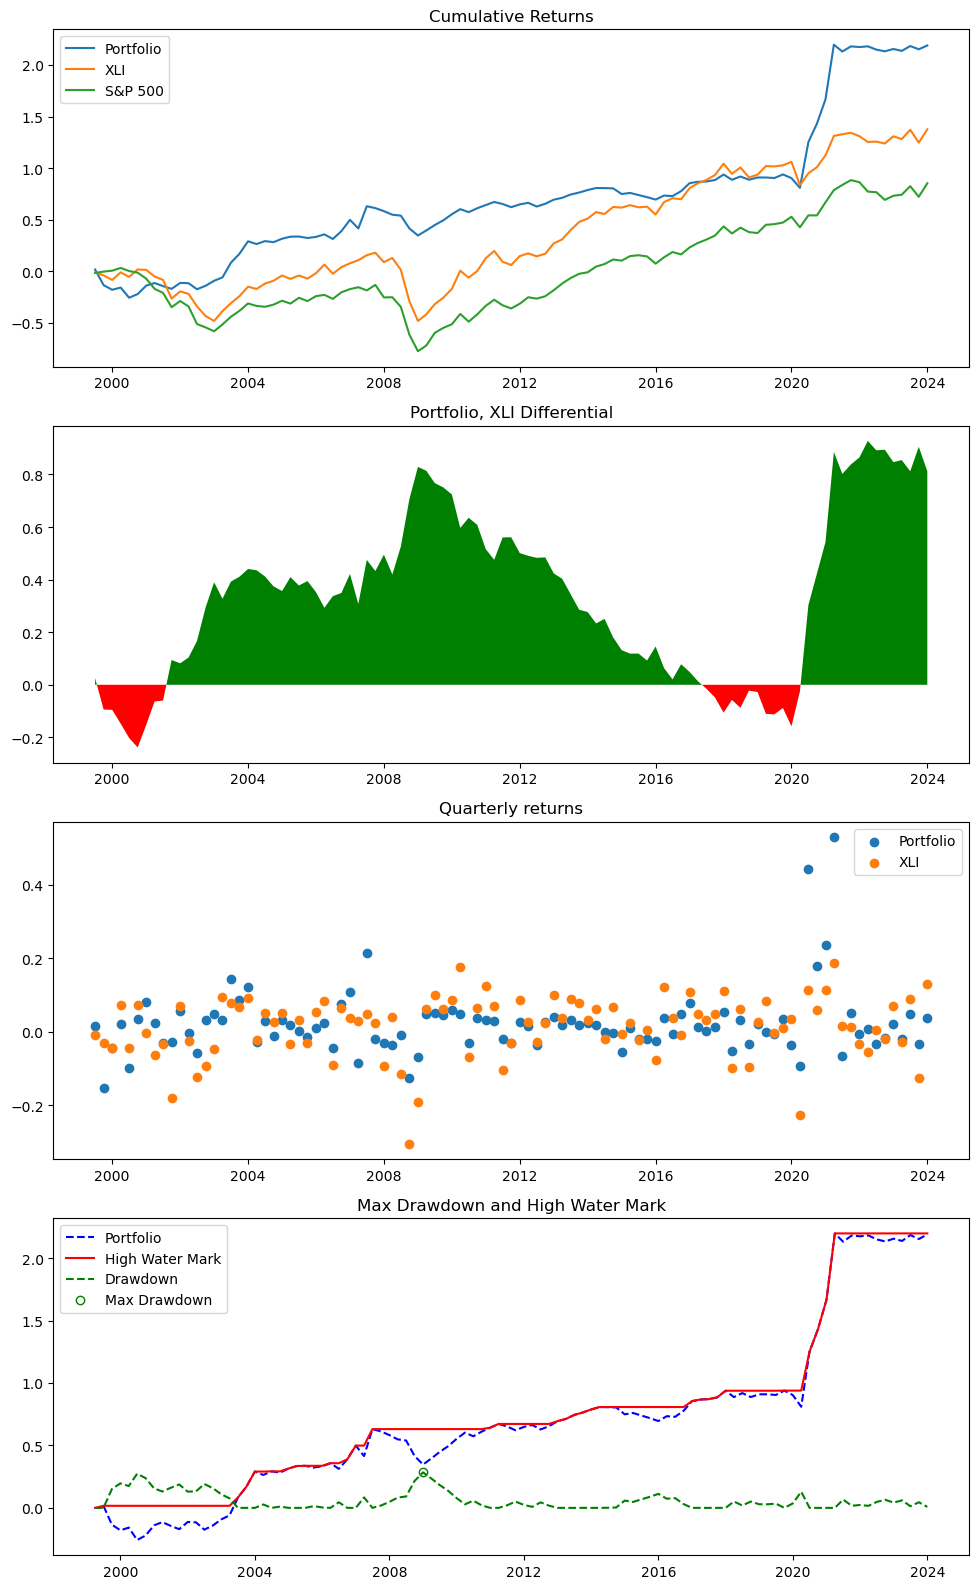

In [56]:
returns_df4OW =  calc_return(df4PEOW, log_returns_3)
metrics_4OW,HWMs_4OW, mdd_track_4OW = calc_metrics(returns_df4OW)
res = graph(returns_df4OW, bench_ret,HWMs_4OW, mdd_track_4OW)
plt.show()

In [57]:
returns_df4OW.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.088698 -0.019726  0.000000  0.052501  0.047418  0.053772   
1999-10-01 -0.129812  0.430155 -0.001000 -0.168605 -0.213091  0.009288   
2000-01-01 -0.177862  0.015341  0.932325 -0.088865 -0.102160 -0.031130   
2000-04-01 -0.056965 -0.146592  0.031732 -0.121265 -0.089608 -0.093836   

                 ETN       UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                                ...                        
1999-04-01       NaN       NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01  0.049426       NaN -0.176192  0.096480  ...   NaN -0.000000  NaN   
1999-10-01 -0.552967       NaN -0.141537  0.165674  ...   NaN -0.001000  NaN   
2000-01-01 -0.057145       NaN  0.162704  0.020608  ...   NaN  0.165088  NaN   
2000-04-01  0.218953 -0.167677 -0.056091 -0.104669  ...   NaN -0.010784  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC  Portfolio  
Date                                                                  
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN        NaN  
1999-07-01  0.160757  NaN   NaN -0.080995  0.044469   NaN   0.016577  
1999-10-01 -0.609441  NaN   NaN -0.068061  0.023247   NaN  -0.151364  
2000-01-01 -0.184295  NaN   NaN -0.096923  0.271344   NaN  -0.044907  
2000-04-01  0.037015  NaN   NaN -0.121849  0.293123   NaN   0.021541  

[5 rows x 78 columns]

In [58]:
metrics_4OW

CAT         GE        UNP       RTX       HON  \
Annualized Return      0.025060   0.240907   0.171174  0.042143  0.081772   
Annualized Vol         0.552346   1.021763   0.267274  0.223965  0.294714   
Sharpe Ratio           0.045371   0.235776   0.640442  0.188166  0.277462   
Skewness              -3.068449   7.209046   2.982133 -0.760442  1.040893   
Excess Kurtosis       24.530408  59.637347  17.961979  5.350947  3.747462   
High Water Mark        0.921058   7.488860   4.403345  1.523978  2.431102   
Max Drawdown           3.034514   1.676124   0.388769  0.964378  0.858023   
XLI Beta               0.878638  -0.623453   0.666772  0.679653  0.811919   
Annualized XLI Alpha  -0.023837   0.278036   0.135796  0.004745  0.037414   
S&P Beta               0.887390   0.105554   0.853684  0.665589  0.878273   
Annualized S&P Alpha  -0.005530   0.239702   0.143474  0.019624  0.052322   

                            BA       ETN        UPS        DE       ADP  ...  \
Annualized Return     0.039814  0.113906   0.190944  0.191664  0.091856  ...   
Annualized Vol        0.305165  0.314354   0.508725  0.390248  0.173067  ...   
Sharpe Ratio          0.130468  0.362348   0.375338  0.491133  0.530758  ...   
Skewness             -0.116087 -0.468035   4.147553  2.458400  0.895457  ...   
Excess Kurtosis       3.005118  3.345596  19.269184  9.785155  4.684863  ...   
High Water Mark       1.744824  2.970636   5.113021  5.075868  2.357851  ...   
Max Drawdown          1.600868  0.947780   0.607942  0.426608  0.503098  ...   
XLI Beta              0.433155  1.060184  -0.432859  1.049369  0.211029  ...   
Annualized XLI Alpha  0.016111  0.056056   0.216962  0.135201  0.081040  ...   
S&P Beta              0.544807  1.053627  -0.570107  1.118403  0.189971  ...   
Annualized S&P Alpha  0.021436  0.078735   0.212525  0.155046  0.086236  ...   

                           ALLE       ITT        HII       AOS        AAL  \
Annualized Return     -0.021771  0.160952   0.098851  0.090701  -0.050724   
Annualized Vol         0.138232  0.381783   0.448755  0.364077   2.496781   
Sharpe Ratio          -0.157495  0.421581   0.220278  0.249125  -0.020316   
Skewness               1.571749  0.468148   3.541442 -0.369690   1.881595   
Excess Kurtosis       12.913874  5.544940  28.668528  4.720288  21.613976   
High Water Mark        0.000000  4.023812   2.471266  2.623640   8.263294   
Max Drawdown           0.712167  0.739638   1.545216  1.729234  10.480395   
XLI Beta               0.253930  1.007094   0.655430  0.559585   3.359943   
Annualized XLI Alpha  -0.036122  0.106533   0.063374  0.060476  -0.238220   
S&P Beta               0.263427  1.171488   0.570214  0.584189   3.564993   
Annualized S&P Alpha  -0.031072  0.122195   0.080193  0.071479  -0.174129   

                           PAYC       CHRW        RHI       GNRC  Portfolio  
Annualized Return     -0.455741   0.045124  -0.244166   0.196718   0.087571  
Annualized Vol         1.130380   0.290144   1.157828   0.488672   0.178644  
Sharpe Ratio          -0.403175   0.155521  -0.210883   0.402556   0.490196  
Skewness              -5.190158   4.586016  -6.424763   3.052205   3.006617  
Excess Kurtosis       29.094689  31.652814  51.327390  16.210839  13.619223  
High Water Mark        0.000000   1.428858   1.034035   5.161321   2.197192  
Max Drawdown          12.894992   0.718413   9.255402   1.084057   0.283907  
XLI Beta              -0.528522   0.189403  -0.037326   0.511385   0.611882  
Annualized XLI Alpha  -0.430931   0.035039  -0.244555   0.170246   0.054404  
S&P Beta              -0.654386   0.299613  -0.013056   0.552642   0.628144  
Annualized S&P Alpha  -0.437786   0.035251  -0.246182   0.179654   0.066802  

[11 rows x 78 columns]

# Momentum Strategy

### Returns are probably skewed by smaller companies can have bigger returns so CAT,GE are perhaps more likely to be shorted

In [59]:
df1mom = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

log_returns_3_filled = log_returns_3.replace(np.nan, 0)
for i in tickers[1:]:
    df1mom[i] =  np.where(log_returns_3_filled[i] == 0, 0, 1)*np.where(log_returns_3_filled[i] > log_returns_3_filled['Mean'], 1, -1)
    
df1mom.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-07-01   -1   1   -1   -1    1   1    1    0  -1   -1  ...    1     0   
1999-10-01    1   1    1    1   -1   1   -1    0   1    1  ...    1     0   
2000-01-01   -1   1   -1   -1   -1   1    1    0   1    1  ...    1     0   
2000-04-01   -1   1   -1    1    1  -1    1    1  -1    1  ...   -1     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    0    0     0     0    0     0  
1999-07-01    1    0    1    0     0     1    1     0  
1999-10-01    1    0   -1    0     0     1    1     0  
2000-01-01   -1    0   -1    0     0     1    1     0  
2000-04-01   -1    0   -1    0     0     1    1     0  

[5 rows x 77 columns]

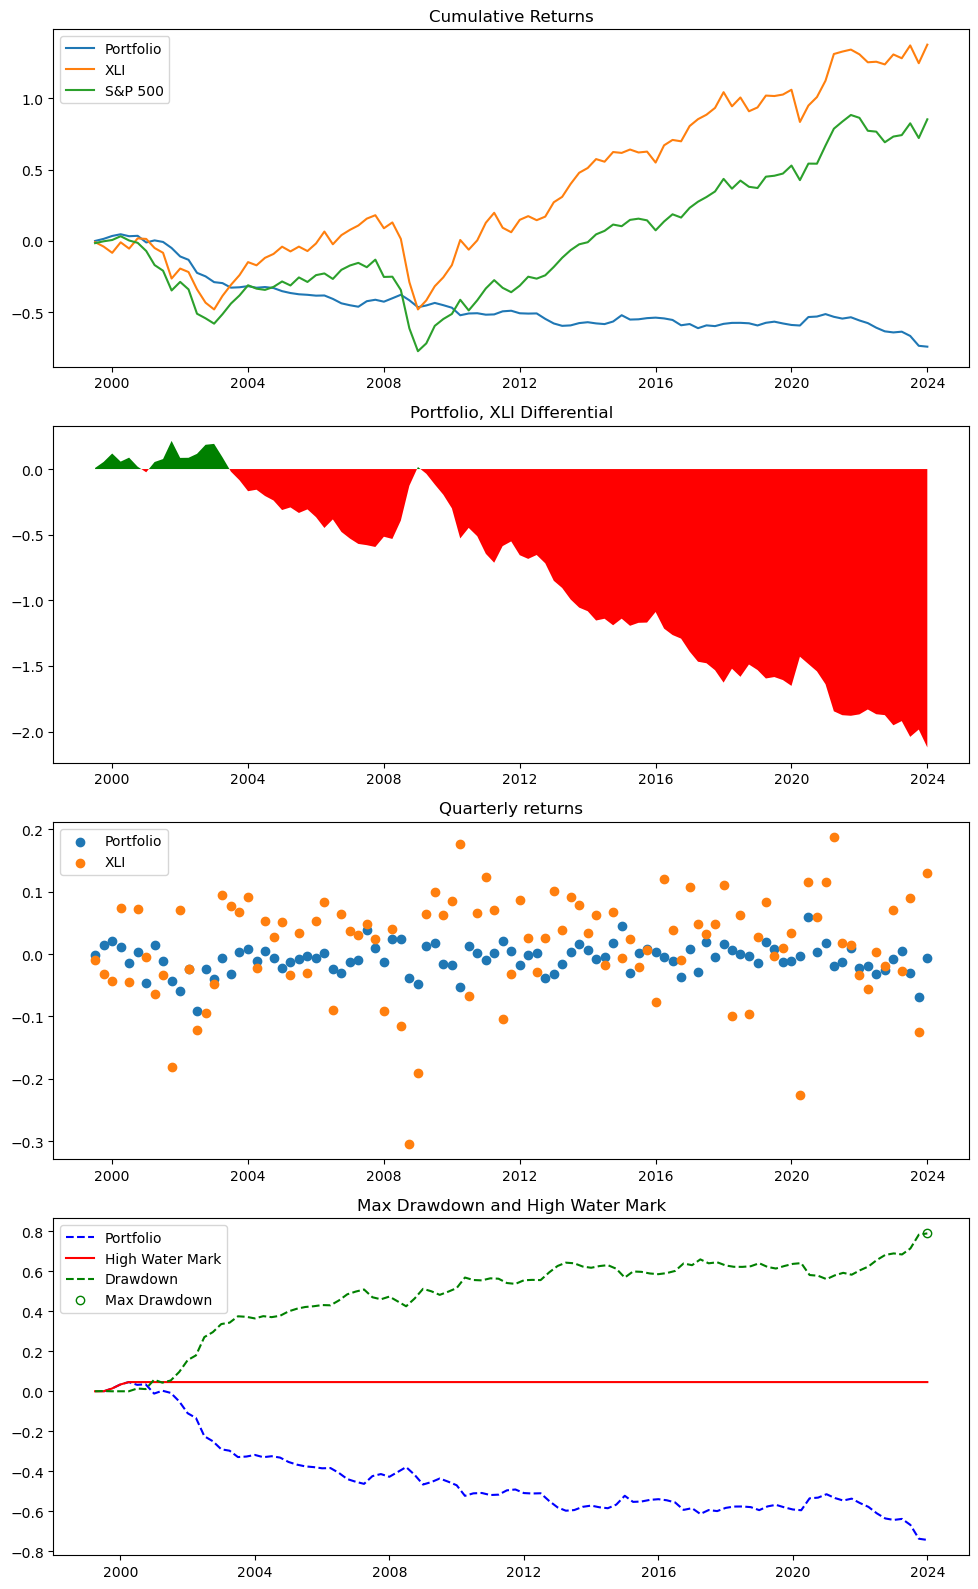

In [60]:
returns_df5 =  calc_return(df1mom, log_returns_3)
metrics_5, HWMs_5, mdd_track_5  = calc_metrics(returns_df5)
res = graph(returns_df5, bench_ret, HWMs_5, mdd_track_5)
plt.show()

In [61]:
returns_df5.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.001000 -0.001000 -0.001000 -0.001000 -0.001000 -0.001000   
1999-10-01  0.064085  0.212784 -0.018813  0.106181 -0.138346  0.005682   
2000-01-01 -0.273755 -0.021696 -0.336305 -0.144810  0.181824 -0.045162   
2000-04-01  0.081163  0.149564 -0.037127 -0.151739 -0.145093 -0.126158   

                 ETN    UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                             ...                        
1999-04-01       NaN    NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01 -0.001000    NaN -0.001000 -0.001000  ...   NaN -0.001000  NaN   
1999-10-01 -0.282632    NaN  0.056174 -0.175089  ...   NaN -0.097285  NaN   
2000-01-01  0.058788    NaN  0.178065 -0.027789  ...   NaN -0.088488  NaN   
2000-04-01  0.154146 -0.001 -0.087992  0.113993  ...   NaN  0.010480  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC  Portfolio  
Date                                                                  
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN        NaN  
1999-07-01 -0.001000  NaN   NaN -0.001000 -0.001000   NaN  -0.001000  
1999-10-01 -0.192606  NaN   NaN -0.055475  0.010966   NaN   0.014646  
2000-01-01  0.214101  NaN   NaN  0.173545  0.341925   NaN   0.020361  
2000-04-01 -0.031939  NaN   NaN  0.193590  0.444897   NaN   0.012009  

[5 rows x 78 columns]

In [62]:
metrics_5

CAT        GE       UNP       RTX       HON  \
Annualized Return     0.046001  0.068266 -0.011446 -0.066193 -0.089636   
Annualized Vol        0.298630  0.290748  0.223871  0.208739  0.263620   
Sharpe Ratio          0.154039  0.234794 -0.051127 -0.317110 -0.340020   
Skewness              0.395086 -0.267927 -0.670754 -0.143615 -0.190971   
Excess Kurtosis       0.913852  2.936945  1.240355  0.977271  3.752123   
High Water Mark       1.955167  1.706648  0.360132  0.105181  0.042477   
Max Drawdown          0.816647  1.068208  0.800122  2.167461  2.929216   
XLI Beta             -0.121359 -0.125427  0.319100 -0.074796 -0.196264   
Annualized XLI Alpha  0.052755  0.075936 -0.029320 -0.062699 -0.079619   
S&P Beta             -0.157772 -0.172531  0.319502 -0.161930 -0.145629   
Annualized S&P Alpha  0.051440  0.074903 -0.022575 -0.061280 -0.085521   

                            BA       ETN       UPS        DE       ADP  ...  \
Annualized Return    -0.081981  0.028087 -0.058453  0.050789 -0.091754  ...   
Annualized Vol        0.343758  0.245258  0.192590  0.272293  0.180558  ...   
Sharpe Ratio         -0.238486  0.114519 -0.303511  0.186523 -0.508168  ...   
Skewness              1.368278  0.263655  0.970646  0.735892  0.140948  ...   
Excess Kurtosis       5.346713  0.618836  4.073063  1.785453  0.969732  ...   
High Water Mark       0.270977  0.702169  0.038285  1.779355  0.031003  ...   
Max Drawdown          2.320513  1.155562  1.781901  1.461168  2.435853  ...   
XLI Beta             -0.243816  0.109397 -0.314791 -0.011372  0.054487  ...   
Annualized XLI Alpha -0.069241  0.022282 -0.041525  0.051935 -0.095713  ...   
S&P Beta             -0.240250  0.045582 -0.264206 -0.075214  0.015465  ...   
Annualized S&P Alpha -0.074528  0.026799 -0.049936  0.053895 -0.093214  ...   

                          ALLE       ITT       HII       AOS       AAL  \
Annualized Return    -0.023584 -0.122220 -0.028232  0.021677  0.074867   
Annualized Vol        0.126638  0.254869  0.183317  0.282296  0.463934   
Sharpe Ratio         -0.186230 -0.479540 -0.154005  0.076786  0.161375   
Skewness             -1.257186 -0.071208 -0.538787  0.125710  0.118946   
Excess Kurtosis       4.812314  0.323489  2.319099 -0.060897  2.223938   
High Water Mark       0.165972  0.000000  0.559077  1.142625  3.308305   
Max Drawdown          0.841113  3.302843  1.421055  1.373514  1.436622   
XLI Beta             -0.062472  0.345452  0.015637  0.305140  0.114941   
Annualized XLI Alpha -0.020345 -0.142679 -0.029387  0.004914  0.069227   
S&P Beta             -0.119841  0.413123 -0.063840  0.503585  0.227212   
Annualized S&P Alpha -0.019691 -0.137695 -0.026316  0.004536  0.067791   

                          PAYC      CHRW       RHI      GNRC  Portfolio  
Annualized Return    -0.022894  0.002521  0.044588 -0.125161  -0.029736  
Annualized Vol        0.266366  0.212214  0.293519  0.389185   0.046503  
Sharpe Ratio         -0.085948  0.011882  0.151910 -0.321598  -0.639447  
Skewness             -0.637359  0.040653  0.189958 -1.462296  -0.502673  
Excess Kurtosis       3.132557  0.120164  0.259697  4.254123   1.444143  
High Water Mark       0.804692  0.540587  1.663942  0.000000   0.046016  
Max Drawdown          1.640737  1.182504  1.777173  3.129023   0.789418  
XLI Beta              0.237412  0.123195 -0.008177  0.170528   0.064911  
Annualized XLI Alpha -0.036337 -0.004309  0.045494 -0.135915  -0.033649  
S&P Beta              0.279056  0.219165  0.010838  0.223669   0.100099  
Annualized S&P Alpha -0.032744 -0.005008  0.044665 -0.134135  -0.033487  

[11 rows x 78 columns]

In [63]:
df2mom = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

log_returns_3_filled = log_returns_3.replace(np.nan, 0)
for i in tickers[1:]:
    df2mom[i] =  np.where(log_returns_3_filled[i] == 0, 0, 1)*np.where(log_returns_3_filled[i] > bench_ret, 1, -1)
    
df2mom.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-07-01   -1   1   -1   -1    1   1    1    0  -1   -1  ...    1     0   
1999-10-01   -1   1    1   -1   -1   1   -1    0  -1    1  ...   -1     0   
2000-01-01   -1   1   -1   -1   -1  -1   -1    0   1    1  ...    1     0   
2000-04-01   -1   1   -1    1    1  -1    1    1  -1    1  ...   -1     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    0    0     0     0    0     0  
1999-07-01    1    0    1    0     0     1    1     0  
1999-10-01   -1    0   -1    0     0    -1    1     0  
2000-01-01   -1    0   -1    0     0     1    1     0  
2000-04-01   -1    0   -1    0     0     1    1     0  

[5 rows x 77 columns]

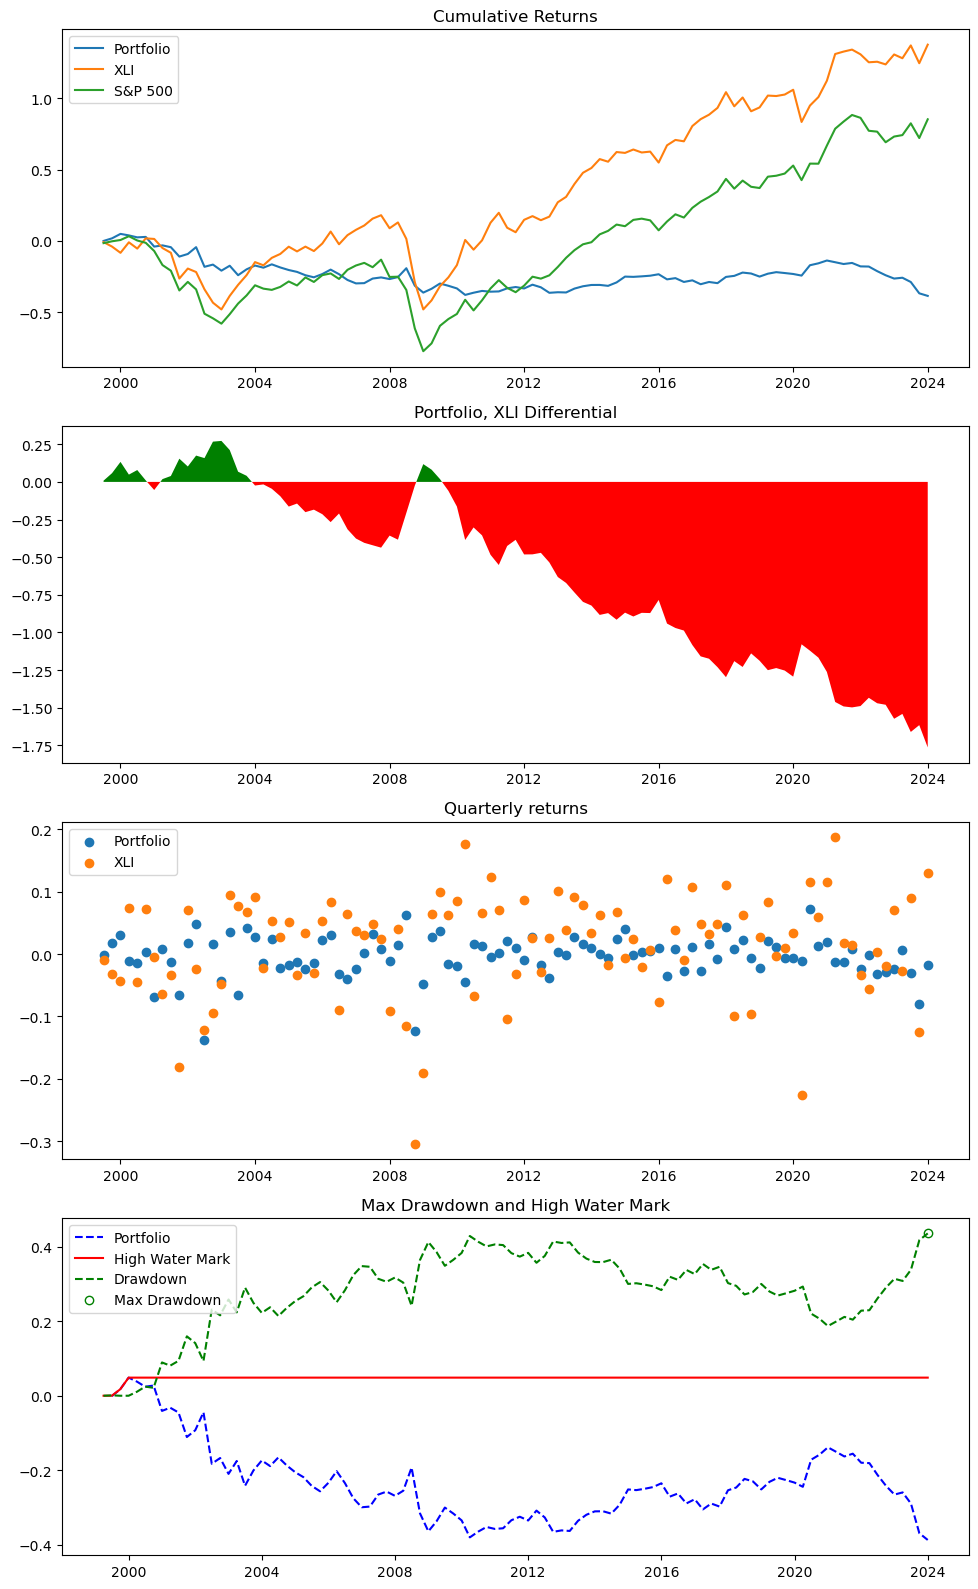

In [64]:
returns_df6 =  calc_return(df2mom, log_returns_3)
metrics_6, HWMs_6, mdd_track_6 = calc_metrics(returns_df6)
res = graph(returns_df6, bench_ret, HWMs_6, mdd_track_6)
plt.show()

In [65]:
returns_df6.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.001000 -0.001000 -0.001000 -0.001000 -0.001000 -0.001000   
1999-10-01  0.065085  0.212784 -0.018813  0.107181 -0.138346  0.005682   
2000-01-01  0.272755 -0.021696 -0.336305  0.143810  0.181824 -0.046162   
2000-04-01  0.081163  0.149564 -0.037127 -0.151739 -0.145093  0.125158   

                 ETN    UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                             ...                        
1999-04-01       NaN    NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01 -0.001000    NaN -0.001000 -0.001000  ...   NaN -0.001000  NaN   
1999-10-01 -0.282632    NaN  0.057174 -0.175089  ...   NaN -0.098285  NaN   
2000-01-01  0.059788    NaN -0.179065 -0.027789  ...   NaN  0.087488  NaN   
2000-04-01 -0.155146 -0.001 -0.087992  0.113993  ...   NaN  0.010480  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC  Portfolio  
Date                                                                  
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN        NaN  
1999-07-01 -0.001000  NaN   NaN -0.001000 -0.001000   NaN  -0.001000  
1999-10-01 -0.192606  NaN   NaN -0.056475  0.010966   NaN   0.018369  
2000-01-01  0.214101  NaN   NaN -0.174545  0.341925   NaN   0.031210  
2000-04-01 -0.031939  NaN   NaN  0.193590  0.444897   NaN  -0.010671  

[5 rows x 78 columns]

In [66]:
metrics_6

CAT        GE       UNP       RTX       HON  \
Annualized Return     0.112154  0.088638 -0.018876 -0.035127 -0.004075   
Annualized Vol        0.294087  0.289303  0.223723  0.210642  0.267385   
Sharpe Ratio          0.381365  0.306383 -0.084370 -0.166762 -0.015239   
Skewness              0.326324 -0.333278 -0.475488 -0.224873 -0.321023   
Excess Kurtosis       0.854569  3.075316  1.230380  0.952052  3.653652   
High Water Mark       3.592470  2.215940  0.174387  0.249991  0.042477   
Max Drawdown          0.816647  1.027173  0.800122  1.578161  1.776955   
XLI Beta             -0.148584 -0.107472  0.351290 -0.019047 -0.259077   
Annualized XLI Alpha  0.120423  0.095514 -0.038616 -0.034422  0.010302   
S&P Beta             -0.127070 -0.203111  0.366190 -0.082548 -0.153585   
Annualized S&P Alpha  0.116535  0.096535 -0.031690 -0.032636  0.001178   

                            BA       ETN       UPS        DE       ADP  ...  \
Annualized Return     0.015610  0.030423 -0.047059  0.046625 -0.106435  ...   
Annualized Vol        0.346011  0.245317  0.193412  0.272489  0.178635  ...   
Sharpe Ratio          0.045114  0.124016 -0.243308  0.171106 -0.595826  ...   
Skewness              1.312601  0.117952  0.875700  0.748273  0.216586  ...   
Excess Kurtosis       4.444792  0.647544  3.847520  1.797776  1.123912  ...   
High Water Mark       1.511245  0.760577  0.000000  1.675247  0.031003  ...   
Max Drawdown          1.233778  0.960778  1.458753  1.353042  2.691882  ...   
XLI Beta             -0.286871  0.068511 -0.288081  0.110943  0.028088  ...   
Annualized XLI Alpha  0.031732  0.026918 -0.031502  0.040921 -0.109073  ...   
S&P Beta             -0.358983  0.004434 -0.251147  0.027697 -0.029858  ...   
Annualized S&P Alpha  0.028143  0.030578 -0.038876  0.046141 -0.106481  ...   

                          ALLE       ITT       HII       AOS       AAL  \
Annualized Return    -0.022719 -0.112577 -0.014756 -0.005042  0.087659   
Annualized Vol        0.126694  0.256017  0.183716  0.282574  0.463360   
Sharpe Ratio         -0.179320 -0.439727 -0.080322 -0.017843  0.189182   
Skewness             -1.255348  0.019665 -0.495797  0.236753  0.084437   
Excess Kurtosis       4.819466  0.397966  2.382328 -0.035335  2.242057   
High Water Mark       0.165972  0.295741  0.716538  1.025774  3.628109   
Max Drawdown          0.883444  3.357527  1.241636  1.373514  1.436622   
XLI Beta             -0.077071  0.319271  0.029868  0.267231  0.155893   
Annualized XLI Alpha -0.018659 -0.131482 -0.016568 -0.019964  0.079869   
S&P Beta             -0.159539  0.355236 -0.030568  0.464311  0.261428   
Annualized S&P Alpha -0.017449 -0.125960 -0.013852 -0.021099  0.079533   

                          PAYC      CHRW       RHI      GNRC  Portfolio  
Annualized Return    -0.022894 -0.009779 -0.005023 -0.111361  -0.015473  
Annualized Vol        0.266366  0.212223  0.294405  0.390215   0.065684  
Sharpe Ratio         -0.085948 -0.046081 -0.017061 -0.285384  -0.235574  
Skewness             -0.637359  0.071776  0.151453 -1.488817  -1.146682  
Excess Kurtosis       3.132557  0.125978  0.319436  4.290682   3.188206  
High Water Mark       0.804692  0.191496  1.040359  0.000000   0.048579  
Max Drawdown          1.640737  0.972638  2.393870  2.784030   0.435415  
XLI Beta              0.237412  0.207443  0.119442  0.195276   0.143825  
Annualized XLI Alpha -0.036337 -0.021423 -0.011720 -0.123353  -0.023634  
S&P Beta              0.279056  0.317622  0.222020  0.259247   0.206116  
Annualized S&P Alpha -0.032744 -0.020827 -0.012727 -0.121423  -0.022735  

[11 rows x 78 columns]

In [67]:
df3mom = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

log_returns_3_filled = log_returns_3.replace(np.nan, 0)
for i in tickers[1:]:
    df3mom[i] =  np.where(log_returns_3_filled[i] == 0, 0, 1)*np.where(log_returns_3_filled[i] > 0, 1, -1)
    
df3mom.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-07-01   -1   1   -1   -1    1   1    1    0  -1   -1  ...    1     0   
1999-10-01   -1   1    1   -1   -1   1   -1    0  -1    1  ...   -1     0   
2000-01-01   -1  -1   -1   -1   -1  -1   -1    0   1   -1  ...   -1     0   
2000-04-01   -1   1    1    1    1  -1    1    1  -1    1  ...   -1     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    0    0     0     0    0     0  
1999-07-01    1    0    1    0     0     1    1     0  
1999-10-01   -1    0   -1    0     0    -1    1     0  
2000-01-01   -1    0   -1    0     0     1    1     0  
2000-04-01   -1    0    1    0     0     1    1     0  

[5 rows x 77 columns]

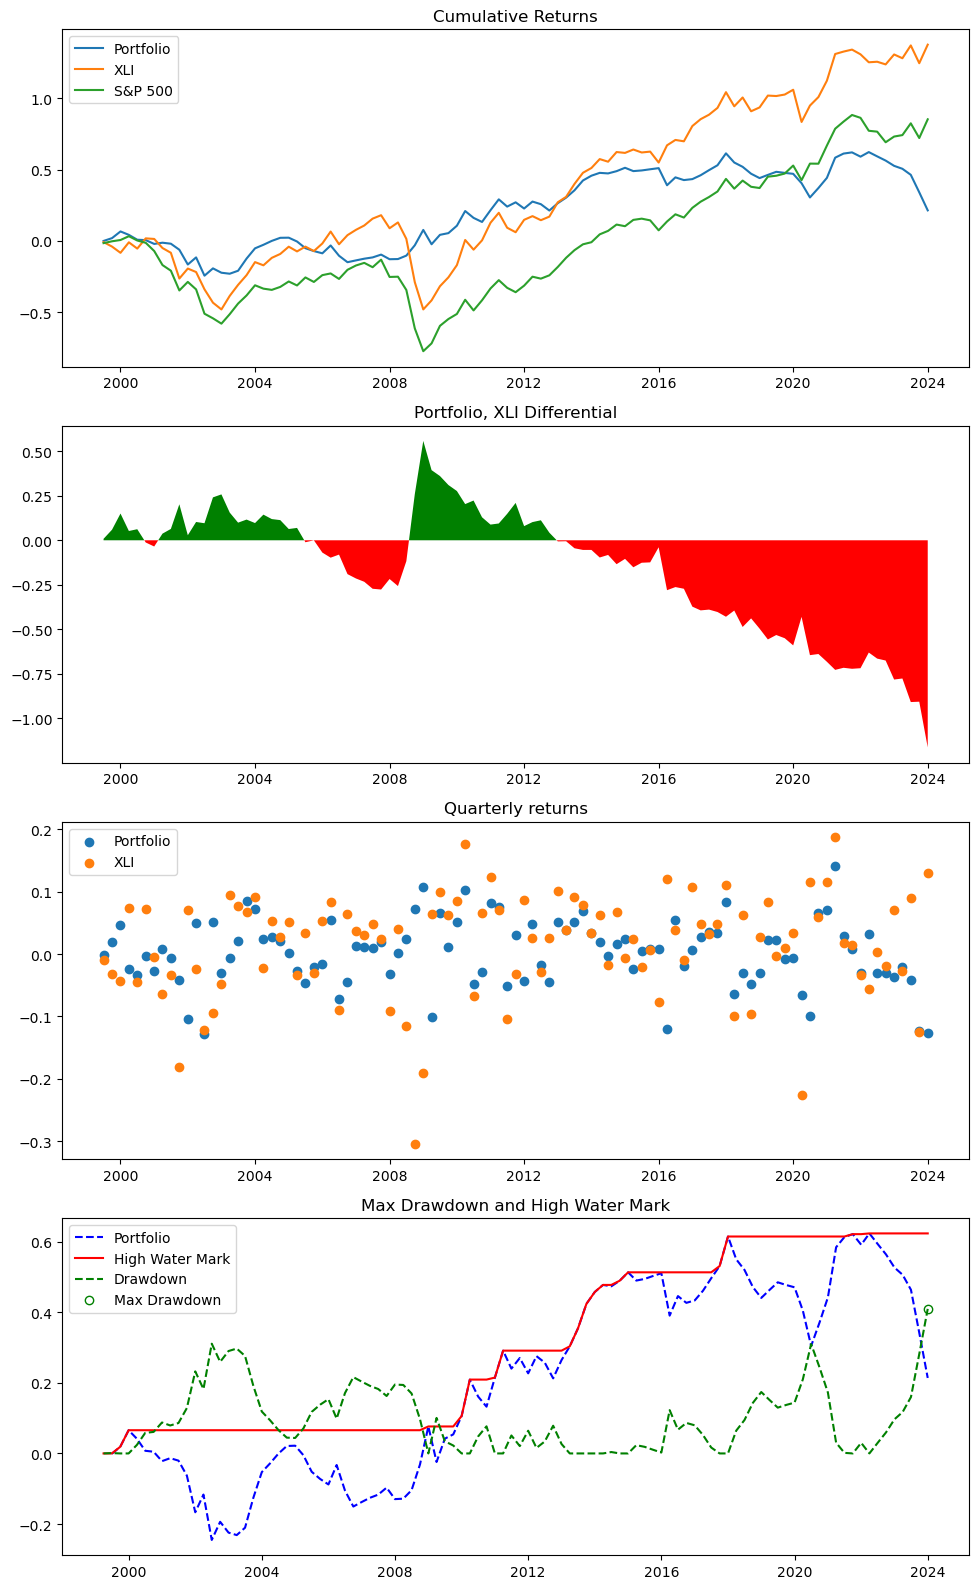

In [68]:
returns_df7 =  calc_return(df3mom, log_returns_3)
metrics_7, HWMs_7, mdd_track_7 = calc_metrics(returns_df7)
res = graph(returns_df7, bench_ret, HWMs_7, mdd_track_7)
plt.show()

In [69]:
returns_df7.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.001000 -0.001000 -0.001000 -0.001000 -0.001000 -0.001000   
1999-10-01  0.065085  0.212784 -0.018813  0.107181 -0.138346  0.005682   
2000-01-01  0.272755 -0.022696 -0.336305  0.143810  0.181824 -0.046162   
2000-04-01  0.081163 -0.150564 -0.038127 -0.151739 -0.145093  0.125158   

                 ETN    UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                             ...                        
1999-04-01       NaN    NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01 -0.001000    NaN -0.001000 -0.001000  ...   NaN -0.001000  NaN   
1999-10-01 -0.282632    NaN  0.057174 -0.175089  ...   NaN -0.098285  NaN   
2000-01-01  0.059788    NaN -0.179065 -0.028789  ...   NaN  0.087488  NaN   
2000-04-01 -0.155146 -0.001 -0.087992 -0.114993  ...   NaN  0.010480  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC  Portfolio  
Date                                                                  
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN        NaN  
1999-07-01 -0.001000  NaN   NaN -0.001000 -0.001000   NaN  -0.001000  
1999-10-01 -0.192606  NaN   NaN -0.056475  0.010966   NaN   0.019801  
2000-01-01  0.214101  NaN   NaN -0.174545  0.341925   NaN   0.046952  
2000-04-01 -0.032939  NaN   NaN  0.193590  0.444897   NaN  -0.024190  

[5 rows x 78 columns]

In [70]:
metrics_7

CAT        GE       UNP       RTX       HON  \
Annualized Return     0.078458  0.047342 -0.032472  0.026772 -0.034469   
Annualized Vol        0.296965  0.291977  0.223666  0.211078  0.267098   
Sharpe Ratio          0.264199  0.162142 -0.145179  0.126836 -0.129051   
Skewness              0.360521 -0.170080  0.268579 -0.470574 -0.178026   
Excess Kurtosis       0.865494  2.811266  1.366757  1.132675  3.623673   
High Water Mark       2.851300  1.433215  0.024368  1.242746  0.042477   
Max Drawdown          0.909465  1.263406  1.015651  1.068435  1.961482   
XLI Beta             -0.135696  0.109264  0.060731 -0.005734  0.030281   
Annualized XLI Alpha  0.086010  0.041739 -0.036179  0.027362 -0.036503   
S&P Beta             -0.207067  0.078476 -0.011925 -0.057917  0.022411   
Annualized S&P Alpha  0.085596  0.045115 -0.032388  0.029039 -0.035590   

                            BA       ETN       UPS        DE       ADP  ...  \
Annualized Return     0.084282  0.068690 -0.046160 -0.000674 -0.040478  ...   
Annualized Vol        0.343532  0.243388  0.193812  0.273733  0.185549  ...   
Sharpe Ratio          0.245340  0.282224 -0.238170 -0.002463 -0.218154  ...   
Skewness              1.189641  0.149350 -0.949423  0.891122  0.105367  ...   
Excess Kurtosis       4.107261  0.609789  2.953223  2.015107  0.761084  ...   
High Water Mark       3.229046  1.717249  0.547175  0.812997  0.000000  ...   
Max Drawdown          1.121994  0.746309  1.701181  1.481218  1.084477  ...   
XLI Beta             -0.375829  0.216732 -0.157101  0.091574  0.042417  ...   
Annualized XLI Alpha  0.106049  0.057322 -0.037884 -0.005777 -0.043248  ...   
S&P Beta             -0.434740  0.122105 -0.249309 -0.020065  0.026883  ...   
Annualized S&P Alpha  0.100120  0.065175 -0.038032  0.000011 -0.041814  ...   

                          ALLE       ITT       HII       AOS       AAL  \
Annualized Return    -0.008586 -0.045437  0.025313  0.032414  0.191561   
Annualized Vol        0.127227  0.261218  0.183404  0.282247  0.455297   
Sharpe Ratio         -0.067483 -0.173943  0.138016  0.114842  0.420738   
Skewness             -0.580440 -0.102958  0.014172 -0.397814  0.174997   
Excess Kurtosis       5.076288  0.306355  2.459633  0.050792  2.295345   
High Water Mark       0.413954  0.583187  1.030717  1.645047  6.174395   
Max Drawdown          0.628596  2.054562  0.515440  0.890447  1.385380   
XLI Beta              0.124260  0.422889  0.150132  0.306186  0.354571   
Annualized XLI Alpha -0.015588 -0.069430  0.017213  0.015702  0.173763   
S&P Beta              0.086128  0.423880  0.074801  0.427389  0.490802   
Annualized S&P Alpha -0.011641 -0.060508  0.022990  0.018008  0.176577   

                          PAYC      CHRW       RHI      GNRC  Portfolio  
Annualized Return     0.011593 -0.049774  0.044731 -0.112851   0.008549  
Annualized Vol        0.266552  0.211169  0.293638  0.390169   0.105823  
Sharpe Ratio          0.043491 -0.235705  0.152333 -0.289235   0.080785  
Skewness             -0.621483 -0.231036  0.152726 -1.530574  -0.258414  
Excess Kurtosis       3.286661  0.006141  0.266896  4.255882   0.196631  
High Water Mark       1.238219  0.191496  1.657604  0.324327   0.622972  
Max Drawdown          1.212105  1.622213  2.253549  3.145594   0.409252  
XLI Beta              0.180449  0.028678  0.234099  0.125310   0.139100  
Annualized XLI Alpha  0.001668 -0.051872  0.032155 -0.120964   0.000894  
S&P Beta              0.172440 -0.003506  0.200941  0.119807   0.135362  
Annualized S&P Alpha  0.005765 -0.050155  0.038256 -0.118121   0.003969  

[11 rows x 78 columns]

In [71]:
df3Wmom = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

log_returns_3_filled = log_returns_3.replace(np.nan, 0)
for i in tickers[1:]:
    df3Wmom[i] =  np.where(log_returns_3_filled[i] == 0, 0, 1)*np.where(log_returns_3_filled[i] > 0, log_returns_3_filled[i]*15, log_returns_3_filled[i]*15)
    
df3Wmom.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1999-07-01 -1.503586  0.334087 -1.585053 -1.377229  1.313158  1.533841   
1999-10-01 -0.976277  3.191761  0.267192 -1.607718 -2.060196  0.085229   
2000-01-01 -4.091326 -0.325434 -5.029579 -2.157147 -2.727353 -0.677425   
2000-04-01 -1.217445  2.243467  0.556903  2.261083  2.161395 -1.877366   

                 ETN       UPS        DE       ADP  ...       ROL  ALLE  \
Date                                                ...                   
1999-04-01  0.000000  0.000000  0.000000  0.000000  ...  0.000000   0.0   
1999-07-01  1.039984  0.000000 -1.807741 -1.721565  ...  0.037502   0.0   
1999-10-01 -4.224474  0.000000 -0.857616  2.611340  ... -1.399696   0.0   
2000-01-01 -0.896815  0.000000  2.670982 -0.416829  ... -0.341340   0.0   
2000-04-01  2.312193  1.377477 -1.304882  1.709888  ... -1.294241   0.0   

                 ITT  HII       AOS  AAL  PAYC      CHRW       RHI  GNRC  
Date                                                                      
1999-04-01  0.000000  0.0  0.000000  0.0   0.0  0.000000  0.000000   0.0  
1999-07-01  0.446792  0.0  2.044291  0.0   0.0  2.361939  1.356016   0.0  
1999-10-01 -1.459268  0.0 -2.874089  0.0   0.0 -0.832122  0.164488   0.0  
2000-01-01 -1.312325  0.0 -3.211514  0.0   0.0  2.603181  5.128881   0.0  
2000-04-01 -0.157197  0.0  0.479081  0.0   0.0  2.903857  6.673448   0.0  

[5 rows x 77 columns]

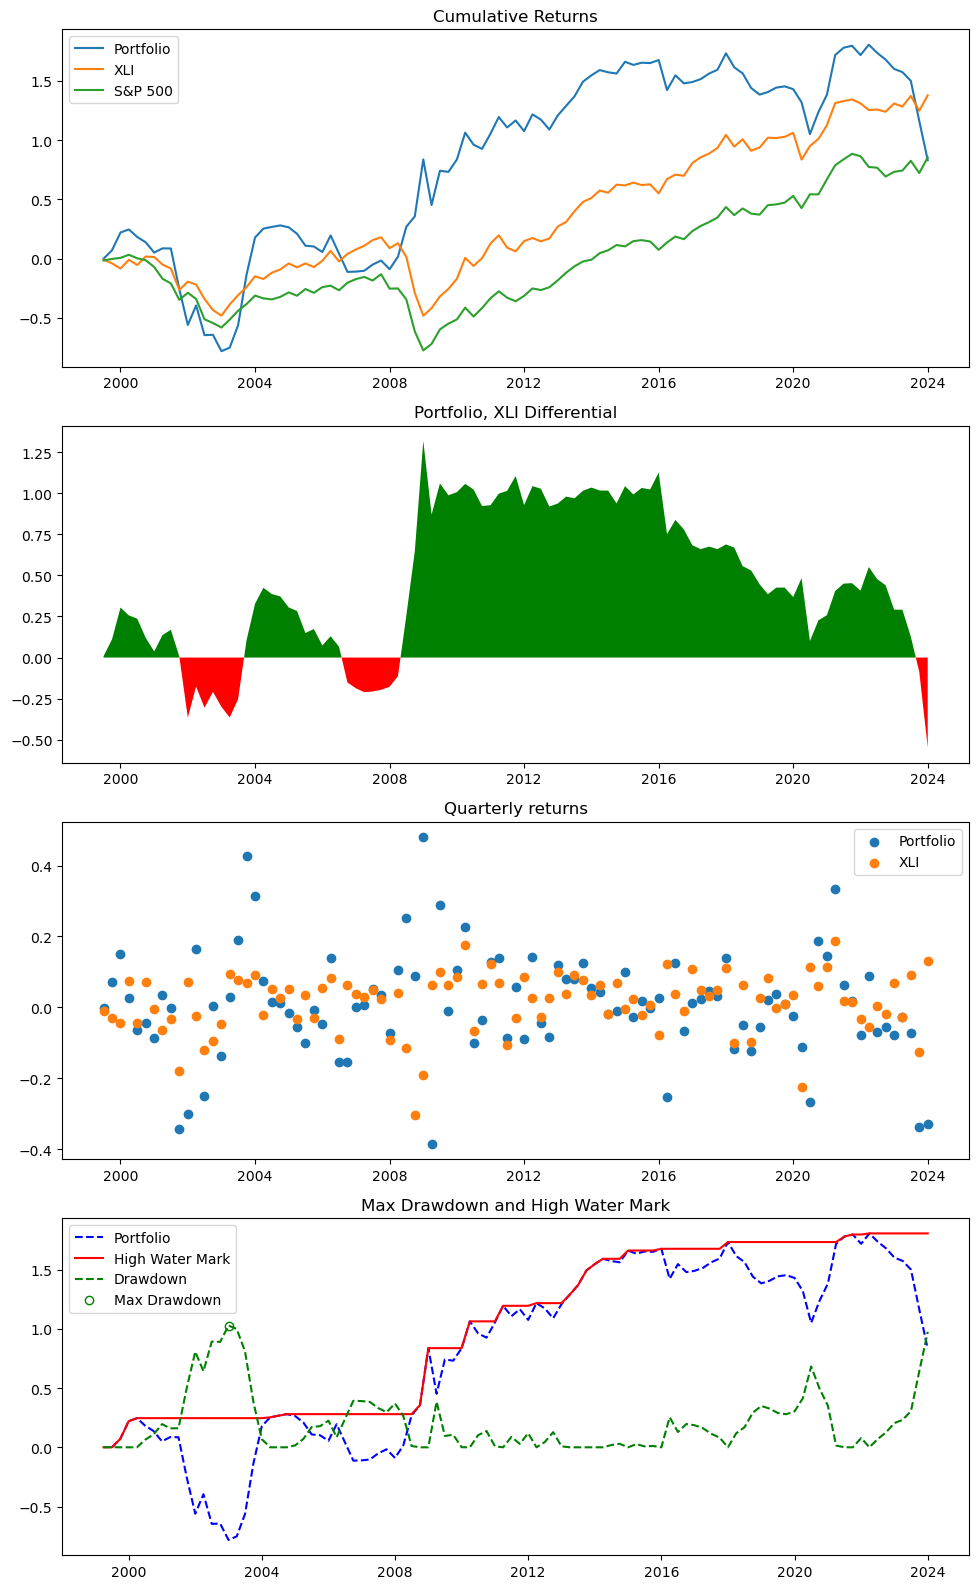

In [72]:
returns_df8 =  calc_return(df3Wmom, log_returns_3)
metrics_8, HWMs_8, mdd_track_8 = calc_metrics(returns_df8)
res = graph(returns_df8, bench_ret, HWMs_8, mdd_track_8)
plt.show()

In [73]:
returns_df8.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.001000 -0.001000 -0.001000 -0.001000 -0.001000 -0.001000   
1999-10-01  0.096861  0.070088 -0.029234  0.146613 -0.181357  0.007715   
2000-01-01  0.265285 -0.070247 -0.090591  0.230206  0.373592 -0.004849   
2000-04-01  0.331064 -0.049673 -0.187733 -0.326166 -0.393992  0.083785   

                 ETN    UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                             ...                        
1999-04-01       NaN    NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01 -0.001000    NaN -0.001000 -0.001000  ...   NaN -0.001000  NaN   
1999-10-01 -0.293892    NaN  0.102357 -0.300706  ...   NaN -0.044466  NaN   
2000-01-01  0.251572    NaN -0.153712 -0.073565  ...   NaN  0.126669  NaN   
2000-04-01 -0.139241 -0.001 -0.233354 -0.048515  ...   NaN  0.012753  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC  Portfolio  
Date                                                                  
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN        NaN  
1999-07-01 -0.001000  NaN   NaN -0.001000 -0.001000   NaN  -0.001000  
1999-10-01 -0.392698  NaN   NaN -0.132028  0.013870   NaN   0.071230  
2000-01-01  0.614345  NaN   NaN -0.145411  0.055242   NaN   0.149530  
2000-04-01 -0.103572  NaN   NaN  0.502951  2.280821   NaN   0.026168  

[5 rows x 78 columns]

In [74]:
metrics_8

CAT         GE        UNP        RTX        HON  \
Annualized Return     0.219551   0.236733   0.017212   0.034538  -0.134537   
Annualized Vol        0.698912   0.820552   0.406267   0.392566   0.866892   
Sharpe Ratio          0.314132   0.288504   0.042365   0.087979  -0.155195   
Skewness              1.894260   1.232317   1.812033  -1.076543  -4.792986   
Excess Kurtosis       7.484134  15.631273  17.420629  12.573374  37.142739   
High Water Mark       7.597788   6.213574   1.593947   0.999047   0.191235   
Max Drawdown          2.163902   2.157447   1.163659   1.467290   6.058143   
XLI Beta             -0.607222   0.240316  -0.151105   0.073894  -0.491678   
Annualized XLI Alpha  0.253343   0.225750   0.025794   0.030774  -0.108534   
S&P Beta             -0.941550   0.061814  -0.195169   0.020990   0.001811   
Annualized S&P Alpha  0.252008   0.236993   0.024113   0.034163  -0.135959   

                            BA        ETN       UPS        DE       ADP  ...  \
Annualized Return    -0.003630   0.102777 -0.068948  0.128588 -0.084495  ...   
Annualized Vol        0.759194   0.448954  0.295905  0.625639  0.261770  ...   
Sharpe Ratio         -0.004781   0.228925 -0.233007  0.205531 -0.322785  ...   
Skewness             -1.595117   2.339835  0.175821  1.808601 -1.487421  ...   
Excess Kurtosis       8.389137  13.862479  9.139048  6.731718  4.494344  ...   
High Water Mark       3.237257   2.569418  0.027700  4.242350  0.000000  ...   
Max Drawdown          3.327994   1.242438  1.751398  2.681860  2.442816  ...   
XLI Beta             -0.525573  -0.173521 -0.308594 -0.153962  0.279198  ...   
Annualized XLI Alpha  0.025582   0.113471 -0.052471  0.138455 -0.100886  ...   
S&P Beta             -0.872349  -0.444695 -0.505373 -0.550992  0.332044  ...   
Annualized S&P Alpha  0.026405   0.119144 -0.052223  0.148881 -0.096795  ...   

                           ALLE       ITT       HII       AOS        AAL  \
Annualized Return     -0.019263 -0.130333  0.055638  0.076255   0.554116   
Annualized Vol         0.179275  0.424724  0.332616  0.626587   2.444628   
Sharpe Ratio          -0.107447 -0.306866  0.167273  0.121700   0.226667   
Skewness              -3.482653 -0.156560 -0.025312  0.662481  -1.096262   
Excess Kurtosis       22.777205  2.775893  4.487752  5.772144  12.709141   
High Water Mark        0.434581  0.807785  2.161883  3.325779  18.388672   
Max Drawdown           0.916147  4.130832  0.811391  2.179686  11.611471   
XLI Beta               0.132480  0.617323  0.382766  0.620730   4.842768   
Annualized XLI Alpha  -0.026830 -0.166005  0.034898  0.042482   0.290209   
S&P Beta               0.059631  0.580313  0.318580  0.664380   5.518743   
Annualized S&P Alpha  -0.021513 -0.151655  0.045218  0.054123   0.369471   

                          PAYC      CHRW        RHI       GNRC  Portfolio  
Annualized Return     0.067809 -0.069456   0.141436  -0.226854   0.033211  
Annualized Vol        0.974305  0.338003   0.722496   1.396161   0.297597  
Sharpe Ratio          0.069597 -0.205491   0.195760  -0.162484   0.111598  
Skewness             -0.274319  0.403625   2.328407  -1.700395   0.090546  
Excess Kurtosis       8.318934  3.851610  14.728736  10.035733   1.390352  
High Water Mark       5.063604  0.891184   4.014137   5.381768   1.804773  
Max Drawdown          5.032638  2.627594   2.954224  11.053113   1.027688  
XLI Beta              0.929561  0.271759   0.363049   0.738949   0.312331  
Annualized XLI Alpha  0.016763 -0.085282   0.122660  -0.270268   0.016165  
S&P Beta              0.895069  0.350181   0.107231   0.457162   0.299438  
Annualized S&P Alpha  0.037639 -0.082229   0.139168  -0.244905   0.023225  

[11 rows x 78 columns]

In [75]:
df3mom_2 = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

log_returns_3_filled = log_returns_3.replace(np.nan, 0)
for i in tickers[1:]:
    df3mom_2[i] =  np.where(log_returns_3_filled[i] == 0, 0, 1)*np.where(log_returns_3_filled[i] > 0, 2, -2)
    
df3mom_2.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-07-01   -2   2   -2   -2    2   2    2    0  -2   -2  ...    2     0   
1999-10-01   -2   2    2   -2   -2   2   -2    0  -2    2  ...   -2     0   
2000-01-01   -2  -2   -2   -2   -2  -2   -2    0   2   -2  ...   -2     0   
2000-04-01   -2   2    2    2    2  -2    2    2  -2    2  ...   -2     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    0    0     0     0    0     0  
1999-07-01    2    0    2    0     0     2    2     0  
1999-10-01   -2    0   -2    0     0    -2    2     0  
2000-01-01   -2    0   -2    0     0     2    2     0  
2000-04-01   -2    0    2    0     0     2    2     0  

[5 rows x 77 columns]

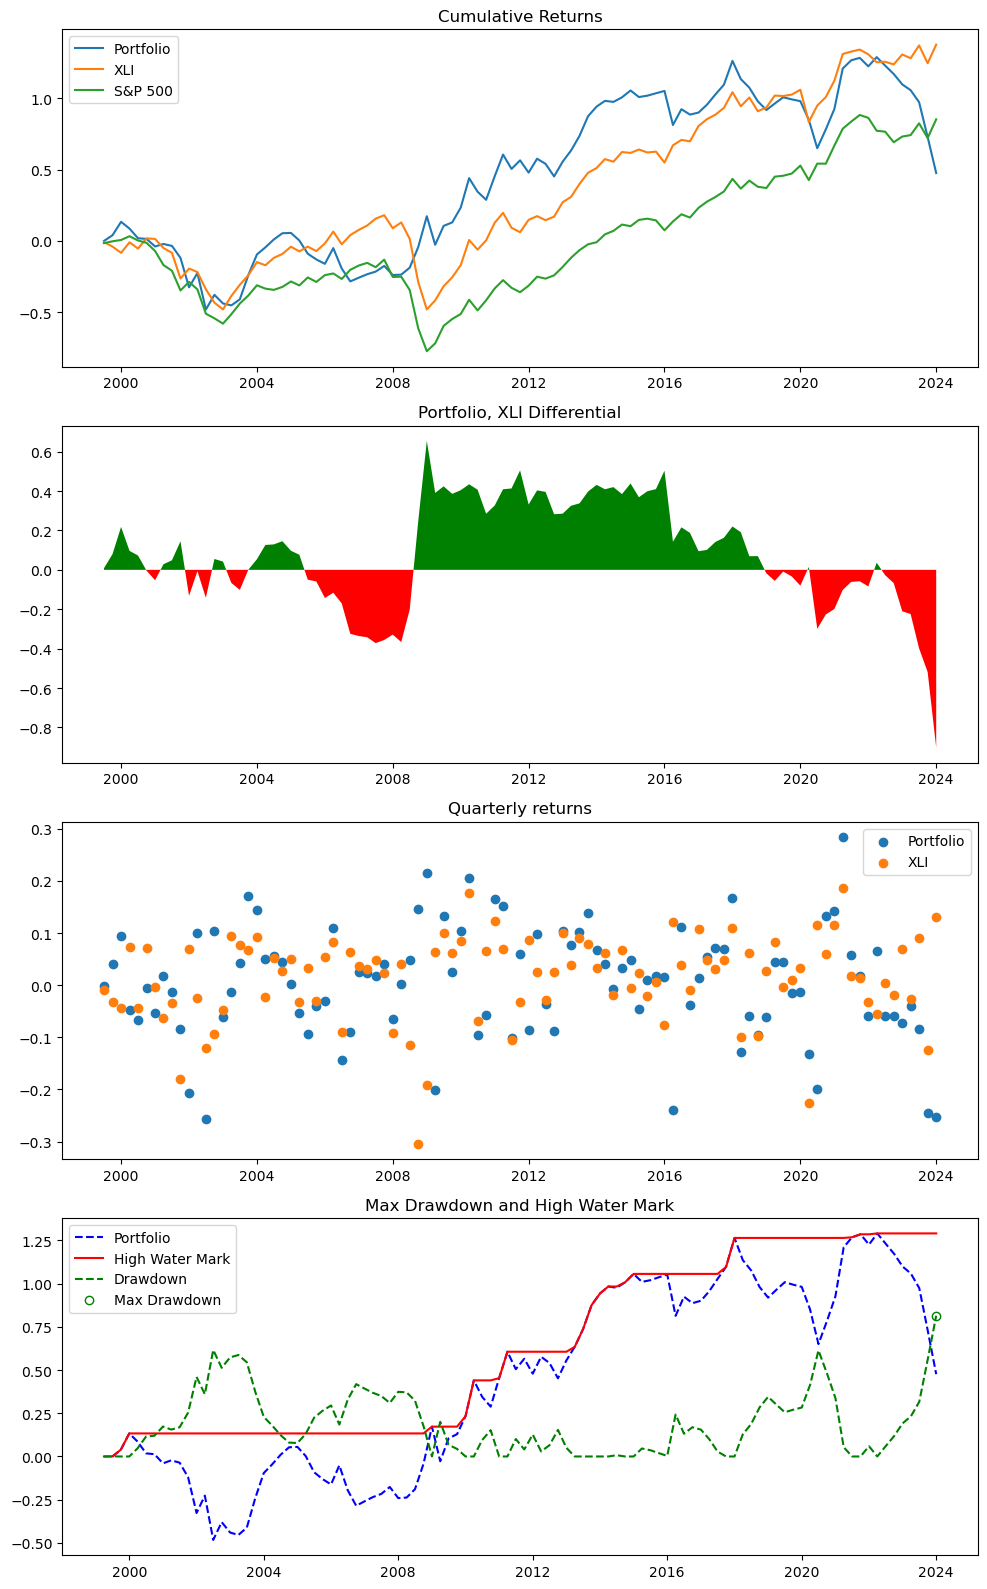

In [76]:
returns_df9 =  calc_return(df3mom_2, log_returns_3)
metrics_9, HWMs_9, mdd_track_9 = calc_metrics(returns_df9)
res = graph(returns_df9, bench_ret, HWMs_9, mdd_track_9)
plt.show()

In [77]:
returns_df9.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.001000 -0.001000 -0.001000 -0.001000 -0.001000 -0.001000   
1999-10-01  0.130170  0.425568 -0.036626  0.214362 -0.275693  0.011364   
2000-01-01  0.545510 -0.044391 -0.671611  0.287620  0.363647 -0.091323   
2000-04-01  0.162326 -0.300129 -0.075254 -0.302478 -0.289186  0.250316   

                 ETN    UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                             ...                        
1999-04-01       NaN    NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01 -0.001000    NaN -0.001000 -0.001000  ...   NaN -0.001000  NaN   
1999-10-01 -0.564263    NaN  0.114349 -0.349179  ...   NaN -0.195569  NaN   
2000-01-01  0.119575    NaN -0.357131 -0.056577  ...   NaN  0.174977  NaN   
2000-04-01 -0.309292 -0.001 -0.174984 -0.228985  ...   NaN  0.020960  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC  Portfolio  
Date                                                                  
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN        NaN  
1999-07-01 -0.001000  NaN   NaN -0.001000 -0.001000   NaN  -0.001000  
1999-10-01 -0.384212  NaN   NaN -0.111950  0.021932   NaN   0.040031  
2000-01-01  0.428202  NaN   NaN -0.348091  0.683851   NaN   0.094261  
2000-04-01 -0.064878  NaN   NaN  0.387181  0.889793   NaN  -0.047766  

[5 rows x 78 columns]

In [78]:
metrics_9

CAT        GE       UNP       RTX       HON  \
Annualized Return     0.158775  0.096643 -0.062863  0.055465 -0.066819   
Annualized Vol        0.593117  0.583235  0.446555  0.421382  0.533477   
Sharpe Ratio          0.267695  0.165702 -0.140773  0.131626 -0.125251   
Skewness              0.362125 -0.170794  0.269367 -0.472141 -0.178956   
Excess Kurtosis       0.875484  2.825574  1.380724  1.145897  3.642710   
High Water Mark       5.740601  2.913431  0.081736  2.516491  0.086954   
Max Drawdown          1.810931  2.506811  2.013301  2.123870  3.901965   
XLI Beta             -0.271674  0.217928  0.120678 -0.011641  0.059387   
Annualized XLI Alpha  0.173893  0.085492 -0.070214  0.056673 -0.070799   
S&P Beta             -0.414260  0.156071 -0.024437 -0.115997  0.043590   
Annualized S&P Alpha  0.173055  0.092239 -0.062656  0.060024 -0.068996   

                            BA       ETN       UPS        DE       ADP  ...  \
Annualized Return     0.170764  0.139020 -0.090201  0.000652 -0.078877  ...   
Annualized Vol        0.686337  0.486003  0.386918  0.546666  0.370318  ...   
Sharpe Ratio          0.248805  0.286047 -0.233125  0.001192 -0.212997  ...   
Skewness              1.191846  0.151108 -0.953717  0.894018  0.105642  ...   
Excess Kurtosis       4.123553  0.619115  2.975396  2.030938  0.773952  ...   
High Water Mark       6.506091  3.475497  1.119350  1.647994  0.000000  ...   
Max Drawdown          2.236988  1.487618  3.374362  2.943436  2.139524  ...   
XLI Beta             -0.751501  0.432735 -0.313690  0.182479  0.083742  ...   
Annualized XLI Alpha  0.214311  0.116342 -0.073655 -0.009497 -0.084334  ...   
S&P Beta             -0.868956  0.243885 -0.497603 -0.040559  0.052471  ...   
Annualized S&P Alpha  0.202444  0.132017 -0.073958  0.002056 -0.081482  ...   

                          ALLE       ITT       HII       AOS        AAL  \
Annualized Return    -0.016491 -0.088754  0.051505  0.066548   0.384201   
Annualized Vol        0.253943  0.521655  0.366265  0.563687   0.910036   
Sharpe Ratio         -0.064941 -0.170139  0.140623  0.118058   0.422182   
Skewness             -0.574303 -0.103810  0.018580 -0.398238   0.176509   
Excess Kurtosis       5.093701  0.313384  2.468499  0.056687   2.299366   
High Water Mark       0.839908  1.175373  2.079435  3.323093  12.368791   
Max Drawdown          1.252192  4.071123  1.026881  1.774894   2.763760   
XLI Beta              0.248642  0.844818  0.300278  0.611453   0.708847   
Annualized XLI Alpha -0.030495 -0.136665  0.035315  0.033192   0.348634   
S&P Beta              0.172764  0.846742  0.150167  0.853446   0.981175   
Annualized S&P Alpha -0.022613 -0.118839  0.046849  0.037800   0.354259   

                          PAYC      CHRW       RHI      GNRC  Portfolio  
Annualized Return     0.023825 -0.097587  0.091342 -0.224421   0.019036  
Annualized Vol        0.532599  0.421556  0.586513  0.779732   0.211317  
Sharpe Ratio          0.044734 -0.231493  0.155737 -0.287819   0.090081  
Skewness             -0.618815 -0.231699  0.153372 -1.531355  -0.258728  
Excess Kurtosis       3.289788  0.013083  0.272537  4.263143   0.199085  
High Water Mark       2.483438  0.385992  3.322208  0.650655   1.289735  
Max Drawdown          2.415210  3.199426  4.487099  6.261187   0.813846  
XLI Beta              0.360822  0.057238  0.468212  0.250774   0.277644  
Annualized XLI Alpha  0.003986 -0.101758  0.066208 -0.240644   0.003777  
S&P Beta              0.345096 -0.007060  0.401895  0.240278   0.270211  
Annualized S&P Alpha  0.012170 -0.098330  0.078410 -0.234971   0.009913  

[11 rows x 78 columns]

In [79]:
df4mom = pd.DataFrame(index = annual_log_returns.index, columns = tickers[1:])

annual_returns_filled = annual_log_returns.replace(np.nan, 0)
for i in tickers[1:]:
    df4mom[i] =  np.where(annual_returns_filled[i] == 0, 0, 1)*np.where(annual_returns_filled[i] > 0, 2, -2)
    
df4mom.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-07-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-10-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
2000-01-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
2000-04-01   -2   2   -2   -2   -2  -2   -2    0  -2    2  ...   -2     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    0    0     0     0    0     0  
1999-07-01    0    0    0    0     0     0    0     0  
1999-10-01    0    0    0    0     0     0    0     0  
2000-01-01    0    0    0    0     0     0    0     0  
2000-04-01   -2    0   -2    0     0     2    2     0  

[5 rows x 77 columns]

In [80]:
annual_returns_filled

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1999-07-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1999-10-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2000-01-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2000-04-01 -0.467342  0.414825 -0.334136 -0.140167 -0.035633 -0.010481   
...              ...       ...       ...       ...       ...       ...   
2023-01-01  0.247727  0.092647 -0.157840  0.124905  0.039847  0.061775   
2023-04-01  0.061634  0.536409 -0.155611  0.074338  0.052454  0.328784   
2023-07-01  0.314623  0.687020  0.045782 -0.035045  0.029022  0.404984   
2023-10-01  0.065131  0.585518  0.077202 -0.128312 -0.086454  0.270733   
2024-01-01  0.194501  0.501745  0.202739 -0.065578 -0.008449 -0.009245   

                 ETN       UPS        DE       ADP  ...      ALLE       ITT  \
Date                                                ...                       
1999-04-01  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
1999-07-01  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
1999-10-01  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2000-01-01  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2000-04-01 -0.066041  0.000000 -0.034717  0.197422  ...  0.000000 -0.113567   
...              ...       ...       ...       ...  ...       ...       ...   
2023-01-01  0.045367 -0.055150  0.128615  0.109849  ... -0.031079  0.010608   
2023-04-01  0.163104  0.033143  0.014095  0.027839  ... -0.020837  0.198291   
2023-07-01  0.345339 -0.005526  0.236879  0.045730  ...  0.112774  0.296655   
2023-10-01  0.345147 -0.135399 -0.067551 -0.080930  ... -0.050808  0.213088   
2024-01-01  0.434761 -0.227480 -0.058311  0.107217  ...  0.068658  0.288717   

                 HII       AOS       AAL      PAYC      CHRW       RHI  \
Date                                                                     
1999-04-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1999-07-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1999-10-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2000-01-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2000-04-01  0.000000 -0.185582  0.000000  0.000000  0.521024  0.940089   
...              ...       ...       ...       ...       ...       ...   
2023-01-01  0.186298 -0.102565 -0.020240 -0.034467 -0.022399 -0.279657   
2023-04-01 -0.031774  0.175812 -0.319253  0.031130 -0.028867 -0.275729   
2023-07-01  0.079612  0.157837  0.200273  0.110915 -0.076290 -0.041036   
2023-10-01 -0.133707  0.261050 -0.240393 -0.342639 -0.152260  0.002653   
2024-01-01  0.183324  0.154857 -0.125948 -0.527493 -0.148378 -0.028771   

                GNRC      Mean  
Date                            
1999-04-01  0.000000  0.000000  
1999-07-01  0.000000  0.000000  
1999-10-01  0.000000  0.000000  
2000-01-01  0.000000  0.000000  
2000-04-01  0.000000 -0.110418  
...              ...       ...  
2023-01-01 -0.850774  0.021409  
2023-04-01 -0.763678  0.069240  
2023-07-01 -0.557103  0.169795  
2023-10-01 -0.321164  0.066264  
2024-01-01 -0.059180  0.136294  

[100 rows x 78 columns]

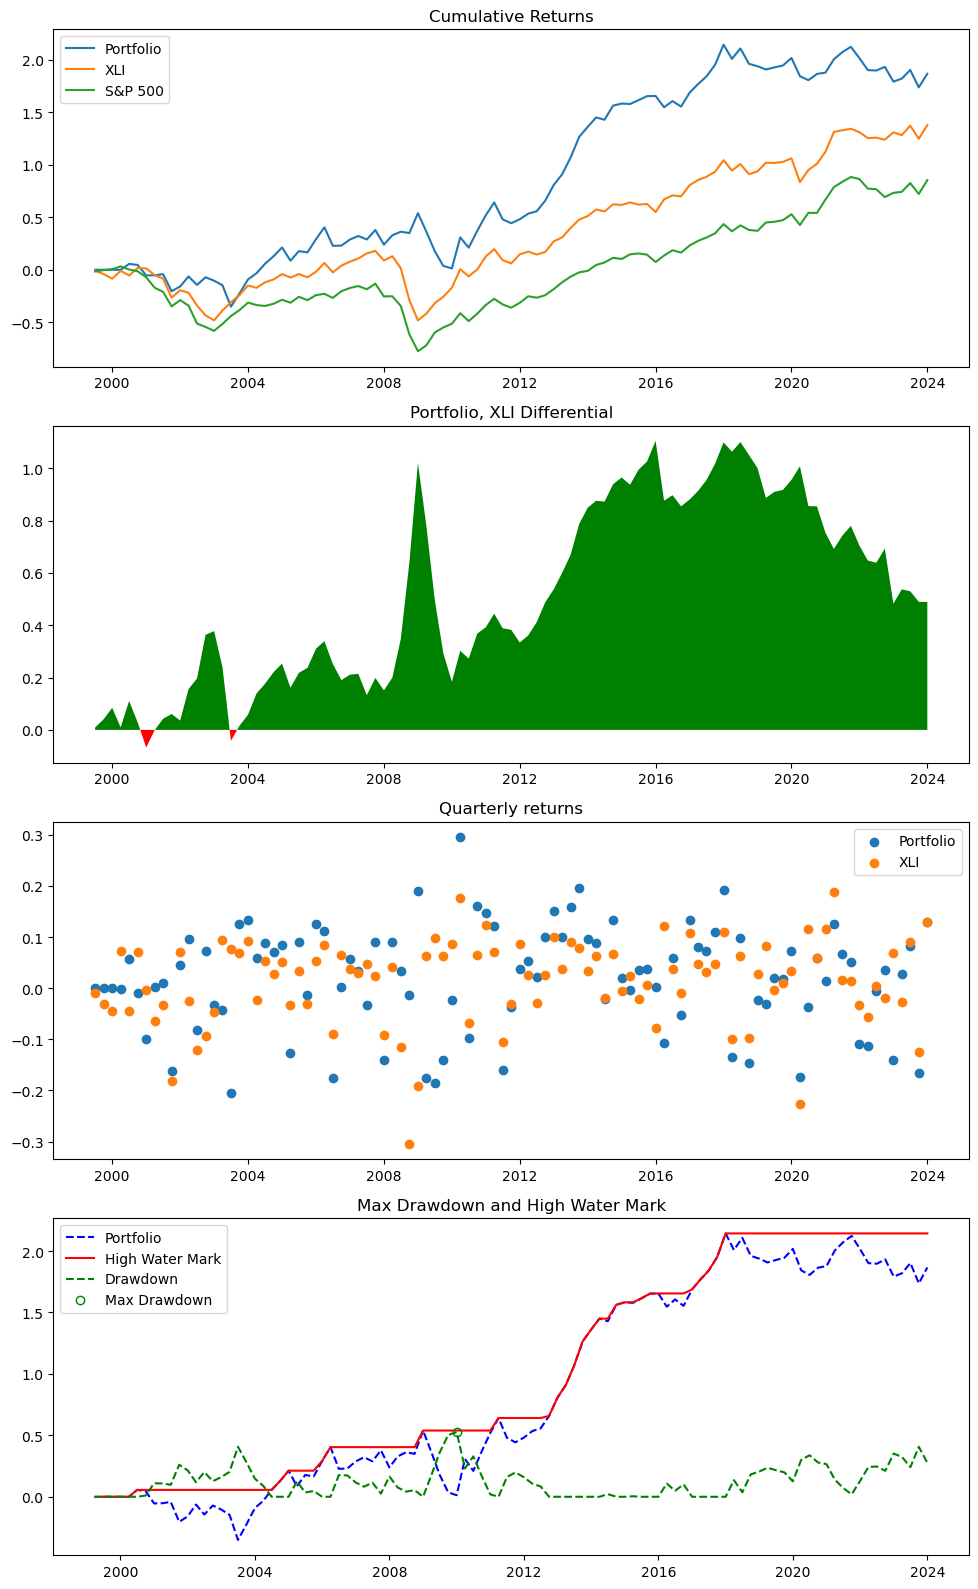

In [81]:
returns_df10 =  calc_return(df4mom, log_returns_3)
metrics_10, HWMs_10, mdd_track_10 = calc_metrics(returns_df10)
res = graph(returns_df10, bench_ret, HWMs_10, mdd_track_10)
plt.show()

In [82]:
returns_df10.head()

CAT     GE    UNP    RTX    HON     BA    ETN  UPS     DE  \
Date                                                                      
1999-04-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN  NaN    NaN   
1999-07-01 -0.000  0.000 -0.000 -0.000  0.000  0.000  0.000  NaN -0.000   
1999-10-01 -0.000  0.000  0.000 -0.000 -0.000  0.000 -0.000  NaN -0.000   
2000-01-01 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000  NaN  0.000   
2000-04-01 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001  0.0 -0.001   

              ADP  ...  ALLE    ITT  HII    AOS  AAL  PAYC   CHRW    RHI  \
Date               ...                                                     
1999-04-01    NaN  ...   NaN    NaN  NaN    NaN  NaN   NaN    NaN    NaN   
1999-07-01 -0.000  ...   NaN  0.000  NaN  0.000  NaN   NaN  0.000  0.000   
1999-10-01  0.000  ...   NaN -0.000  NaN -0.000  NaN   NaN -0.000  0.000   
2000-01-01 -0.000  ...   NaN -0.000  NaN -0.000  NaN   NaN  0.000  0.000   
2000-04-01 -0.001  ...   NaN -0.001  NaN -0.001  NaN   NaN -0.001 -0.001   

            GNRC  Portfolio  
Date                         
1999-04-01   NaN        NaN  
1999-07-01   NaN   0.000000  
1999-10-01   NaN   0.000000  
2000-01-01   NaN   0.000000  
2000-04-01   NaN  -0.000982  

[5 rows x 78 columns]

In [83]:
metrics_10

CAT        GE       UNP       RTX       HON  \
Annualized Return     0.098587  0.097819  0.090796 -0.007446  0.127188   
Annualized Vol        0.584203  0.573265  0.423512  0.411285  0.518823   
Sharpe Ratio          0.168755  0.170635  0.214387 -0.018105  0.245148   
Skewness              0.517477 -0.554105 -0.514897 -1.101223  0.631896   
Excess Kurtosis       1.091145  3.308567  1.488831  1.320638  4.011092   
High Water Mark       2.440028  5.366260  2.926450  1.642049  5.347155   
Max Drawdown          1.456326  3.820880  1.939766  1.884296  2.167447   
XLI Beta              0.248682 -0.251689  1.030613  0.236072  0.171336   
Annualized XLI Alpha  0.084748  0.112814  0.034358 -0.020659  0.118938   
S&P Beta              0.121813 -0.346450  1.256127  0.013759  0.008122   
Annualized S&P Alpha  0.094388  0.110750  0.048412 -0.007996  0.128193   

                            BA       ETN       UPS        DE       ADP  ...  \
Annualized Return     0.030859  0.175524 -0.030248  0.099636  0.112962  ...   
Annualized Vol        0.689176  0.464353  0.384885  0.537490  0.357608  ...   
Sharpe Ratio          0.044776  0.377996 -0.078591  0.185373  0.315883  ...   
Skewness              0.605085  0.262207 -0.310463 -0.843732  0.378167  ...   
Excess Kurtosis       4.629888  0.789419  3.531946  2.624198  0.784040  ...   
High Water Mark       3.487272  4.388091  0.531364  3.326648  3.611937  ...   
Max Drawdown          2.932666  1.190635  1.989306  2.022479  0.831711  ...   
XLI Beta             -0.243838  0.547903  0.086478  1.547180  0.230076  ...   
Annualized XLI Alpha  0.044740  0.146805 -0.035366  0.014541  0.101300  ...   
S&P Beta             -0.130154  0.527919 -0.110442  1.663250  0.153526  ...   
Annualized S&P Alpha  0.035657  0.159098 -0.026747  0.043307  0.108811  ...   

                          ALLE       ITT       HII       AOS       AAL  \
Annualized Return    -0.033393 -0.050501  0.085803  0.168604  0.123714   
Annualized Vol        0.252299  0.519872  0.346651  0.545478  0.914917   
Sharpe Ratio         -0.132354 -0.097142  0.247521  0.309093  0.135219   
Skewness             -1.212600 -0.343994 -0.344640 -0.045593  0.380477   
Excess Kurtosis       5.025889  0.351222  3.247992  0.173246  2.388612   
High Water Mark       1.390775  0.992877  3.775958  5.360704  6.216850   
Max Drawdown          2.225592  3.234210  1.630874  1.927776  3.124006   
XLI Beta              0.139090  1.141146  0.260735  0.855341 -0.808166   
Annualized XLI Alpha -0.041470 -0.114517  0.072160  0.122706  0.169939   
S&P Beta              0.135848  1.403720  0.051660  0.877605 -0.745197   
Annualized S&P Alpha -0.038413 -0.099401  0.084889  0.140054  0.150652   

                          PAYC      CHRW       RHI      GNRC  Portfolio  
Annualized Return     0.203737  0.060428  0.053569  0.237234   0.074656  
Annualized Vol        0.492723  0.408948  0.542318  0.764663   0.203560  
Sharpe Ratio          0.413493  0.147764  0.098778  0.310247   0.366753  
Skewness             -0.445236 -0.334663 -0.362402  1.071500  -0.285391  
Excess Kurtosis       4.564212  0.454746  0.069949  5.013957  -0.305488  
High Water Mark       5.568786  2.090736  1.775129  6.508213   2.143237  
Max Drawdown          1.011238  1.048766  2.380993  2.038853   0.526272  
XLI Beta              0.711469 -0.163501 -0.535636  0.142240   0.538940  
Annualized XLI Alpha  0.166201  0.070137  0.083919  0.231715   0.045418  
S&P Beta              0.897133 -0.115233 -0.870383 -0.085375   0.567755  
Annualized S&P Alpha  0.174869  0.065011  0.084114  0.242573   0.055839  

[11 rows x 78 columns]

In [84]:
df4Wmom = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

annual_returns_filled = annual_log_returns.replace(np.nan, 0)
for i in tickers[1:]:
    df4Wmom[i] =  np.where(annual_returns_filled[i] == 0, 0, 1)*np.where(annual_returns_filled[i] > 0, annual_returns_filled[i]*5, annual_returns_filled[i]*5)
    
df4Wmom.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1999-07-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1999-10-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2000-01-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2000-04-01 -2.336711  2.074127 -1.670679 -0.700837 -0.178166 -0.052407   

                 ETN  UPS        DE       ADP  ...       ROL  ALLE       ITT  \
Date                                           ...                             
1999-04-01  0.000000  0.0  0.000000  0.000000  ...  0.000000   0.0  0.000000   
1999-07-01  0.000000  0.0  0.000000  0.000000  ...  0.000000   0.0  0.000000   
1999-10-01  0.000000  0.0  0.000000  0.000000  ...  0.000000   0.0  0.000000   
2000-01-01  0.000000  0.0  0.000000  0.000000  ...  0.000000   0.0  0.000000   
2000-04-01 -0.330204  0.0 -0.173586  0.987111  ... -0.739759   0.0 -0.567833   

            HII      AOS  AAL  PAYC      CHRW       RHI  GNRC  
Date                                                           
1999-04-01  0.0  0.00000  0.0   0.0  0.000000  0.000000   0.0  
1999-07-01  0.0  0.00000  0.0   0.0  0.000000  0.000000   0.0  
1999-10-01  0.0  0.00000  0.0   0.0  0.000000  0.000000   0.0  
2000-01-01  0.0  0.00000  0.0   0.0  0.000000  0.000000   0.0  
2000-04-01  0.0 -0.92791  0.0   0.0  2.605119  4.700444   0.0  

[5 rows x 77 columns]

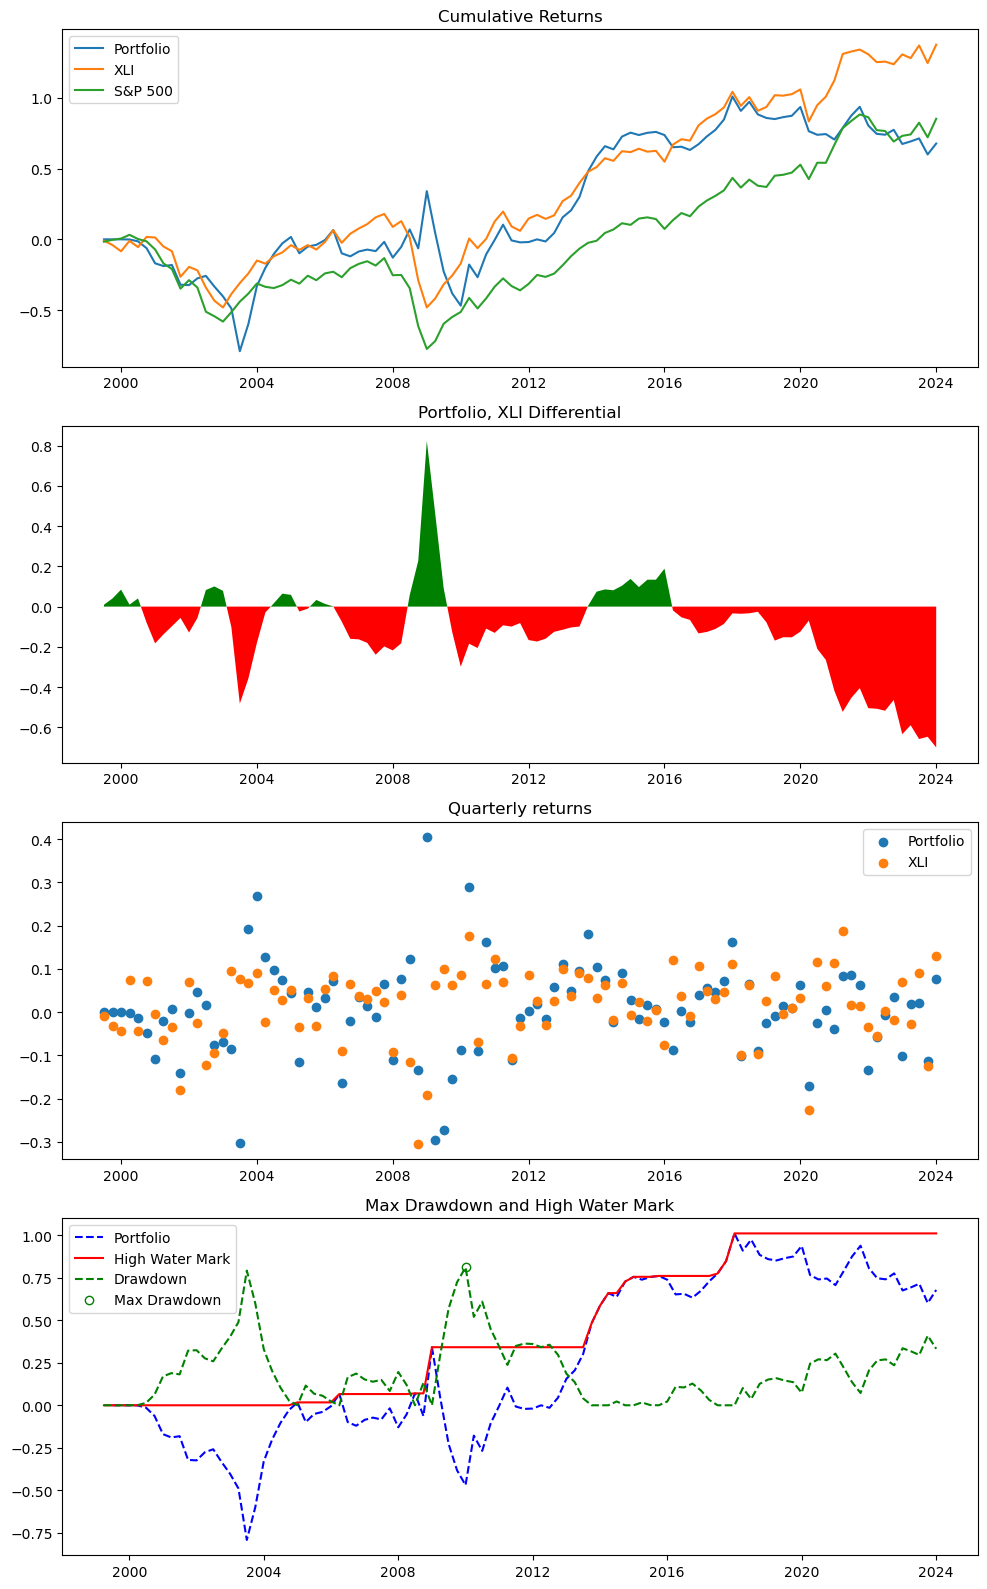

In [85]:
returns_df11 =  calc_return(df4Wmom, log_returns_3)
metrics_11, HWMs_11, mdd_track_11 = calc_metrics(returns_df11)
res = graph(returns_df11, bench_ret, HWMs_11, mdd_track_11)
plt.show()

In [86]:
returns_df11.head()

CAT     GE    UNP    RTX    HON     BA    ETN  UPS     DE  \
Date                                                                      
1999-04-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN  NaN    NaN   
1999-07-01 -0.000  0.000 -0.000 -0.000  0.000  0.000  0.000  NaN -0.000   
1999-10-01 -0.000  0.000  0.000 -0.000 -0.000  0.000 -0.000  NaN -0.000   
2000-01-01 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000  NaN  0.000   
2000-04-01 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001  0.0 -0.001   

              ADP  ...  ALLE    ITT  HII    AOS  AAL  PAYC   CHRW    RHI  \
Date               ...                                                     
1999-04-01    NaN  ...   NaN    NaN  NaN    NaN  NaN   NaN    NaN    NaN   
1999-07-01 -0.000  ...   NaN  0.000  NaN  0.000  NaN   NaN  0.000  0.000   
1999-10-01  0.000  ...   NaN -0.000  NaN -0.000  NaN   NaN -0.000  0.000   
2000-01-01 -0.000  ...   NaN -0.000  NaN -0.000  NaN   NaN  0.000  0.000   
2000-04-01 -0.001  ...   NaN -0.001  NaN -0.001  NaN   NaN -0.001 -0.001   

            GNRC  Portfolio  
Date                         
1999-04-01   NaN        NaN  
1999-07-01   NaN   0.000000  
1999-10-01   NaN   0.000000  
2000-01-01   NaN   0.000000  
2000-04-01   NaN  -0.000982  

[5 rows x 78 columns]

In [87]:
metrics_11

CAT         GE       UNP       RTX        HON  \
Annualized Return     0.034298   0.051410  0.054418 -0.050160  -0.037372   
Annualized Vol        0.485004   0.527833  0.236660  0.245154   0.370882   
Sharpe Ratio          0.070717   0.097397  0.229941 -0.204607  -0.100766   
Skewness             -0.243212   1.957448 -0.564056 -1.802925  -4.534051   
Excess Kurtosis       2.811245  12.112904  3.153599  4.771989  31.268867   
High Water Mark       1.671399   3.170647  1.553434  0.193736   0.088987   
Max Drawdown          2.112398   2.653396  1.000641  1.614260   1.938820   
XLI Beta              0.439143  -0.527828  0.437842  0.171216   0.201093   
Annualized XLI Alpha  0.009859   0.081303  0.030601 -0.060195  -0.048941   
S&P Beta              0.283337  -0.595623  0.501848  0.012438   0.266349   
Annualized S&P Alpha  0.024531   0.072461  0.037668 -0.051095  -0.046931   

                            BA       ETN        UPS        DE       ADP  ...  \
Annualized Return     0.001269  0.110884  -0.000038  0.050258  0.026557  ...   
Annualized Vol        0.583410  0.303586   0.221393  0.428085  0.155109  ...   
Sharpe Ratio          0.002175  0.365247  -0.000170  0.117401  0.171214  ...   
Skewness             -0.615318  0.341807   0.791793 -0.016425 -0.013513  ...   
Excess Kurtosis       4.289137  4.969631  15.111526  3.779198  1.914203  ...   
High Water Mark       3.148156  2.772102   0.461720  1.643821  0.785443  ...   
Max Drawdown          3.262897  0.839835   0.618133  1.824928  0.664215  ...   
XLI Beta             -0.386493  0.319259   0.137990  0.936856  0.212371  ...   
Annualized XLI Alpha  0.022790  0.094237  -0.007717 -0.001372  0.015007  ...   
S&P Beta             -0.600926  0.211698   0.036447  0.911150  0.211816  ...   
Annualized S&P Alpha  0.021997  0.104706  -0.001294  0.019356  0.019523  ...   

                           ALLE       ITT        HII       AOS        AAL  \
Annualized Return     -0.030167  0.010834   0.047648  0.081890   0.189317   
Annualized Vol         0.137398  0.285866   0.299030  0.392838   2.119893   
Sharpe Ratio          -0.219560  0.037901   0.159342  0.208458   0.089305   
Skewness              -4.429860  0.792680  -0.101848 -0.384580  -1.469815   
Excess Kurtosis       31.053077  3.952581  11.810489  2.108652  14.682034   
High Water Mark        0.407575  1.015628   2.707824  2.816846   9.167177   
Max Drawdown           1.161751  1.494882   1.516624  1.582417   6.292220   
XLI Beta               0.193230  0.608272   0.144686  0.657035   0.121769   
Annualized XLI Alpha  -0.041225 -0.022907   0.040077  0.046153   0.184453   
S&P Beta               0.155310  0.653250   0.009947  0.609000   0.440660   
Annualized S&P Alpha  -0.035826 -0.011575   0.047786  0.061724   0.176039   

                          PAYC      CHRW       RHI      GNRC  Portfolio  
Annualized Return     0.166624  0.025806 -0.026913  0.329900   0.027110  
Annualized Vol        0.541942  0.237473  0.464468  1.072289   0.216952  
Sharpe Ratio          0.307457  0.108669 -0.057943  0.307660   0.124958  
Skewness             -0.039724  0.438325 -1.298480 -0.134290   0.135788  
Excess Kurtosis       5.559516  7.844270  3.031584  6.781053   2.110439  
High Water Mark       4.891644  1.183921  0.479822  9.075350   1.009989  
Max Drawdown          1.176824  0.659557  2.503997  3.014817   0.810380  
XLI Beta              0.632990 -0.014098 -0.322651  0.461904   0.346741  
Annualized XLI Alpha  0.133081  0.026851 -0.009229  0.307527   0.008087  
S&P Beta              0.774283  0.045669 -0.331545  0.183052   0.312169  
Annualized S&P Alpha  0.141616  0.024492 -0.015755  0.326922   0.016623  

[11 rows x 78 columns]

# Combo

In [88]:
df1combo = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

annual_returns_filled = annual_log_returns.replace(np.nan, 0)

for i in tickers[1:]:
    df1combo[i] =  np.where(df3[i] == df3['MEAN PE'], 0, 1)*np.where((df3[i] < df3['MEAN PE']),2,0)*np.where(annual_returns_filled[i] > 0*annual_returns_filled['Mean'], 1, 0)*np.where(df3[i] == -1, 0, 1)*np.where(annual_returns_filled[i] == 0, 0, 1) + np.where(df3[i] == df3['MEAN PE'], 0, 1)*np.where((df3[i] > df3['MEAN PE']),-2,0)*np.where(annual_returns_filled[i] < 0*annual_returns_filled['Mean'], 1, 0)*np.where(df3[i] == -1, 0, 1)*np.where(annual_returns_filled[i] == 0, 0, 1)
    
df1combo.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-07-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-10-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
2000-01-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
2000-04-01    0   0    0    0    0   0    0    0  -2    2  ...    0     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    0    0     0     0    0     0  
1999-07-01    0    0    0    0     0     0    0     0  
1999-10-01    0    0    0    0     0     0    0     0  
2000-01-01    0    0    0    0     0     0    0     0  
2000-04-01    0    0    0    0     0     2    2     0  

[5 rows x 77 columns]

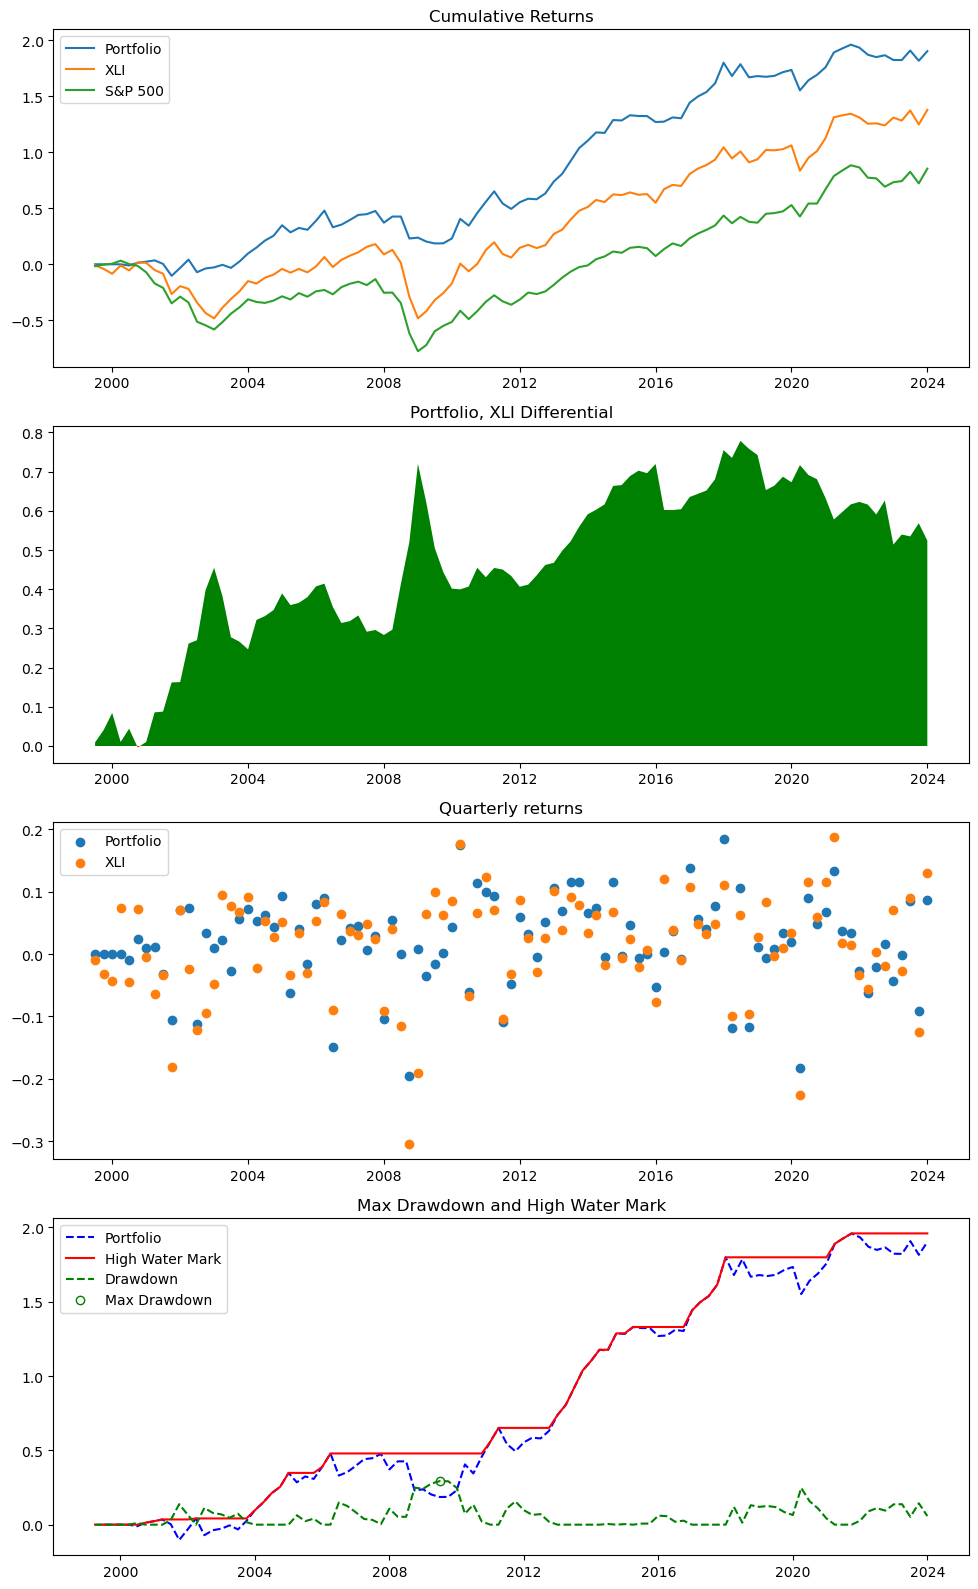

In [89]:
returns_df12 =  calc_return(df1combo, log_returns_3)
metrics_12, HWMs_12, mdd_track_12  = calc_metrics(returns_df12)
res = graph(returns_df12, bench_ret, HWMs_12, mdd_track_12)
plt.show()

In [90]:
returns_df12.head()

CAT   GE  UNP  RTX  HON   BA  ETN  UPS     DE    ADP  ...  ALLE  \
Date                                                              ...         
1999-04-01  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN    NaN  ...   NaN   
1999-07-01 -0.0  0.0 -0.0 -0.0  0.0  0.0  0.0  NaN -0.000 -0.000  ...   NaN   
1999-10-01 -0.0  0.0  0.0 -0.0 -0.0  0.0 -0.0  NaN -0.000  0.000  ...   NaN   
2000-01-01 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0  NaN  0.000 -0.000  ...   NaN   
2000-04-01 -0.0  0.0  0.0  0.0  0.0 -0.0  0.0  0.0 -0.001 -0.001  ...   NaN   

            ITT  HII  AOS  AAL  PAYC   CHRW    RHI  GNRC  Portfolio  
Date                                                                 
1999-04-01  NaN  NaN  NaN  NaN   NaN    NaN    NaN   NaN        NaN  
1999-07-01  0.0  NaN  0.0  NaN   NaN  0.000  0.000   NaN   0.000000  
1999-10-01 -0.0  NaN -0.0  NaN   NaN -0.000  0.000   NaN   0.000000  
2000-01-01 -0.0  NaN -0.0  NaN   NaN  0.000  0.000   NaN   0.000000  
2000-04-01 -0.0  NaN  0.0  NaN   NaN -0.001 -0.001   NaN  -0.000298  

[5 rows x 78 columns]

In [91]:
metrics_12

CAT        GE       UNP       RTX       HON  \
Annualized Return     0.076044  0.104934  0.141826  0.002102  0.067475   
Annualized Vol        0.383846  0.254882  0.361870  0.329149  0.317221   
Sharpe Ratio          0.198112  0.411699  0.391926  0.006386  0.212708   
Skewness              0.054153  1.091537 -0.907546 -1.662742  0.103945   
Excess Kurtosis       1.098783  3.085071  4.260093  5.337829  2.116859   
High Water Mark       1.882099  2.623359  3.910863  2.153903  2.941152   
Max Drawdown          1.023317  0.434140  1.253112  2.101351  1.254267   
XLI Beta              0.980412  0.458753  1.286758  0.854987  0.888623   
Annualized XLI Alpha  0.021484  0.080464  0.071650 -0.045457  0.018704   
S&P Beta              1.017682  0.493068  1.504815  0.731556  0.876144   
Annualized S&P Alpha  0.040963  0.088997  0.091385 -0.023095  0.037955   

                             BA       ETN       UPS        DE       ADP  ...  \
Annualized Return      0.165410  0.152609 -0.002829  0.145353  0.036353  ...   
Annualized Vol         0.506222  0.332693  0.267557  0.475932  0.195813  ...   
Sharpe Ratio           0.326753  0.458709 -0.010575  0.305408  0.185650  ...   
Skewness               1.693309 -0.125367  0.435278 -1.200307 -0.130029  ...   
Excess Kurtosis       18.622600  0.797483  4.256903  5.897071  3.571059  ...   
High Water Mark        4.135238  3.815234  0.488076  4.067306  1.577036  ...   
Max Drawdown           1.298072  0.685699  0.797023  1.275434  0.668218  ...   
XLI Beta               0.291736  1.036533  0.136862  1.630503  0.250835  ...   
Annualized XLI Alpha   0.150845  0.096467 -0.010474  0.056083  0.022761  ...   
S&P Beta               0.451503  1.072786  0.001243  1.723325  0.302040  ...   
Annualized S&P Alpha   0.151516  0.117170 -0.002901  0.087415  0.026308  ...   

                           ALLE       ITT       HII       AOS        AAL  \
Annualized Return     -0.048477  0.032416  0.109304  0.203633  -0.014634   
Annualized Vol         0.188872  0.364043  0.296982  0.387054   0.345476   
Sharpe Ratio          -0.256664  0.089045  0.368049  0.526111  -0.042359   
Skewness              -2.654118 -0.695095  0.220728  0.740230   1.028298   
Excess Kurtosis       13.018098  4.631590  4.610695  4.237419  19.137427   
High Water Mark        0.636077  1.671324  3.549632  5.625309   1.523179   
Max Drawdown           1.847994  1.758871  0.832056  1.142618   1.889033   
XLI Beta               0.154835  1.146401  0.469148  0.737746   0.117950   
Annualized XLI Alpha  -0.057583 -0.031055  0.084300  0.164634  -0.021346   
S&P Beta               0.146739  1.354018  0.327408  0.816312   0.043224   
Annualized S&P Alpha  -0.054025 -0.013932  0.099122  0.177550  -0.016272   

                           PAYC      CHRW       RHI       GNRC  Portfolio  
Annualized Return      0.042558  0.029246  0.072813   0.222126   0.076051  
Annualized Vol         0.156316  0.235251  0.316395   0.606350   0.141300  
Sharpe Ratio           0.272259  0.124318  0.230134   0.366334   0.538224  
Skewness               3.476216  0.638248 -0.033338   3.172466  -0.582442  
Excess Kurtosis       23.991506  3.019421  4.850458  13.062506   0.720915  
High Water Mark        1.063962  0.952912  2.429030   6.130518   1.959195  
Max Drawdown           0.381461  0.575863  1.236123   0.869395   0.293098  
XLI Beta               0.086332 -0.069371  0.069367  -0.040275   0.679049  
Annualized XLI Alpha   0.038184  0.033402  0.069688   0.226611   0.039030  
S&P Beta               0.136206 -0.008639  0.005378  -0.313128   0.737413  
Annualized S&P Alpha   0.038293  0.029839  0.073363   0.235164   0.051399  

[11 rows x 78 columns]

In [92]:
df3combo = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

log_returns_3_filled = log_returns_3.replace(np.nan, 0)

for i in tickers[1:]:
    df3combo[i] =  np.where(df3[i] == df3['MEAN PE'], 0, 1)*np.where((df3[i] < df3['MEAN PE']),4,0)*np.where(log_returns_3_filled[i] > 0*log_returns_3_filled['Mean'], 1, 0)*np.where(df3[i] == -1, 0, 1)*np.where(log_returns_3_filled[i] == 0, 0, 1) + np.where(df3[i] == df3['MEAN PE'], 0, 1)*np.where((df3[i] > df3['MEAN PE']),-4,0)*np.where(log_returns_3_filled[i] < 0*log_returns_3_filled['Mean'], 1, 0)*np.where(df3[i] == -1, 0, 1)*np.where(log_returns_3_filled[i] == 0, 0, 1)

    
df3combo.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-07-01    0   4    0    0    4   4    4    0   0    0  ...    4     0   
1999-10-01    0   0    0    0    0   4    0    0   0    0  ...   -4     0   
2000-01-01    0  -4    0   -4   -4   0    0    0   4   -4  ...   -4     0   
2000-04-01    0   0    4    4    4   0    4    0  -4    4  ...    0     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    0    0     0     0    0     0  
1999-07-01    0    0    4    0     0     4    4     0  
1999-10-01   -4    0    0    0     0    -4    4     0  
2000-01-01    0    0    0    0     0     0    4     0  
2000-04-01    0    0    4    0     0     4    4     0  

[5 rows x 77 columns]

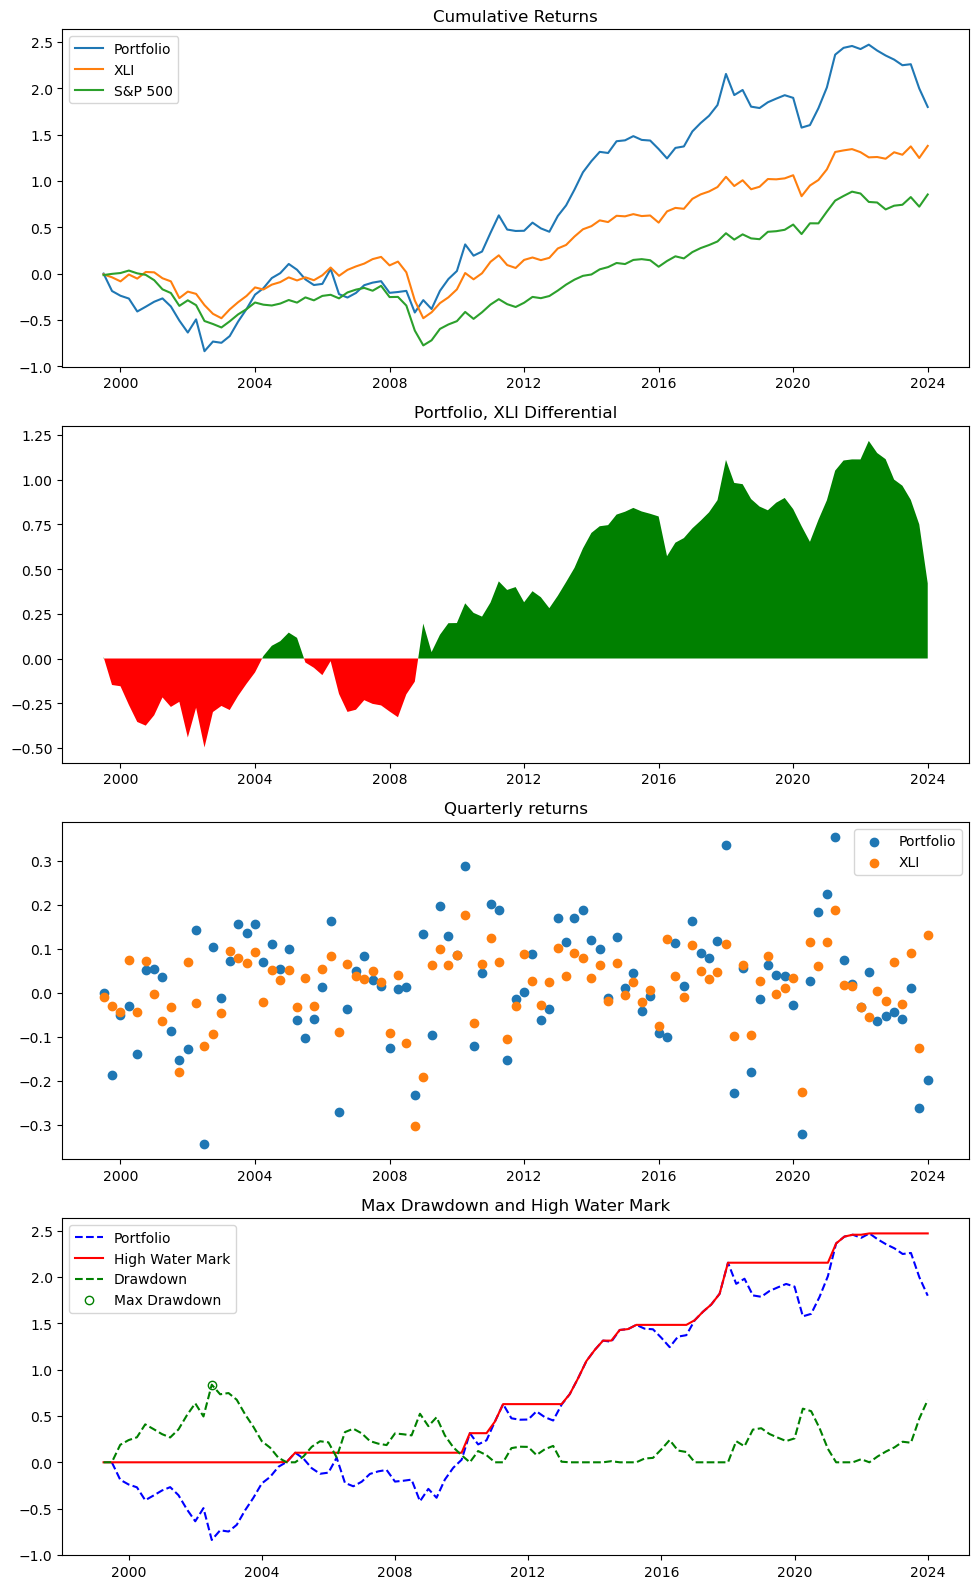

In [93]:
returns_df13 =  calc_return(df3combo, log_returns_3)
metrics_13, HWMs_13, mdd_track_13  = calc_metrics(returns_df13)
res = graph(returns_df13, bench_ret, HWMs_13, mdd_track_13)
plt.show()

In [94]:
returns_df13.head()

CAT        GE    UNP       RTX       HON        BA       ETN  UPS  \
Date                                                                            
1999-04-01  NaN       NaN    NaN       NaN       NaN       NaN       NaN  NaN   
1999-07-01 -0.0 -0.001000 -0.000 -0.000000 -0.001000 -0.001000 -0.001000  NaN   
1999-10-01 -0.0  0.850136  0.000 -0.000000 -0.550386  0.022728 -1.127526  NaN   
2000-01-01 -0.0 -0.001000 -0.000 -0.001000 -0.001000 -0.181647 -0.000000  NaN   
2000-04-01 -0.0 -0.599258 -0.001 -0.603955 -0.577372 -0.000000 -0.001000  0.0   

                  DE      ADP  ...  ALLE       ITT  HII       AOS  AAL  PAYC  \
Date                           ...                                             
1999-04-01       NaN      NaN  ...   NaN       NaN  NaN       NaN  NaN   NaN   
1999-07-01 -0.000000 -0.00000  ...   NaN  0.000000  NaN -0.001000  NaN   NaN   
1999-10-01 -0.000000  0.00000  ...   NaN -0.001000  NaN -0.767424  NaN   NaN   
2000-01-01 -0.001000 -0.00100  ...   NaN  0.348953  NaN -0.000000  NaN   NaN   
2000-04-01 -0.348969 -0.45697  ...   NaN -0.000000  NaN -0.001000  NaN   NaN   

                CHRW       RHI  GNRC  Portfolio  
Date                                             
1999-04-01       NaN       NaN   NaN        NaN  
1999-07-01 -0.001000 -0.001000   NaN  -0.000393  
1999-10-01 -0.222899  0.043863   NaN  -0.188215  
2000-01-01 -0.695182  1.367702   NaN  -0.050868  
2000-04-01 -0.001000  1.779586   NaN  -0.030357  

[5 rows x 78 columns]

In [95]:
metrics_13

CAT        GE       UNP       RTX       HON  \
Annualized Return     0.179306  0.208387  0.161934  0.036017 -0.097968   
Annualized Vol        0.769437  0.693778  0.566449  0.568882  0.804924   
Sharpe Ratio          0.233036  0.300366  0.285875  0.063311 -0.121711   
Skewness             -0.064386  0.986471 -0.098457 -1.491846 -1.159015   
Excess Kurtosis       0.970283  3.370326  1.998441  7.326275  6.123611   
High Water Mark       5.713617  5.459978  4.881034  4.287071  0.000000   
Max Drawdown          1.449614  2.114232  2.511761  3.386656  6.765129   
XLI Beta              1.480795  1.252467  1.610137  1.474692  1.596271   
Annualized XLI Alpha  0.096899  0.140791  0.073964 -0.045687 -0.187791   
S&P Beta              1.490581  1.484724  1.731954  1.320433  1.608757   
Annualized S&P Alpha  0.127923  0.159310  0.103865 -0.009138 -0.154414   

                             BA       ETN       UPS        DE       ADP  ...  \
Annualized Return      0.369589  0.254533 -0.054413  0.212157 -0.109503  ...   
Annualized Vol         0.942639  0.736899  0.533469  0.805233  0.548824  ...   
Sharpe Ratio           0.392079  0.345411 -0.101998  0.263472 -0.199522  ...   
Skewness               3.202360 -0.387888 -0.718708  0.216473 -0.794504  ...   
Excess Kurtosis       19.153360  1.211073  4.635728  0.506336  2.206897  ...   
High Water Mark        9.239731  6.363327  1.722785  6.721301  0.096326  ...   
Max Drawdown           1.538551  2.026287  3.083109  2.338601  3.291973  ...   
XLI Beta              -0.018556  2.032688 -0.152167  1.793178  0.306347  ...   
Annualized XLI Alpha   0.374355  0.143983 -0.046494  0.114508 -0.127657  ...   
S&P Beta               0.195162  1.867597 -0.400934  1.698658  0.496699  ...   
Annualized S&P Alpha   0.366595  0.192724 -0.041142  0.155743 -0.127731  ...   

                           ALLE       ITT       HII       AOS        AAL  \
Annualized Return     -0.086980  0.059118  0.205752  0.277070  -0.031486   
Annualized Vol         0.352921  0.772694  0.582628  0.848499   0.650948   
Sharpe Ratio          -0.246458  0.076509  0.353146  0.326541  -0.048370   
Skewness              -2.290191 -0.404653  0.676607 -0.095855   1.214795   
Excess Kurtosis       12.305259  3.513321  7.128883  1.017793  24.555720   
High Water Mark        0.501449  3.819995  5.990954  8.986415   3.269926   
Max Drawdown           2.675954  4.617828  1.353074  2.132475   4.057080   
XLI Beta               0.419506  1.973907  1.048116  1.300884   0.136849   
Annualized XLI Alpha  -0.111205 -0.050134  0.149502  0.207473  -0.039420   
S&P Beta               0.324774  2.166266  0.811028  1.608427  -0.010841   
Annualized S&P Alpha  -0.099054 -0.014960  0.179873  0.224423  -0.031431   

                           PAYC      CHRW       RHI      GNRC  Portfolio  
Annualized Return     -0.141569 -0.132372  0.202659 -0.042309   0.071888  
Annualized Vol         0.567247  0.527988  0.904508  0.736942   0.263561  
Sharpe Ratio          -0.249573 -0.250710  0.224054 -0.057412   0.272758  
Skewness              -2.213322 -0.231054  0.661485  0.281360  -0.296189  
Excess Kurtosis       13.640661  3.158381  2.969660  6.561139   0.353935  
High Water Mark        0.000000  0.000000  5.998009  1.594853   2.469599  
Max Drawdown           4.594053  3.592288  5.536916  3.581994   0.837806  
XLI Beta              -0.160188  0.085664  1.055157 -0.007912   1.047392  
Annualized XLI Alpha  -0.134085 -0.138476  0.145986 -0.042296   0.014326  
S&P Beta              -0.275340  0.075548  1.158636 -0.362959   1.078096  
Annualized S&P Alpha  -0.133508 -0.136313  0.164766 -0.030224   0.035450  

[11 rows x 78 columns]

In [96]:
df2combo = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

log_returns_3_filled = log_returns_3.replace(np.nan, 0)

for i in tickers[1:]:
    df2combo[i] =  np.where(df3[i] == df3['MEAN PE'], 0, 1)*np.where(df3[i] < df3['MEAN PE'],  df3['MEAN PE']/df3[i], -1*(df3[i]/df3['MEAN PE']) )*np.where(df3[i] == -1, 0, 1) + np.where(log_returns_3_filled[i] == 0, 0, 1)*np.where(log_returns_3_filled[i] > 0, 2, -2)
    
df2combo.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01  1.749778 -1.681557  0.000000 -1.165405  1.106152  1.071276   
1999-07-01  1.958271  6.052516 -2.000000  1.127503  5.088409  5.621397   
1999-10-01 -0.703145  0.493645 -3.567017 -0.778036 -0.887274  3.334336   
2000-01-01 -0.620917 -3.946885 -0.236743 -3.595668 -3.229867 -0.516491   
2000-04-01  0.953214  0.884298  5.566050  3.485537  3.569277  0.727528   

                 ETN       UPS        DE       ADP  ...       ROL  ALLE  \
Date                                                ...                   
1999-04-01  1.454608  0.000000  2.907358 -1.698689  ... -3.355646   0.0   
1999-07-01  5.919782  0.000000  2.916081 -0.085186  ...  3.250286   0.0   
1999-10-01 -0.121863  0.000000 -0.161302  0.444811  ... -4.250278   0.0   
2000-01-01  0.853826 -3.630053  3.266577 -3.818875  ... -3.688029   0.0   
2000-04-01  6.816430  0.461389 -3.078584  3.090584  ... -0.971213   0.0   

                 ITT  HII       AOS        AAL  PAYC      CHRW       RHI  GNRC  
Date                                                                            
1999-04-01  0.000000  0.0  2.373787   5.433082   0.0 -1.016051  1.005949   0.0  
1999-07-01  2.000000  0.0  8.350957  14.210120   0.0  4.417694  6.422202   0.0  
1999-10-01 -5.796803  0.0 -0.287767   5.224777   0.0 -3.105448  3.593000   0.0  
2000-01-01 -0.132709  0.0  0.380482   3.326899   0.0  0.751499  3.322206   0.0  
2000-04-01  1.563008  0.0  7.092494   6.069542   0.0  3.558151  3.427151   0.0  

[5 rows x 77 columns]

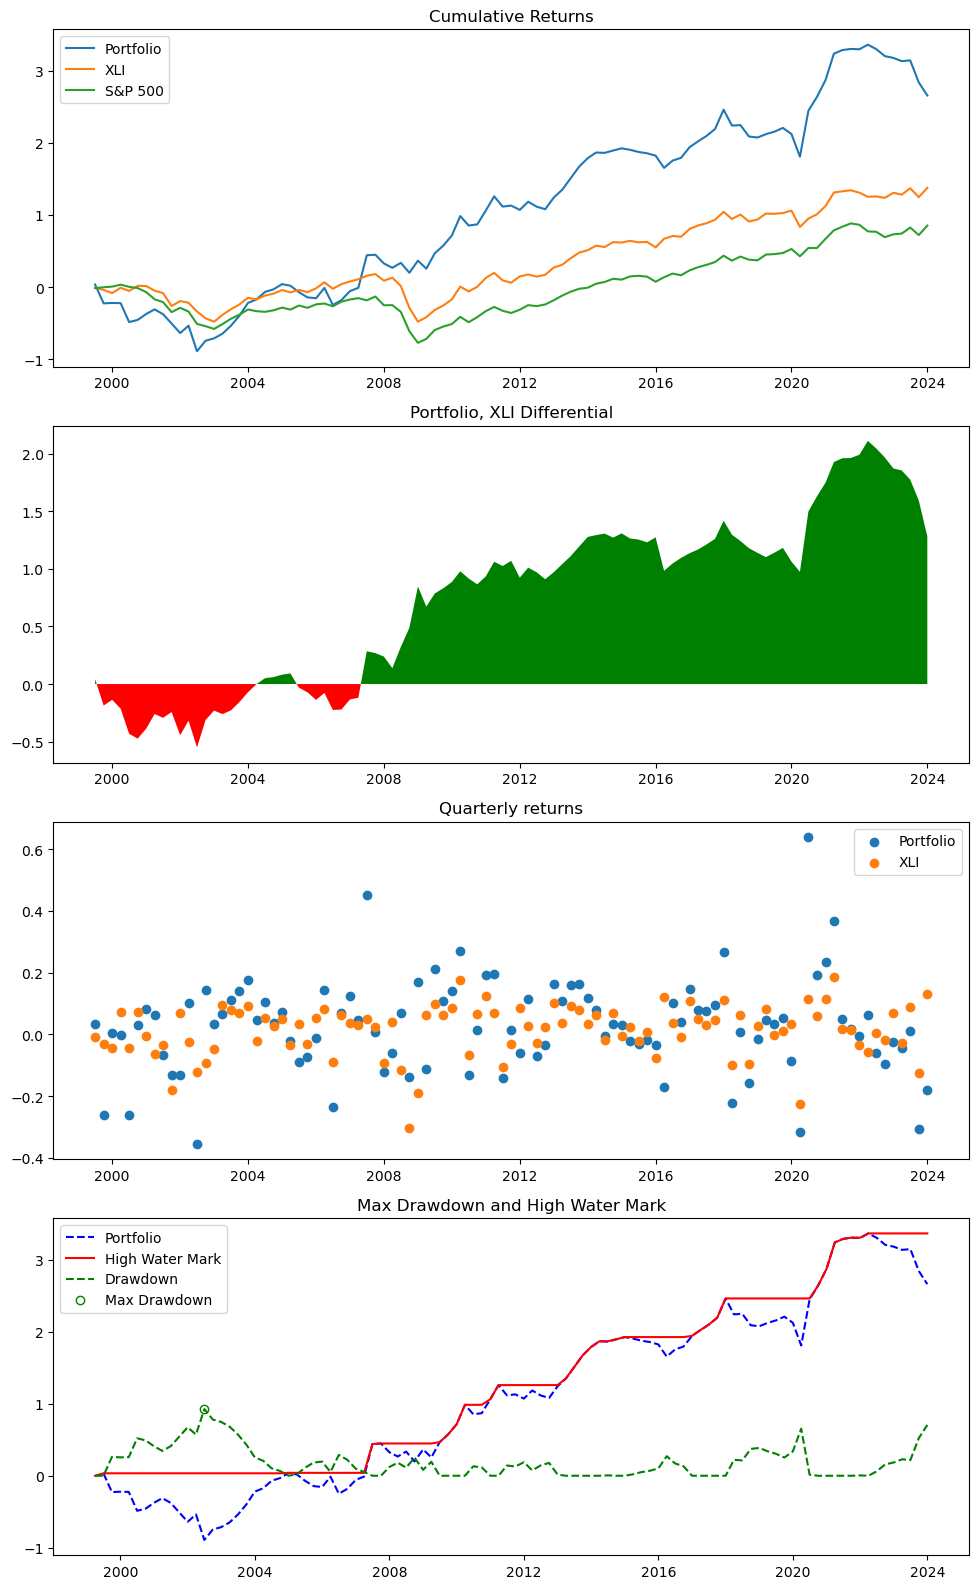

In [97]:
returns_df14 =  calc_return(df2combo, log_returns_3)
metrics_14, HWMs_14, mdd_track_14  = calc_metrics(returns_df14)
res = graph(returns_df14, bench_ret, HWMs_14, mdd_track_14)
plt.show()

In [98]:
returns_df14.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.176396 -0.038452 -0.001000  0.106002  0.095837  0.108544   
1999-10-01 -0.128454  1.286879 -0.036626 -0.121847 -0.699875  0.030940   
2000-01-01  0.190786 -0.011710  1.195040  0.110889  0.160327 -0.151584   
2000-04-01  0.049395 -0.591314 -0.009790 -0.543007 -0.466401  0.063643   

                 ETN       UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                                ...                        
1999-04-01       NaN       NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01  0.099851       NaN -0.351383  0.193960  ...   NaN -0.001000  NaN   
1999-10-01 -1.668198       NaN -0.167725 -0.015830  ...   NaN -0.195569  NaN   
2000-01-01  0.006286       NaN -0.029722 -0.013361  ...   NaN  0.506153  NaN   
2000-04-01  0.130614 -0.334354 -0.285167 -0.436323  ...   NaN  0.000391  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC  Portfolio  
Date                                                                  
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN        NaN  
1999-07-01  0.322514  NaN   NaN -0.160990  0.089939   NaN   0.034048  
1999-10-01 -1.601093  NaN   NaN -0.246071  0.069425   NaN  -0.261268  
2000-01-01  0.060611  NaN   NaN -0.539936  1.227538   NaN   0.005804  
2000-04-01  0.011152  NaN   NaN  0.144483  1.477038   NaN  -0.003070  

[5 rows x 78 columns]

In [99]:
metrics_14

CAT         GE       UNP       RTX       HON  \
Annualized Return      0.084259   0.523920  0.206247  0.006327 -0.043499   
Annualized Vol         1.059211   1.750772  0.566699  0.537669  0.760590   
Sharpe Ratio           0.079548   0.299251  0.363944  0.011767 -0.057191   
Skewness              -3.054227   7.317698  0.754202 -1.180242 -0.506809   
Excess Kurtosis       20.800281  63.007573  2.446667  4.945006  6.804102   
High Water Mark        4.134787  13.831878  5.960328  3.937516  0.095837   
Max Drawdown           4.337109   2.169087  2.142764  4.099317  5.293308   
XLI Beta               0.935264  -1.950645  1.196154  0.873746  1.130655   
Annualized XLI Alpha   0.032210   0.637767  0.141763 -0.042234 -0.106860   
S&P Beta               0.932413  -0.739854  1.393315  0.683967  1.207296   
Annualized S&P Alpha   0.052116   0.554716  0.160300 -0.017187 -0.085556   

                             BA       ETN        UPS        DE       ADP  ...  \
Annualized Return      0.259876  0.229755   0.198654  0.183264 -0.090341  ...   
Annualized Vol         0.865704  0.788254   1.046159  0.780087  0.473431  ...   
Sharpe Ratio           0.300190  0.291473   0.189889  0.234928 -0.190822  ...   
Skewness               2.340608 -1.385151   4.034357  0.286119 -0.882686  ...   
Excess Kurtosis       13.172839  5.045015  21.243457  0.429411  2.574115  ...   
High Water Mark        8.733885  5.743863   7.188210  6.067325  0.467389  ...   
Max Drawdown           2.236988  3.063994   2.221853  3.196865  3.065955  ...   
XLI Beta              -0.102914  2.068402  -1.729614  1.701133  0.103807  ...   
Annualized XLI Alpha   0.268228  0.116967   0.296915  0.090446 -0.097030  ...   
S&P Beta              -0.058913  1.840100  -2.150115  1.644646  0.173830  ...   
Annualized S&P Alpha   0.264532  0.168643   0.274780  0.128421 -0.097246  ...   

                           ALLE       ITT       HII       AOS        AAL  \
Annualized Return     -0.083447  0.078806  0.133213  0.185821   0.083102   
Annualized Vol         0.302418  0.724138  0.596764  0.859980   1.359017   
Sharpe Ratio          -0.275933  0.108827  0.223225  0.216075   0.061149   
Skewness              -2.202918 -0.255103  0.775662 -1.225840  -0.883904   
Excess Kurtosis       10.791592  1.965318  8.949870  4.207708   5.741469   
High Water Mark        0.027651  3.547179  4.111473  6.459633  10.171222   
Max Drawdown           2.113828  4.245803  1.967741  3.389089   9.479873   
XLI Beta               0.379231  1.861752  0.977022  1.430743   2.268950   
Annualized XLI Alpha  -0.105395 -0.024007  0.080186  0.108075  -0.042328   
S&P Beta               0.276115  2.056467  0.690750  1.666004   2.118291   
Annualized S&P Alpha  -0.093808  0.008711  0.110747  0.130267   0.010919   

                           PAYC      CHRW       RHI      GNRC  Portfolio  
Annualized Return     -0.608212 -0.050929  0.063822  0.051765   0.106400  
Annualized Vol         1.675591  0.572515  1.110623  0.788484   0.304131  
Sharpe Ratio          -0.362984 -0.088956  0.057465  0.065651   0.349848  
Skewness              -5.008082  1.537871 -1.575748  0.896881   0.448670  
Excess Kurtosis       33.067429  9.836464  7.653252  4.203215   2.321291  
High Water Mark        0.000000  0.014597  5.604039  5.083419   3.365402  
Max Drawdown          17.712319  3.238081  9.221383  3.789294   0.925517  
XLI Beta              -1.234029  0.392853  0.899352  0.469978   1.022324  
Annualized XLI Alpha  -0.545681 -0.073306  0.014417  0.026133   0.050581  
S&P Beta              -1.628244  0.514230  1.058628  0.410478   1.038489  
Annualized S&P Alpha  -0.558227 -0.069170  0.027973  0.038138   0.071676  

[11 rows x 78 columns]

In [100]:
df4combo = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

annual_returns_filled = annual_log_returns.replace(np.nan, 0)

for i in tickers[1:]:
    df4combo[i] =  np.where(df3[i] == df3['MEAN PE'], 0, 1)*np.where(df3[i] < df3['MEAN PE'],  .5*df3['MEAN PE']/df3[i], -.5*(df3[i]/df3['MEAN PE']) )*np.where(df3[i] == -1, 0, 1) + np.where(annual_returns_filled[i] == 0, 0, 1)*np.where(annual_returns_filled[i] > 0, 1, -1)
    
df4combo.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01  0.874889 -0.840779  0.000000 -0.582703  0.553076  0.535638   
1999-07-01  1.979136  2.026258  0.000000  1.563751  1.544205  1.810698   
1999-10-01  0.648427 -0.753178 -2.783509  0.610982  0.556363  0.667168   
2000-01-01  0.689542 -0.973442  0.881628 -0.797834 -0.614934  0.741755   
2000-04-01  0.476607  0.442149  0.783025 -0.257231 -0.215362  0.363764   

                 ETN       UPS        DE       ADP  ...       ROL  ALLE  \
Date                                                ...                   
1999-04-01  0.727304  0.000000  1.453679 -0.849344  ... -1.677823   0.0   
1999-07-01  1.959891  0.000000  2.458041  0.957407  ...  0.625143   0.0   
1999-10-01  0.939069  0.000000  0.919349 -0.777594  ... -1.125139   0.0   
2000-01-01  1.426913 -1.815026  0.633289 -0.909437  ... -0.844015   0.0   
2000-04-01  1.408215 -0.769305 -1.539292  1.545292  ... -0.485607   0.0   

                 ITT  HII       AOS       AAL  PAYC      CHRW       RHI  GNRC  
Date                                                                           
1999-04-01  0.000000  0.0  1.186893  2.716541   0.0 -0.508025  0.502974   0.0  
1999-07-01  0.000000  0.0  3.175479  7.105060   0.0  1.208847  2.211101   0.0  
1999-10-01 -1.898402  0.0  0.856116  2.612388   0.0 -0.552724  0.796500   0.0  
2000-01-01  0.933646  0.0  1.190241  1.663450   0.0 -0.624251  0.661103   0.0  
2000-04-01  0.781504  0.0  1.546247  3.034771   0.0  1.779076  1.713576   0.0  

[5 rows x 77 columns]

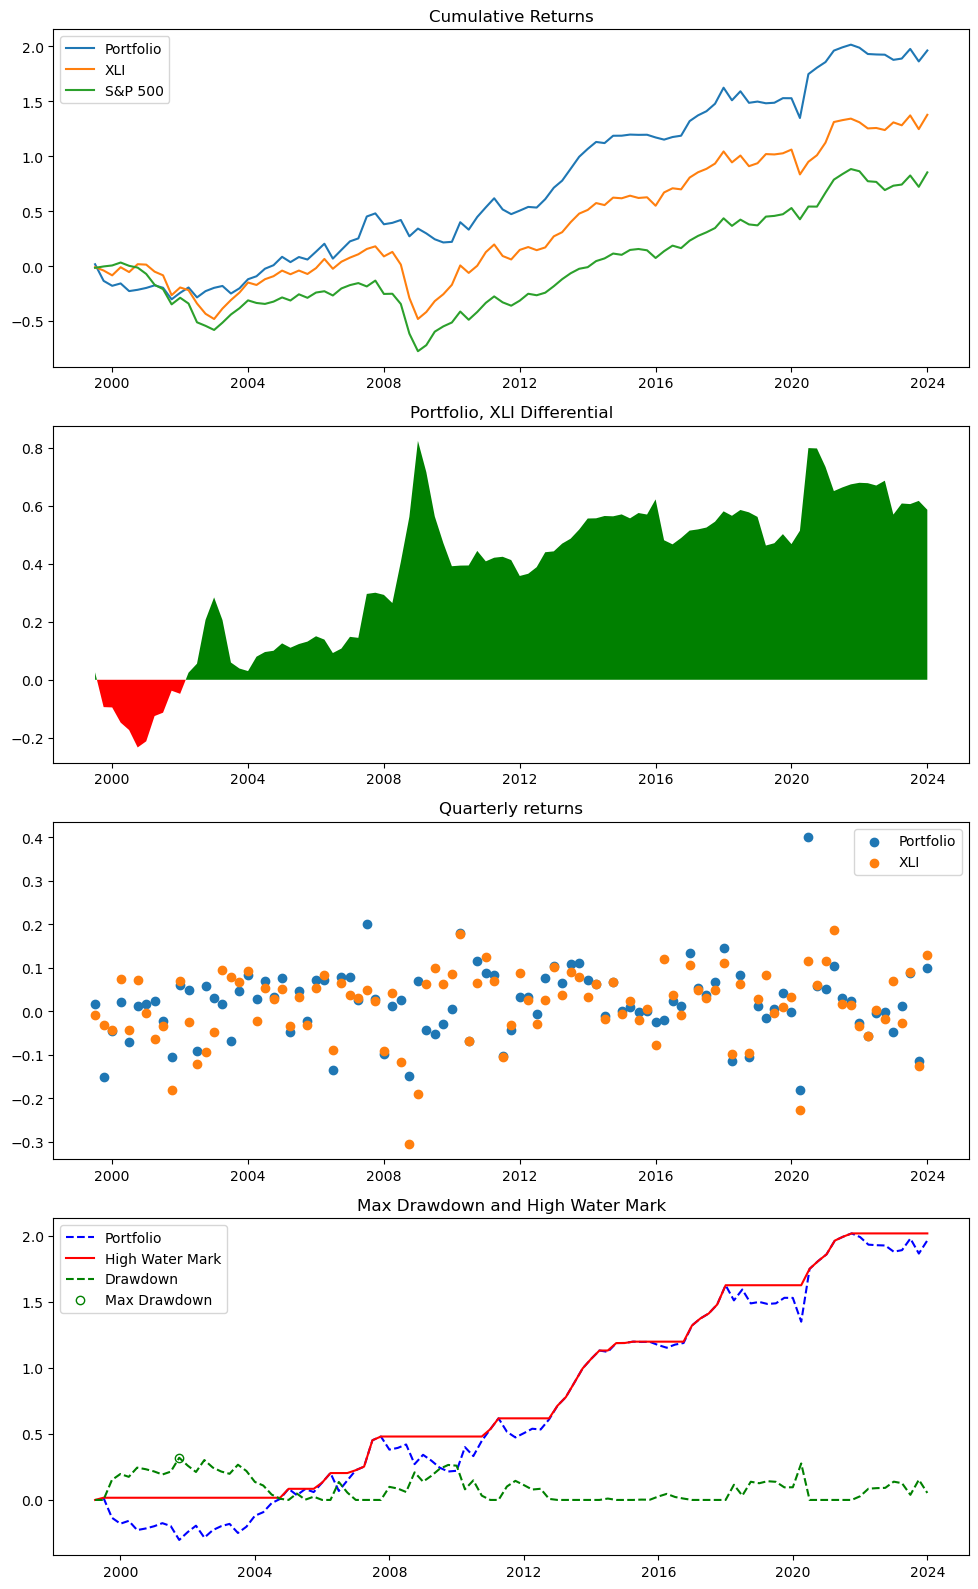

In [101]:
returns_df15 =  calc_return(df4combo, log_returns_3)
metrics_15, HWMs_15, mdd_track_15  = calc_metrics(returns_df15)
res = graph(returns_df15, bench_ret, HWMs_15, mdd_track_15)
plt.show()

In [102]:
returns_df15.head()

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.088698 -0.019726 -0.000000  0.052501  0.047418  0.053772   
1999-10-01 -0.129812  0.430155 -0.001000 -0.168605 -0.213091  0.009288   
2000-01-01 -0.177862  0.015341  0.932325 -0.088865 -0.102160 -0.031130   
2000-04-01 -0.056965 -0.146592  0.031732 -0.121265 -0.089608 -0.093836   

                 ETN       UPS        DE       ADP  ...  ALLE       ITT  HII  \
Date                                                ...                        
1999-04-01       NaN       NaN       NaN       NaN  ...   NaN       NaN  NaN   
1999-07-01  0.049426       NaN -0.176192  0.096480  ...   NaN  0.000000  NaN   
1999-10-01 -0.552967       NaN -0.141537  0.165674  ...   NaN -0.001000  NaN   
2000-01-01 -0.057145       NaN  0.162704  0.020608  ...   NaN  0.165088  NaN   
2000-04-01  0.218953 -0.167677 -0.056091 -0.104669  ...   NaN -0.010784  NaN   

                 AOS  AAL  PAYC      CHRW       RHI  GNRC  Portfolio  
Date                                                                  
1999-04-01       NaN  NaN   NaN       NaN       NaN   NaN        NaN  
1999-07-01  0.160757  NaN   NaN -0.080995  0.044469   NaN   0.016577  
1999-10-01 -0.609441  NaN   NaN -0.068061  0.023247   NaN  -0.151364  
2000-01-01 -0.184295  NaN   NaN -0.096923  0.271344   NaN  -0.044907  
2000-04-01  0.037015  NaN   NaN -0.121849  0.293123   NaN   0.021541  

[5 rows x 78 columns]

In [103]:
metrics_15

CAT         GE       UNP       RTX       HON  \
Annualized Return      0.009530   0.260128  0.177293 -0.030872  0.072594   
Annualized Vol         0.517108   0.841137  0.365301  0.314391  0.311750   
Sharpe Ratio           0.018430   0.309257  0.485334 -0.098196  0.232860   
Skewness              -3.247132   8.239081  0.583029 -1.519306  0.924965   
Excess Kurtosis       22.562848  74.257019  6.369732  4.297463  5.451327   
High Water Mark        0.700755   6.803040  4.765087  1.534896  2.895043   
Max Drawdown           2.622679   0.689979  1.068222  2.311899  1.080194   
XLI Beta               0.727781  -1.209733  1.053246  0.560779  0.621656   
Annualized XLI Alpha  -0.030971   0.330078  0.120470 -0.062392  0.038732   
S&P Beta               0.734013  -0.620697  1.336784  0.407007  0.586162   
Annualized S&P Alpha  -0.015772   0.284152  0.133002 -0.045214  0.053121   

                             BA       ETN        UPS        DE       ADP  ...  \
Annualized Return      0.057665  0.130689   0.126803  0.138664  0.047989  ...   
Annualized Vol         0.467538  0.351539   0.507488  0.437834  0.173778  ...   
Sharpe Ratio           0.123338  0.371763   0.249864  0.316706  0.276151  ...   
Skewness               1.121564 -0.284191   4.334762 -0.733870 -0.096328  ...   
Excess Kurtosis       13.693182  1.551296  23.224597  3.157596  1.474445  ...   
High Water Mark        2.801533  3.267228   3.639713  3.939646  1.920600  ...   
Max Drawdown           1.467833  0.711127   0.814722  1.099205  0.726331  ...   
XLI Beta               0.202482  1.092084  -0.665385  1.532682  0.125478  ...   
Annualized XLI Alpha   0.046979  0.071234   0.165113  0.054770  0.041491  ...   
S&P Beta               0.339999  1.062035  -0.882431  1.673678  0.137939  ...   
Annualized S&P Alpha   0.046527  0.095399   0.158503  0.082370  0.043719  ...   

                           ALLE       ITT       HII       AOS       AAL  \
Annualized Return     -0.051094  0.056009  0.082555  0.141418 -0.089693   
Annualized Vol         0.157575  0.348820  0.289470  0.377453  0.678015   
Sharpe Ratio          -0.324253  0.160567  0.285195  0.374664 -0.132287   
Skewness              -2.455078 -0.665140 -0.255634  0.212186 -0.742498   
Excess Kurtosis       11.197538  3.312378  4.267993  3.404701  5.295586   
High Water Mark        0.283952  1.683316  3.059425  3.953649  2.721040   
Max Drawdown           1.561307  1.475420  1.064453  1.183892  5.655959   
XLI Beta               0.134730  1.079343  0.468354  0.837811  0.375744   
Annualized XLI Alpha  -0.059108 -0.003492  0.057325  0.096222 -0.111509   
S&P Beta               0.118987  1.306883  0.295233  0.845690  0.195316   
Annualized S&P Alpha  -0.055712  0.011524  0.073212  0.113694 -0.097332   

                           PAYC       CHRW        RHI       GNRC  Portfolio  
Annualized Return     -0.215150   0.051023   0.010505   0.255230   0.078528  
Annualized Vol         0.803001   0.262453   0.444367   0.680353   0.161688  
Sharpe Ratio          -0.267932   0.194409   0.023639   0.375144   0.485673  
Skewness              -5.881771   2.315625  -2.322822   3.823524   0.680082  
Excess Kurtosis       41.957995  12.042272  10.966568  17.156830   3.955843  
High Water Mark        0.000000   1.479140   1.920838   6.919487   2.016221  
Max Drawdown           7.164951   0.436493   3.752935   0.831325   0.319250  
XLI Beta              -0.442062   0.086213  -0.052149   0.180303   0.641972  
Annualized XLI Alpha  -0.192722   0.046741   0.013513   0.247774   0.043594  
S&P Beta              -0.538845   0.203195  -0.106647   0.041307   0.668079  
Annualized S&P Alpha  -0.198748   0.044534   0.014287   0.256384   0.056291  

[11 rows x 78 columns]

In [104]:
log_returns_3.tail(15)

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
2020-07-01  0.141517 -0.111894  0.086840 -0.125427  0.058442  0.113486   
2020-10-01  0.174372  0.202683  0.026704 -0.035320  0.104647 -0.090285   
2021-01-01  0.158017  0.365226  0.112936  0.212882  0.173810  0.296199   
2021-04-01  0.226516  0.206681  0.122093  0.227200  0.136865  0.187800   
2021-07-01 -0.093908 -0.012189 -0.010416  0.049509  0.051208 -0.034088   
2021-10-01 -0.008109  0.013038  0.103204  0.027593 -0.063229 -0.089913   
2022-01-01 -0.007008 -0.103669  0.017295  0.020273 -0.062985 -0.033780   
2022-04-01  0.046409 -0.237813 -0.039994  0.054535 -0.051670 -0.298665   
2022-07-01 -0.061107 -0.012871 -0.030142 -0.017863 -0.006069  0.062235   
2022-10-01  0.084880  0.043038 -0.146685  0.012995  0.053373 -0.121377   
2023-01-01  0.148417  0.271165  0.029854  0.046110  0.015085  0.390455   
2023-04-01 -0.149971  0.195662 -0.048053 -0.006320 -0.049351 -0.041944   
2023-07-01  0.184507  0.130365  0.163876 -0.134620 -0.036876  0.131060   
2023-10-01 -0.167975 -0.061826 -0.118627 -0.083635 -0.065464 -0.258990   
2024-01-01  0.276243  0.185848  0.153846  0.107299  0.091545  0.108932   

                 ETN       UPS        DE       ADP  ...      ALLE       ITT  \
Date                                                ...                       
2020-07-01  0.108942  0.421099  0.200001 -0.093008  ... -0.007878  0.093691   
2020-10-01  0.115310  0.101924  0.251116  0.179114  ... -0.006674  0.049530   
2021-01-01  0.132567 -0.007561  0.248346  0.049575  ...  0.085667  0.212955   
2021-04-01  0.199622  0.280312  0.252505  0.129496  ...  0.230794  0.235430   
2021-07-01  0.105760 -0.058598 -0.022811  0.118892  ...  0.018892  0.039829   
2021-10-01  0.046022  0.114490 -0.051943  0.072911  ... -0.060223 -0.037685   
2022-01-01 -0.035249 -0.049694  0.097545 -0.081114  ... -0.042078 -0.021385   
2022-04-01 -0.085014 -0.111241  0.003577  0.059571  ... -0.070036 -0.267822   
2022-07-01  0.022996  0.082389 -0.097531  0.098968  ... -0.079385  0.064364   
2022-10-01  0.006759 -0.152316  0.136039 -0.003223  ... -0.014457  0.011673   
2023-01-01  0.071498  0.096890  0.057403 -0.074595  ...  0.103671  0.173265   
2023-04-01  0.022435 -0.033236 -0.121231 -0.032727  ... -0.070082 -0.090426   
2023-07-01  0.197856  0.036345  0.117877  0.109484  ...  0.046850  0.155353   
2023-10-01  0.003205 -0.285551 -0.171753 -0.133245  ... -0.181401 -0.075257   
2024-01-01  0.159568  0.003264  0.065098  0.112007  ...  0.221592  0.247349   

                 HII       AOS       AAL      PAYC      CHRW       RHI  \
Date                                                                     
2020-07-01 -0.092223  0.132780 -0.077202  0.085472  0.284937  0.080225   
2020-10-01 -0.157187  0.075456  0.014078  0.246917 -0.053178  0.002409   
2021-01-01  0.071227  0.054205  0.420012  0.041966 -0.027598  0.291490   
2021-04-01  0.305821  0.226193  0.235062  0.012215  0.131811  0.265361   
2021-07-01 -0.029179  0.041189 -0.063779  0.039655 -0.079740  0.118440   
2021-10-01 -0.006345  0.041853 -0.059764  0.314417  0.089680  0.144504   
2022-01-01 -0.073874  0.048762 -0.153802 -0.491408  0.086314  0.004472   
2022-04-01  0.132190 -0.266737  0.128699 -0.177020  0.017569 -0.139846   
2022-07-01  0.019085  0.078299 -0.319879  0.154806  0.041287 -0.217777   
2022-10-01  0.165194 -0.149388  0.023770  0.035925 -0.129825 -0.038902   
2023-01-01 -0.159298  0.206133  0.118043 -0.077305  0.019443  0.087741   
2023-04-01 -0.096170  0.001352 -0.180601 -0.121710  0.000813 -0.146206   
2023-07-01  0.123096  0.052949  0.192272  0.227215 -0.013511  0.009540   
2023-10-01 -0.051488 -0.049537 -0.420259 -0.420992 -0.209158  0.001424   
2024-01-01  0.156188  0.098396  0.230943 -0.263704  0.021780  0.054772   

                GNRC      Mean  
Date                            
2020-07-01  0.480489  0.132688  
2020-10-01  0.287681  0.074057  
2021-01-01  0.159096  0

In [105]:
returns_df9.tail(15)

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
2020-07-01 -0.284034  0.223788 -0.174680  0.250854 -0.117885 -0.227972   
2020-10-01  0.348743 -0.406365  0.053407  0.070641  0.209294 -0.181569   
2021-01-01  0.316033  0.730452  0.225871 -0.426763  0.347620 -0.593398   
2021-04-01  0.453031  0.413363  0.244186  0.454400  0.273730  0.375601   
2021-07-01 -0.188815 -0.025377 -0.021832  0.099017  0.102415 -0.069177   
2021-10-01  0.016218 -0.027076 -0.207408  0.055186 -0.127458  0.179826   
2022-01-01  0.014016 -0.208338  0.034589  0.040546  0.125970  0.067559   
2022-04-01 -0.093818  0.475626 -0.080988  0.109070  0.103340  0.597330   
2022-07-01 -0.123215  0.025743  0.060284 -0.036725  0.012138 -0.125470   
2022-10-01 -0.170761 -0.087077  0.293369 -0.026990 -0.107747 -0.243755   
2023-01-01  0.296835  0.542330 -0.060707  0.092220  0.030170 -0.781910   
2023-04-01 -0.300942  0.391323 -0.097106 -0.013640 -0.099702 -0.084888   
2023-07-01 -0.370013  0.260729 -0.328752  0.269241  0.073752 -0.263121   
2023-10-01 -0.336950 -0.124652 -0.238254  0.167270  0.130929 -0.518980   
2024-01-01 -0.553486 -0.372695 -0.308691 -0.215598 -0.184090 -0.218864   

                 ETN       UPS        DE       ADP  ...      ALLE       ITT  \
Date                                                ...                       
2020-07-01 -0.218884 -0.843198 -0.401002  0.186015  ...  0.015756 -0.188381   
2020-10-01  0.230619  0.203848  0.502233 -0.359228  ...  0.013347  0.099060   
2021-01-01  0.265133 -0.016123  0.496692  0.099149  ... -0.172335  0.425911   
2021-04-01  0.399244 -0.561624  0.505009  0.258992  ...  0.461588  0.470861   
2021-07-01  0.211519 -0.118195 -0.046622  0.237785  ...  0.037783  0.079657   
2021-10-01  0.092044 -0.229979  0.103886  0.145822  ... -0.121446 -0.076371   
2022-01-01 -0.071498 -0.100387 -0.196090 -0.163228  ...  0.084156  0.042771   
2022-04-01  0.170028  0.222482  0.007153 -0.120142  ...  0.140073  0.535644   
2022-07-01 -0.046993 -0.165779 -0.196062  0.197936  ...  0.158770 -0.129728   
2022-10-01  0.013518 -0.305631 -0.273079 -0.007446  ...  0.028913  0.023345   
2023-01-01  0.142997 -0.194780  0.114805  0.149189  ... -0.208343  0.346531   
2023-04-01  0.044870 -0.067472 -0.243461  0.065453  ... -0.141163 -0.181853   
2023-07-01  0.395713 -0.073690 -0.236755 -0.219968  ... -0.094701 -0.311707   
2023-10-01  0.006409 -0.572101 -0.344506 -0.267490  ... -0.363801 -0.151514   
2024-01-01  0.319136 -0.007529 -0.131196 -0.225013  ... -0.444184 -0.495699   

                 HII       AOS       AAL      PAYC      CHRW       RHI  \
Date                                                                     
2020-07-01  0.184447 -0.266560  0.154404 -0.171943 -0.570875 -0.161450   
2020-10-01  0.314373  0.150913 -0.029157  0.493835 -0.107356  0.004819   
2021-01-01 -0.143454  0.108410  0.840025  0.083932  0.055195  0.582981   
2021-04-01  0.611641  0.452386  0.470125  0.024431 -0.264622  0.530721   
2021-07-01 -0.059357  0.082378 -0.128559  0.079309 -0.160480  0.236880   
2021-10-01  0.012691  0.083706  0.119527  0.628834 -0.180359  0.289008   
2022-01-01  0.147749  0.097523  0.307605 -0.983817  0.172628  0.008945   
2022-04-01 -0.265380 -0.534473 -0.258399  0.354040  0.035138 -0.280692   
2022-07-01  0.038170 -0.157598 -0.640759 -0.310611  0.082574  0.435555   
2022-10-01  0.330388 -0.299776 -0.048539  0.071850 -0.260651  0.077805   
2023-01-01 -0.319596 -0.413266  0.236086 -0.155611 -0.039885 -0.176483   
2023-04-01  0.192341  0.002704 -0.362203  0.243420  0.001627 -0.293411   
2023-07-01 -0.247193  0.105898 -0.385543 -0.455430 -0.028021 -0.020081   
2023-10-01 -0.103976 -0.100075 -0.841518 -0.842983  0.418315  0.002848   
2024-01-01 -0.313376 -0.197791 -0.462886  0.527409 -0.044560  0.109545   

                GNRC  Portfolio  
Date                             
2020-07-01 -0.961978  -0.199342  
2020-10-01  0.575362   0.132574  
2021-01-01  0.31819

In [106]:
df3mom_2.tail(15)

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
2020-07-01    2  -2    2   -2    2   2    2    2   2   -2  ...    2    -2   
2020-10-01    2   2    2   -2    2  -2    2    2   2    2  ...    2    -2   
2021-01-01    2   2    2    2    2   2    2   -2   2    2  ...   -2     2   
2021-04-01    2   2    2    2    2   2    2    2   2    2  ...    2     2   
2021-07-01   -2  -2   -2    2    2  -2    2   -2  -2    2  ...    2     2   
2021-10-01   -2   2    2    2   -2  -2    2    2  -2    2  ...   -2    -2   
2022-01-01   -2  -2    2    2   -2  -2   -2   -2   2   -2  ...   -2    -2   
2022-04-01    2  -2   -2    2   -2  -2   -2   -2   2    2  ...    2    -2   
2022-07-01   -2  -2   -2   -2   -2   2    2    2  -2    2  ...    2    -2   
2022-10-01    2   2   -2    2    2  -2    2   -2   2   -2  ...    2    -2   
2023-01-01    2   2    2    2    2   2    2    2   2   -2  ...   -2     2   
2023-04-01   -2   2   -2   -2   -2  -2    2   -2  -2   -2  ...    2    -2   
2023-07-01    2   2    2   -2   -2   2    2    2   2    2  ...   -2     2   
2023-10-01   -2  -2   -2   -2   -2  -2    2   -2  -2   -2  ...   -2    -2   
2024-01-01    2   2    2    2    2   2    2    2   2    2  ...    2     2   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
2020-07-01    2   -2    2   -2     2     2    2     2  
2020-10-01    2   -2    2    2     2    -2    2     2  
2021-01-01    2    2    2    2     2    -2    2     2  
2021-04-01    2    2    2    2     2     2    2     2  
2021-07-01    2   -2    2   -2     2    -2    2     2  
2021-10-01   -2   -2    2   -2     2     2    2     2  
2022-01-01   -2   -2    2   -2    -2     2    2    -2  
2022-04-01   -2    2   -2    2    -2     2   -2    -2  
2022-07-01    2    2    2   -2     2     2   -2     2  
2022-10-01    2    2   -2    2     2    -2   -2    -2  
2023-01-01    2   -2    2    2    -2     2    2     2  
2023-04-01   -2   -2    2   -2    -2     2   -2    -2  
2023-07-01    2    2    2    2     2    -2    2     2  
2023-10-01   -2   -2   -2   -2    -2    -2    2    -2  
2024-01-01    2    2    2    2    -2     2    2     2  

[15 rows x 77 columns]

# The 3 PE Strategies

In [193]:
metrics_bench, HWMs_bench, mdd_track_bench  = calc_metrics(bench_ret.to_frame())
metrics_bench.astype(float)[0].to_frame()

0
Annualized Return     5.565085e-02
Annualized Vol        1.663675e-01
Sharpe Ratio          3.345055e-01
Skewness             -9.985348e-01
Excess Kurtosis       1.702108e+00
High Water Mark       1.377359e+00
Max Drawdown          6.615101e-01
XLI Beta              1.000000e+00
Annualized XLI Alpha -1.387779e-17
S&P Beta              1.091608e+00
Annualized S&P Alpha  1.802090e-02

In [194]:
bench_vol = pd.Series(index = bench_ret.index)
for j in range(len(bench_ret)):
    bench_vol.iloc[j] =  bench_ret.iloc[:j+1].std()*np.sqrt(4)
bench_vol = bench_vol.fillna(0)
bench_vol

Date
1999-04-01    0.000000
1999-07-01    0.000000
1999-10-01    0.031445
2000-01-01    0.035053
2000-04-01    0.105866
                ...   
2023-01-01    0.164754
2023-04-01    0.164091
2023-07-01    0.163975
2023-10-01    0.165528
2024-01-01    0.166368
Freq: 3MS, Length: 100, dtype: float64

In [195]:
ann_vol = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

for i in tickers[1:]:
    for j in range(len(log_returns_3)):
        ann_vol[i].iloc[j] = log_returns_3[i].iloc[:j+1].std()*np.sqrt(4)
ann_vol = ann_vol.fillna(0)
ann_vol

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1999-07-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1999-10-01  0.049715  0.269424  0.174631  0.021731  0.318043  0.136576   
2000-01-01  0.222298  0.249277  0.358397  0.053424  0.288805  0.149763   
2000-04-01  0.192747  0.218127  0.342609  0.268574  0.323388  0.190507   
...              ...       ...       ...       ...       ...       ...   
2023-01-01  0.290417  0.293042  0.216748  0.210894  0.271450  0.347434   
2023-04-01  0.291064  0.294393  0.216166  0.209834  0.270340  0.345818   
2023-07-01  0.291410  0.294125  0.216815  0.210979  0.269132  0.344785   
2023-10-01  0.292488  0.292849  0.217742  0.210830  0.268224  0.347559   
2024-01-01  0.295442  0.293820  0.218116  0.210591  0.267314  0.346287   

                 ETN       UPS        DE       ADP  ...       ROL      ALLE  \
Date                                                ...                       
1999-04-01  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
1999-07-01  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
1999-10-01  0.496338  0.000000  0.089579  0.408510  ...  0.135500  0.000000   
2000-01-01  0.355023  0.000000  0.314644  0.296379  ...  0.099319  0.000000   
2000-04-01  0.379441  0.000000  0.271274  0.263190  ...  0.094452  0.000000   
...              ...       ...       ...       ...  ...       ...       ...   
2023-01-01  0.240666  0.192095  0.268653  0.182607  ...  0.201616  0.181378   
2023-04-01  0.239398  0.191307  0.269069  0.181970  ...  0.201654  0.181500   
2023-07-01  0.240680  0.190330  0.268248  0.181928  ...  0.201299  0.179219   
2023-10-01  0.239489  0.199074  0.270009  0.183650  ...  0.201966  0.188480   
2024-01-01  0.239729  0.198030  0.268722  0.183657  ...  0.201856  0.196981   

                 ITT       HII       AOS       AAL      PAYC      CHRW  \
Date                                                                     
1999-04-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1999-07-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1999-10-01  0.179705  0.000000  0.463709  0.000000  0.000000  0.301139   
2000-01-01  0.141412  0.000000  0.392250  0.000000  0.000000  0.255671   
2000-04-01  0.122587  0.000000  0.342630  0.000000  0.000000  0.232230   
...              ...       ...       ...       ...       ...       ...   
2023-01-01  0.254186  0.254518  0.283412  0.546222  0.390194  0.208057   
2023-04-01  0.253995  0.254749  0.281976  0.543815  0.391179  0.207032   
2023-07-01  0.254017  0.253335  0.280544  0.542059  0.388395  0.206119   
2023-10-01  0.253563  0.251977  0.279552  0.546940  0.418245  0.210531   
2024-01-01  0.256128  0.251741  0.278473  0.546134  0.427068  0.209455   

                 RHI      GNRC  
Date                            
1999-04-01  0.000000  0.000000  
1999-07-01  0.000000  0.000000  
1999-10-01  0.112338  0.000000  
2000-01-01  0.345551  0.000000  
2000-04-01  0.409746  0.000000  
...              ...       ...  
2023-01-01  0.297680  0.495553  
2023-04-01  0.298045  0.494619  
2023-07-01  0.296494  0.499287  
2023-10-01  0.294981  0.526742  
2024-01-01  0.293565  0.526231  

[100 rows x 77 columns]

In [196]:
target_weight_df = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])
for i in tickers[1:]:
    for j in range(len(log_returns_3)):
        if ann_vol[i].iloc[j] == 0:
            target_weight_df[i].iloc[j] = 0
        else:
            target_weight_df[i].iloc[j] =  2*bench_vol.iloc[j] / ann_vol[i].iloc[j] 
            '''bench_vol.iloc[j]'''
target_weight_df

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01         0         0         0         0         0         0   
1999-07-01         0         0         0         0         0         0   
1999-10-01     1.265  0.233423  0.360128  2.894048   0.19774  0.460472   
2000-01-01  0.315373   0.28124  0.195612  1.312268  0.242747  0.468116   
2000-04-01  1.098497  0.970681  0.617999  0.788357   0.65473  1.111412   
...              ...       ...       ...       ...       ...       ...   
2023-01-01  1.134605  1.124441  1.520235  1.562434  1.213884  0.948406   
2023-04-01  1.127528  1.114779  1.518199  1.564012  1.213963  0.949004   
2023-07-01   1.12539  1.115001  1.512575  1.554415  1.218545  0.951172   
2023-10-01  1.131862  1.130468  1.520405   1.57025  1.234254  0.952518   
2024-01-01  1.126228  1.132444  1.525494  1.580005  1.244733  0.960864   

                 ETN       UPS        DE       ADP  ...       ROL      ALLE  \
Date                                                ...                       
1999-04-01         0         0         0         0  ...         0         0   
1999-07-01         0         0         0         0  ...         0         0   
1999-10-01  0.126707         0  0.702061  0.153949  ...  0.464129         0   
2000-01-01  0.197471         0  0.222813  0.236544  ...  0.705876         0   
2000-04-01  0.558011         0  0.780509  0.804483  ...  2.241677         0   
...              ...       ...       ...       ...  ...       ...       ...   
2023-01-01  1.369152  1.715346   1.22652  1.804464  ...   1.63434  1.816696   
2023-04-01   1.37087  1.715479  1.219695    1.8035  ...  1.627453  1.808172   
2023-07-01  1.362597  1.723056  1.222562  1.802631  ...  1.629162  1.829882   
2023-10-01  1.382344  1.662983  1.226095  1.802642  ...  1.639169  1.756448   
2024-01-01  1.387961  1.680226  1.238213  1.811722  ...  1.648376  1.689174   

                 ITT       HII       AOS       AAL      PAYC      CHRW  \
Date                                                                     
1999-04-01         0         0         0         0         0         0   
1999-07-01         0         0         0         0         0         0   
1999-10-01   0.34996         0  0.135623         0         0  0.208839   
2000-01-01  0.495761         0   0.17873         0         0  0.274207   
2000-04-01  1.727193         0  0.617961         0         0  0.911735   
...              ...       ...       ...       ...       ...       ...   
2023-01-01  1.296329  1.294636  1.162649   0.60325  0.844474  1.583741   
2023-04-01  1.292083  1.288257  1.163869  0.603483  0.838958  1.585179   
2023-07-01  1.291053   1.29453  1.168977  0.605006  0.844371  1.591071   
2023-10-01  1.305614  1.313832  1.184237  0.605288  0.791536  1.572481   
2024-01-01  1.299097  1.321735  1.194854  0.609255  0.779115  1.588576   

                 RHI      GNRC  
Date                            
1999-04-01         0         0  
1999-07-01         0         0  
1999-10-01  0.559823         0  
2000-01-01  0.202884         0  
2000-04-01   0.51674         0  
...              ...       ...  
2023-01-01  1.106923  0.664931  
2023-04-01  1.101118  0.663507  
2023-07-01  1.106092  0.656836  
2023-10-01  1.122297  0.628498  
2024-01-01  1.133428  0.632299  

[100 rows x 77 columns]

In [197]:
df1PE = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

for i in tickers[1:]:
    df1PE[i] =  np.where(df1[i] == df1['MEAN PE'], 0, 1)*np.where(df1[i] < df1['MEAN PE'], 1, -1)*np.where(df1[i] == -1, 0, 1)
    
df1PE.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    1  -1    0   -1    1   1    1    0   1   -1  ...   -1     0   
1999-07-01    1   1    0    1    1   1    1    0   1    1  ...    1     0   
1999-10-01    1  -1   -1    1    1   1    1    0   1   -1  ...   -1     0   
2000-01-01    1  -1    1   -1   -1   1    1   -1   1   -1  ...   -1     0   
2000-04-01    1  -1    1    1    1   1    1   -1  -1    1  ...    1     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    1    1     0    -1    1     0  
1999-07-01    0    0    1    1     0     1    1     0  
1999-10-01   -1    0    1    1     0    -1    1     0  
2000-01-01    1    0    1    1     0    -1    1     0  
2000-04-01    1    0    1    1     0     1    1     0  

[5 rows x 77 columns]

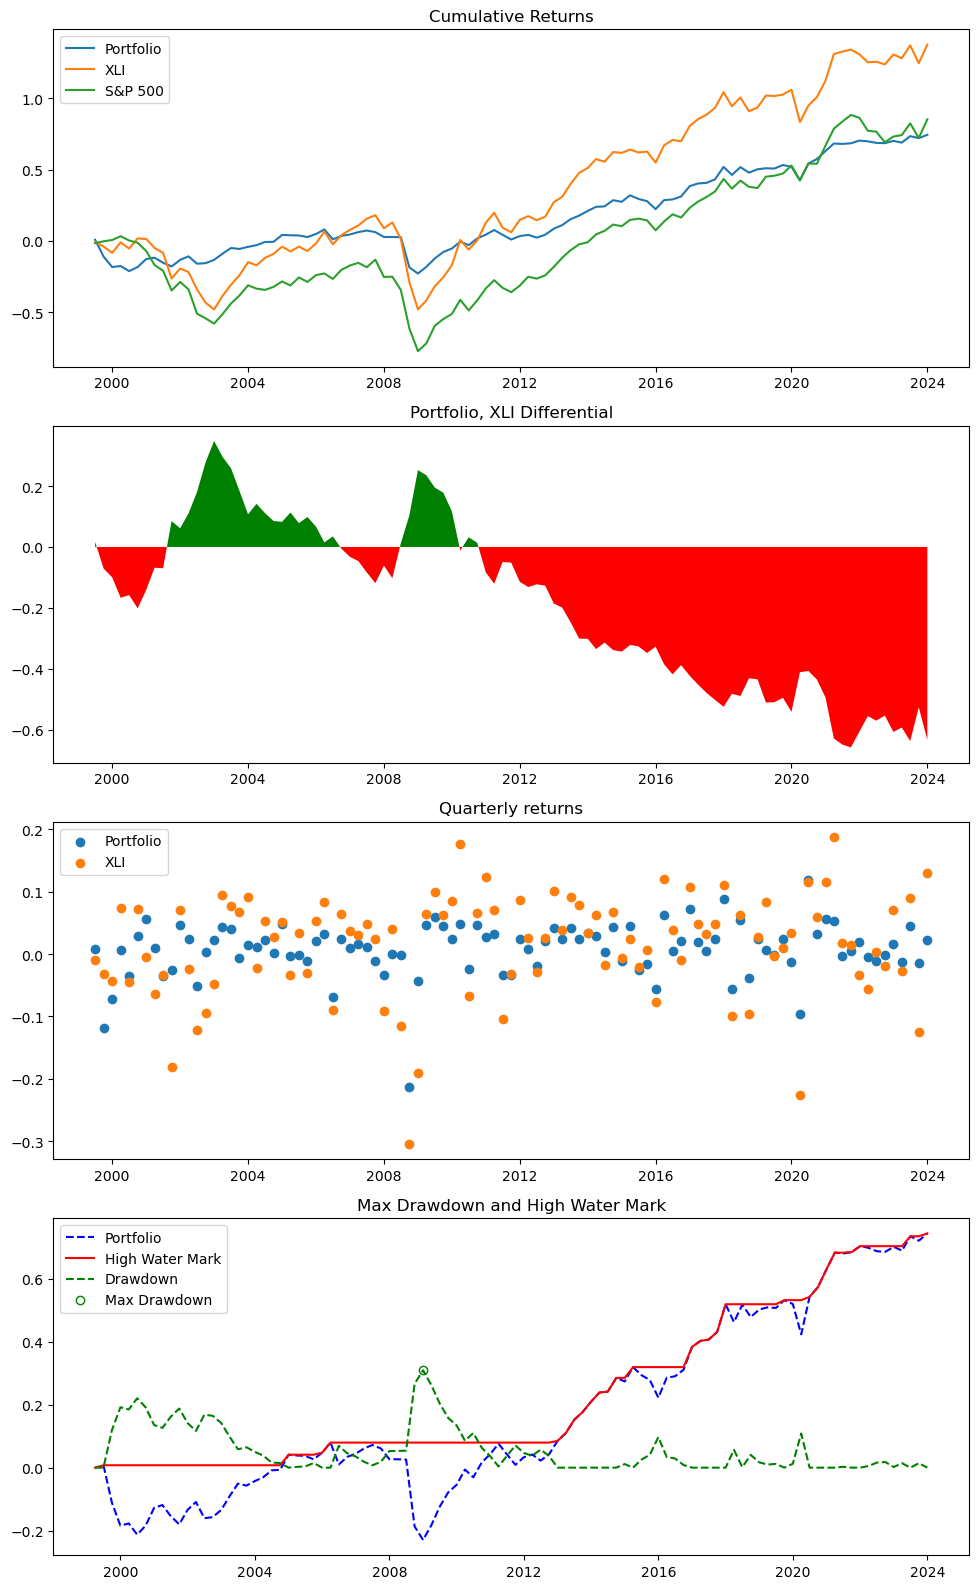

In [198]:
ret_df1 =  calc_return(df1PE, log_returns_3)
metrics_1PE, HWMs_1, mdd_track_1  = calc_metrics(ret_df1)
res = graph(ret_df1, bench_ret, HWMs_1, mdd_track_1)
plt.show()

In [199]:
ret_df1

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01 -0.100239 -0.023272 -0.000000  0.090815  0.087544  0.102256   
1999-10-01 -0.065085  0.211784 -0.001000 -0.107181 -0.137346  0.005682   
2000-01-01 -0.272755  0.021696  0.334305 -0.144810 -0.182824 -0.045162   
2000-04-01 -0.081163 -0.149564  0.037127 -0.151739 -0.145093 -0.125158   
...              ...       ...       ...       ...       ...       ...   
2023-01-01  0.148417  0.000000  0.029854 -0.046110  0.015085  0.000000   
2023-04-01 -0.149971 -0.001000 -0.048053  0.005320 -0.049351 -0.000000   
2023-07-01  0.184507 -0.131365  0.163876 -0.134620 -0.036876  0.000000   
2023-10-01 -0.167975 -0.061826 -0.118627 -0.083635 -0.065464 -0.000000   
2024-01-01  0.276243  0.185848  0.153846  0.106299  0.091545  0.000000   

                 ETN       UPS        DE       ADP  ...      ALLE       ITT  \
Date                                                ...                       
1999-04-01       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1999-07-01  0.069332       NaN -0.120516  0.113771  ...       NaN  0.000000   
1999-10-01 -0.281632       NaN -0.057174  0.173089  ...       NaN -0.001000   
2000-01-01 -0.059788       NaN  0.178065  0.027789  ...       NaN  0.086488   
2000-04-01  0.154146 -0.091832 -0.087992 -0.114993  ...       NaN -0.010480   
...              ...       ...       ...       ...  ...       ...       ...   
2023-01-01  0.071498  0.096890  0.057403  0.074595  ...  0.103671  0.173265   
2023-04-01  0.022435 -0.033236 -0.121231  0.032727  ... -0.070082 -0.090426   
2023-07-01  0.196856  0.036345  0.117877 -0.109484  ...  0.046850  0.155353   
2023-10-01 -0.003205 -0.285551 -0.171753  0.133245  ... -0.181401 -0.075257   
2024-01-01 -0.159568  0.003264  0.065098 -0.113007  ...  0.221592  0.247349   

                 HII       AOS       AAL      PAYC      CHRW       RHI  \
Date                                                                     
1999-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
1999-07-01       NaN  0.136286       NaN       NaN -0.158463  0.090401   
1999-10-01       NaN -0.191606       NaN       NaN -0.056475  0.010966   
2000-01-01       NaN -0.214101       NaN       NaN -0.173545  0.341925   
2000-04-01       NaN  0.031939       NaN       NaN -0.194590  0.444897   
...              ...       ...       ...       ...       ...       ...   
2023-01-01 -0.159298  0.206133  0.000000  0.077305  0.019443  0.087741   
2023-04-01 -0.096170  0.000352 -0.001000  0.121710  0.000813 -0.146206   
2023-07-01  0.123096 -0.052949 -0.193272 -0.227215 -0.013511  0.009540   
2023-10-01 -0.051488  0.049537 -0.420259  0.420992 -0.209158  0.001424   
2024-01-01  0.156188 -0.098396  0.230943  0.263704  0.021780  0.054772   

                GNRC  Portfolio  
Date                             
1999-04-01       NaN        NaN  
1999-07-01       NaN   0.007636  
1999-10-01       NaN  -0.119143  
2000-01-01       NaN  -0.072689  
2000-04-01       NaN   0.006892  
...              ...        ...  
2023-01-01  0.028240   0.015989  
2023-04-01 -0.177659  -0.012141  
2023-07-01  0.393755   0.045610  
2023-10-01  0.616653  -0.014088  
2024-01-01 -0.288680   0.023206  

[100 rows x 78 columns]

In [200]:
df2PE = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

for i in tickers[1:]:
    df2PE[i] = np.where(df2[i] == df2['MEAN PE'], 0, 1)*np.where(df2[i] < df2['MEAN PE'], 1, -1)*np.where(df2[i] == -1, 0, 1)
    
df2PE.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    1  -1    0   -1    1   1    1    0   1   -1  ...   -1     0   
1999-07-01    1   1    0    1    1   1    1    0   1    1  ...    1     0   
1999-10-01    1  -1   -1    1    1   1    1    0   1   -1  ...   -1     0   
2000-01-01    1  -1    1   -1   -1   1    1   -1   1   -1  ...   -1     0   
2000-04-01    1  -1    1    1    1   1    1   -1  -1    1  ...    1     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    1    1     0    -1    1     0  
1999-07-01    0    0    1    1     0     1    1     0  
1999-10-01   -1    0    1    1     0    -1    1     0  
2000-01-01    1    0    1    1     0    -1    1     0  
2000-04-01    1    0    1    1     0     1    1     0  

[5 rows x 77 columns]

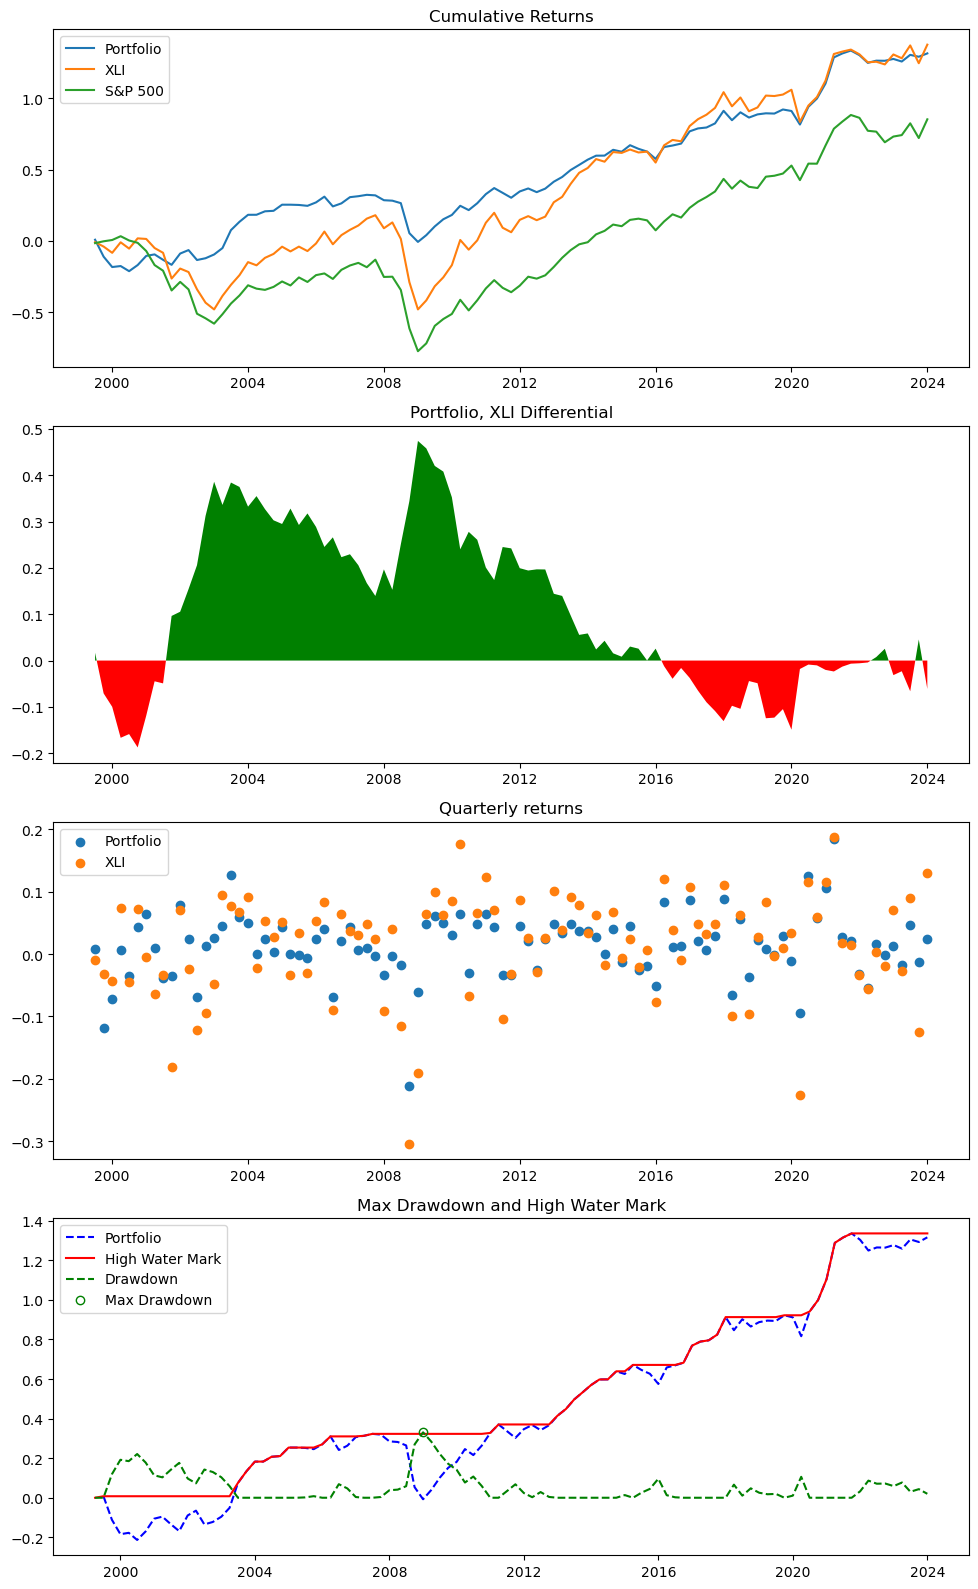

In [201]:
ret_df2 =  calc_return(df2PE, log_returns_3)
metrics_2PE, HWMs_2, mdd_track_2  = calc_metrics(ret_df2)
res = graph(ret_df2, bench_ret, HWMs_2, mdd_track_2)
plt.show()

In [202]:
metrics_2PE

CAT        GE       UNP       RTX       HON  \
Annualized Return     0.032797  0.013866  0.111486  0.049420  0.009261   
Annualized Vol        0.299135  0.292199  0.216196  0.210163  0.267600   
Sharpe Ratio          0.109641  0.047455  0.515670  0.235151  0.034608   
Skewness             -0.609563  0.282200 -0.679139 -0.564323 -0.775118   
Excess Kurtosis       1.148990  2.717544  2.203880  1.259434  3.661780   
High Water Mark       0.857589  1.219219  2.823070  1.420105  0.407166   
Max Drawdown          1.078808  1.158951  0.625556  0.594274  1.371726   
XLI Beta              0.986776  0.598559  0.746059  0.897133  0.823481   
Annualized XLI Alpha -0.022118 -0.019304  0.071093 -0.000007 -0.036473   
S&P Beta              1.076180  0.820072  0.877973  0.884855  0.872161   
Annualized S&P Alpha -0.004301 -0.014263  0.082346  0.019416 -0.020711   

                            BA       ETN       UPS        DE       ADP  ...  \
Annualized Return     0.048762  0.081841  0.038867  0.115702  0.086834  ...   
Annualized Vol        0.345180  0.242084  0.194245  0.267709  0.181767  ...   
Sharpe Ratio          0.141265  0.338069  0.200093  0.432192  0.477720  ...   
Skewness              0.447718 -0.890534  0.615415 -1.056776 -0.582173  ...   
Excess Kurtosis       4.449127  1.315523  3.062045  3.107233  1.287011  ...   
High Water Mark       1.822394  2.208799  1.384826  3.002552  2.283847  ...   
Max Drawdown          2.010108  0.776144  0.442353  0.692360  0.483100  ...   
XLI Beta              0.339031  0.918044  0.292233  0.843139  0.257753  ...   
Annualized XLI Alpha  0.030387  0.031578  0.022997  0.069949  0.073367  ...   
S&P Beta              0.478607  0.963506  0.237196  0.925306  0.250683  ...   
Annualized S&P Alpha  0.032756  0.049454  0.031083  0.084973  0.079069  ...   

                          ALLE       ITT       HII       AOS       AAL  \
Annualized Return    -0.009107  0.090430  0.076360  0.101297 -0.138450   
Annualized Vol        0.126701  0.256648  0.182816  0.278541  0.460980   
Sharpe Ratio         -0.071878  0.352350  0.417687  0.363670 -0.300339   
Skewness              0.004728 -0.292473  0.282014 -0.022457 -0.595865   
Excess Kurtosis       5.187546  0.617858  2.164096 -0.067231  1.932190   
High Water Mark       0.033771  2.260748  1.936667  2.765578  0.759326   
Max Drawdown          0.483040  0.656723  0.555040  1.096780  4.451528   
XLI Beta              0.228223  0.872756  0.420359  0.320992  0.629534   
Annualized XLI Alpha -0.021900  0.042774  0.053738  0.084457 -0.174883   
S&P Beta              0.230774  0.997256  0.375976  0.365772  0.736126   
Annualized S&P Alpha -0.017154  0.056966  0.064170  0.089712 -0.165225   

                          PAYC      CHRW       RHI      GNRC  Portfolio  
Annualized Return    -0.060562 -0.016670  0.029307  0.155787   0.052642  
Annualized Vol        0.272409  0.214021  0.294060  0.378709   0.104750  
Sharpe Ratio         -0.222321 -0.077888  0.099662  0.411362   0.502547  
Skewness              0.125780  0.297162  0.326981  1.249108  -0.565756  
Excess Kurtosis       2.998118  0.082164  0.235612  4.857858   3.287909  
High Water Mark       0.000000  0.000000  1.166821  4.183348   1.335959  
Max Drawdown          3.160111  1.106598  1.259794  1.147555   0.330612  
XLI Beta             -0.244933  0.001486  0.274206  0.267555   0.527901  
Annualized XLI Alpha -0.047543 -0.016921  0.014343  0.142471   0.023795  
S&P Beta             -0.333157  0.046065  0.394710  0.183347   0.572420  
Annualized S&P Alpha -0.049689 -0.018426  0.015996  0.151040   0.033441  

[11 rows x 78 columns]

In [203]:
#df3PE = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

#for i in tickers[1:]:
#    df3PE[i] = np.where(df2[i] == df2['MEAN PE'], 0, 1)*np.where(df2[i] < df2['MEAN PE'], 1, -1)*np.where(df2[i] == -1, 0, 1)
    
df3PE = pd.DataFrame(df2PE.values*target_weight_df.values, index = log_returns_3.index, columns = tickers[1:])
df3PE

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01         0         0         0         0         0         0   
1999-07-01         0         0         0         0         0         0   
1999-10-01     1.265 -0.233423 -0.360128  2.894048   0.19774  0.460472   
2000-01-01  0.315373  -0.28124  0.195612 -1.312268 -0.242747  0.468116   
2000-04-01  1.098497 -0.970681  0.617999  0.788357   0.65473  1.111412   
...              ...       ...       ...       ...       ...       ...   
2023-01-01  1.134605 -1.124441  1.520235 -1.562434  1.213884 -0.948406   
2023-04-01  1.127528 -1.114779  1.518199  1.564012  1.213963 -0.949004   
2023-07-01   1.12539  1.115001  1.512575  1.554415  1.218545 -0.951172   
2023-10-01  1.131862  1.130468  1.520405   1.57025  1.234254 -0.952518   
2024-01-01  1.126228  1.132444  1.525494 -1.580005  1.244733 -0.960864   

                 ETN       UPS        DE       ADP  ...       ROL      ALLE  \
Date                                                ...                       
1999-04-01         0         0         0         0  ...         0         0   
1999-07-01         0         0         0         0  ...         0         0   
1999-10-01  0.126707         0  0.702061 -0.153949  ... -0.464129         0   
2000-01-01  0.197471         0  0.222813 -0.236544  ... -0.705876         0   
2000-04-01  0.558011         0 -0.780509  0.804483  ...  2.241677         0   
...              ...       ...       ...       ...  ...       ...       ...   
2023-01-01  1.369152  1.715346   1.22652 -1.804464  ...  -1.63434  1.816696   
2023-04-01   1.37087  1.715479  1.219695    1.8035  ... -1.627453  1.808172   
2023-07-01 -1.362597  1.723056  1.222562 -1.802631  ... -1.629162  1.829882   
2023-10-01 -1.382344  1.662983  1.226095 -1.802642  ... -1.639169  1.756448   
2024-01-01 -1.387961  1.680226  1.238213  1.811722  ... -1.648376  1.689174   

                 ITT       HII       AOS       AAL      PAYC      CHRW  \
Date                                                                     
1999-04-01         0         0         0         0         0         0   
1999-07-01         0         0         0         0         0         0   
1999-10-01  -0.34996         0  0.135623         0         0 -0.208839   
2000-01-01  0.495761         0   0.17873         0         0 -0.274207   
2000-04-01  1.727193         0  0.617961         0         0  0.911735   
...              ...       ...       ...       ...       ...       ...   
2023-01-01  1.296329  1.294636  1.162649   0.60325 -0.844474  1.583741   
2023-04-01  1.292083  1.288257 -1.163869 -0.603483 -0.838958  1.585179   
2023-07-01  1.291053   1.29453 -1.168977  0.605006 -0.844371  1.591071   
2023-10-01  1.305614  1.313832 -1.184237  0.605288 -0.791536  1.572481   
2024-01-01  1.299097  1.321735 -1.194854  0.609255 -0.779115  1.588576   

                 RHI      GNRC  
Date                            
1999-04-01         0         0  
1999-07-01         0         0  
1999-10-01  0.559823         0  
2000-01-01  0.202884         0  
2000-04-01   0.51674         0  
...              ...       ...  
2023-01-01  1.106923  0.664931  
2023-04-01  1.101118  0.663507  
2023-07-01  1.106092 -0.656836  
2023-10-01  1.122297 -0.628498  
2024-01-01  1.133428 -0.632299  

[100 rows x 77 columns]

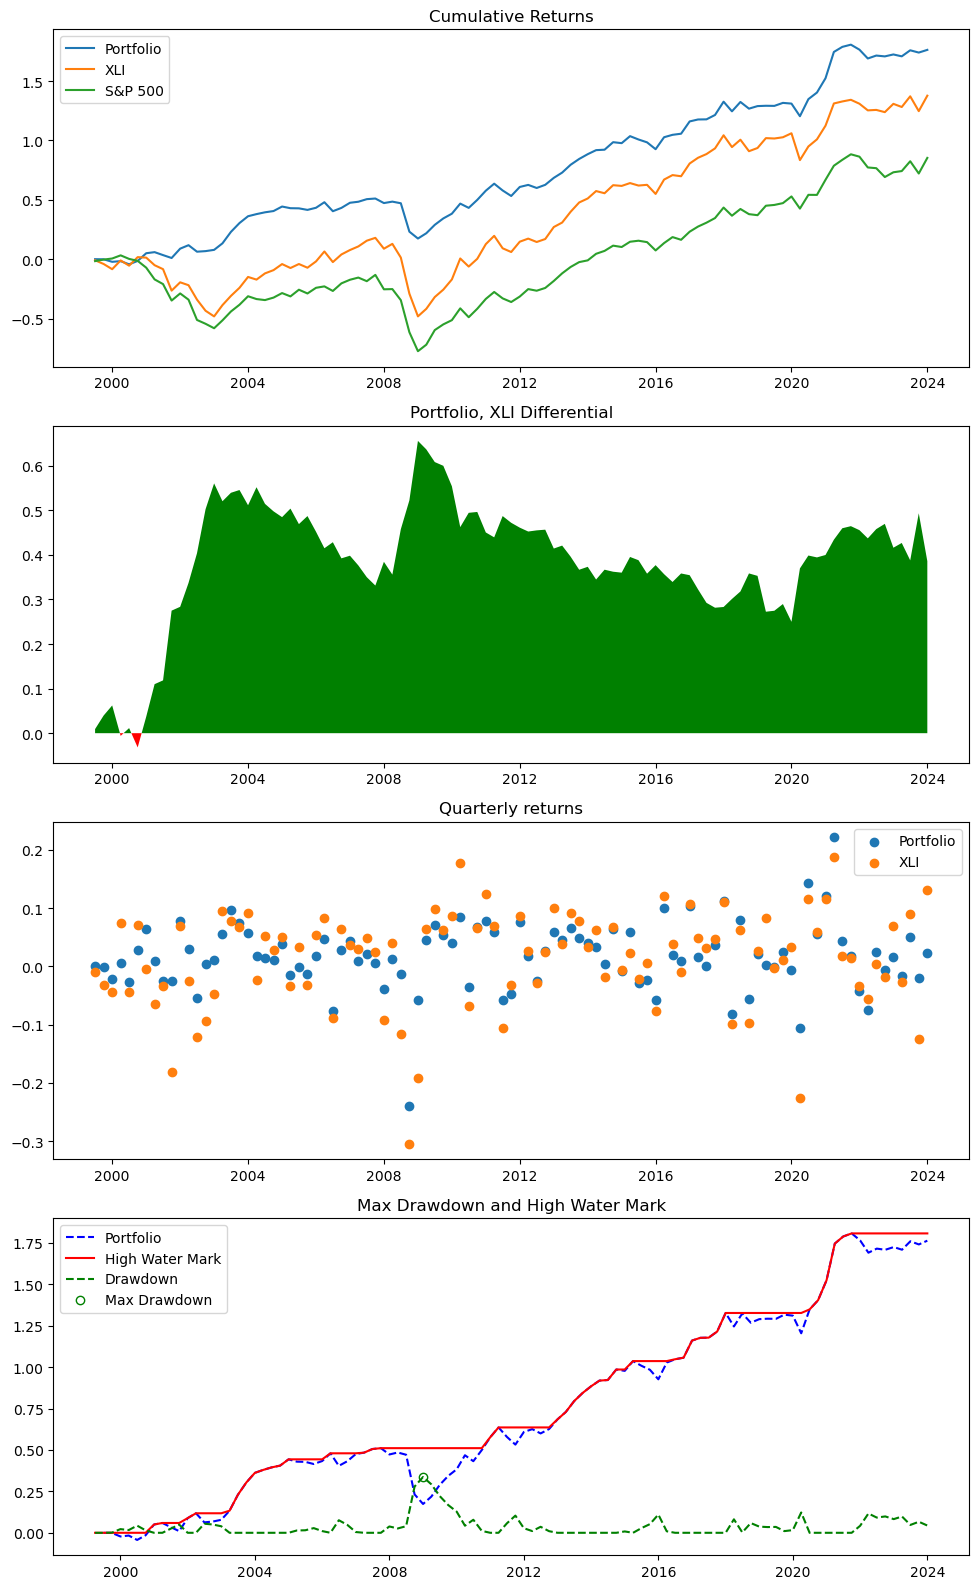

In [204]:
ret_df3 =  calc_return(df3PE, log_returns_3)
metrics_3PE, HWMs_3, mdd_track_3  = calc_metrics(ret_df3)
res = graph(ret_df3, bench_ret, HWMs_3, mdd_track_3)
vol_plot = ret_df3
plt.show()

In [205]:
metrics_3PE['Portfolio'].to_frame()

Portfolio
Annualized Return      0.070530
Annualized Vol         0.114398
Sharpe Ratio           0.616537
Skewness              -0.463787
Excess Kurtosis        4.125103
High Water Mark        1.807136
Max Drawdown           0.337001
XLI Beta               0.593904
Annualized XLI Alpha   0.038192
S&P Beta               0.657496
Annualized S&P Alpha   0.048578

# The 3 Momentum Strategies

In [206]:
df1mom = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

log_returns_filled = log_returns_3.replace(np.nan, 0)

for i in tickers[1:]:
    df1mom[i] =  np.where(log_returns_filled[i] > 0, 1, -1)*np.where(log_returns_filled[i] == 0, 0, 1)
    
df1mom.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-07-01   -1   1   -1   -1    1   1    1    0  -1   -1  ...    1     0   
1999-10-01   -1   1    1   -1   -1   1   -1    0  -1    1  ...   -1     0   
2000-01-01   -1  -1   -1   -1   -1  -1   -1    0   1   -1  ...   -1     0   
2000-04-01   -1   1    1    1    1  -1    1    1  -1    1  ...   -1     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    0    0     0     0    0     0  
1999-07-01    1    0    1    0     0     1    1     0  
1999-10-01   -1    0   -1    0     0    -1    1     0  
2000-01-01   -1    0   -1    0     0     1    1     0  
2000-04-01   -1    0    1    0     0     1    1     0  

[5 rows x 77 columns]

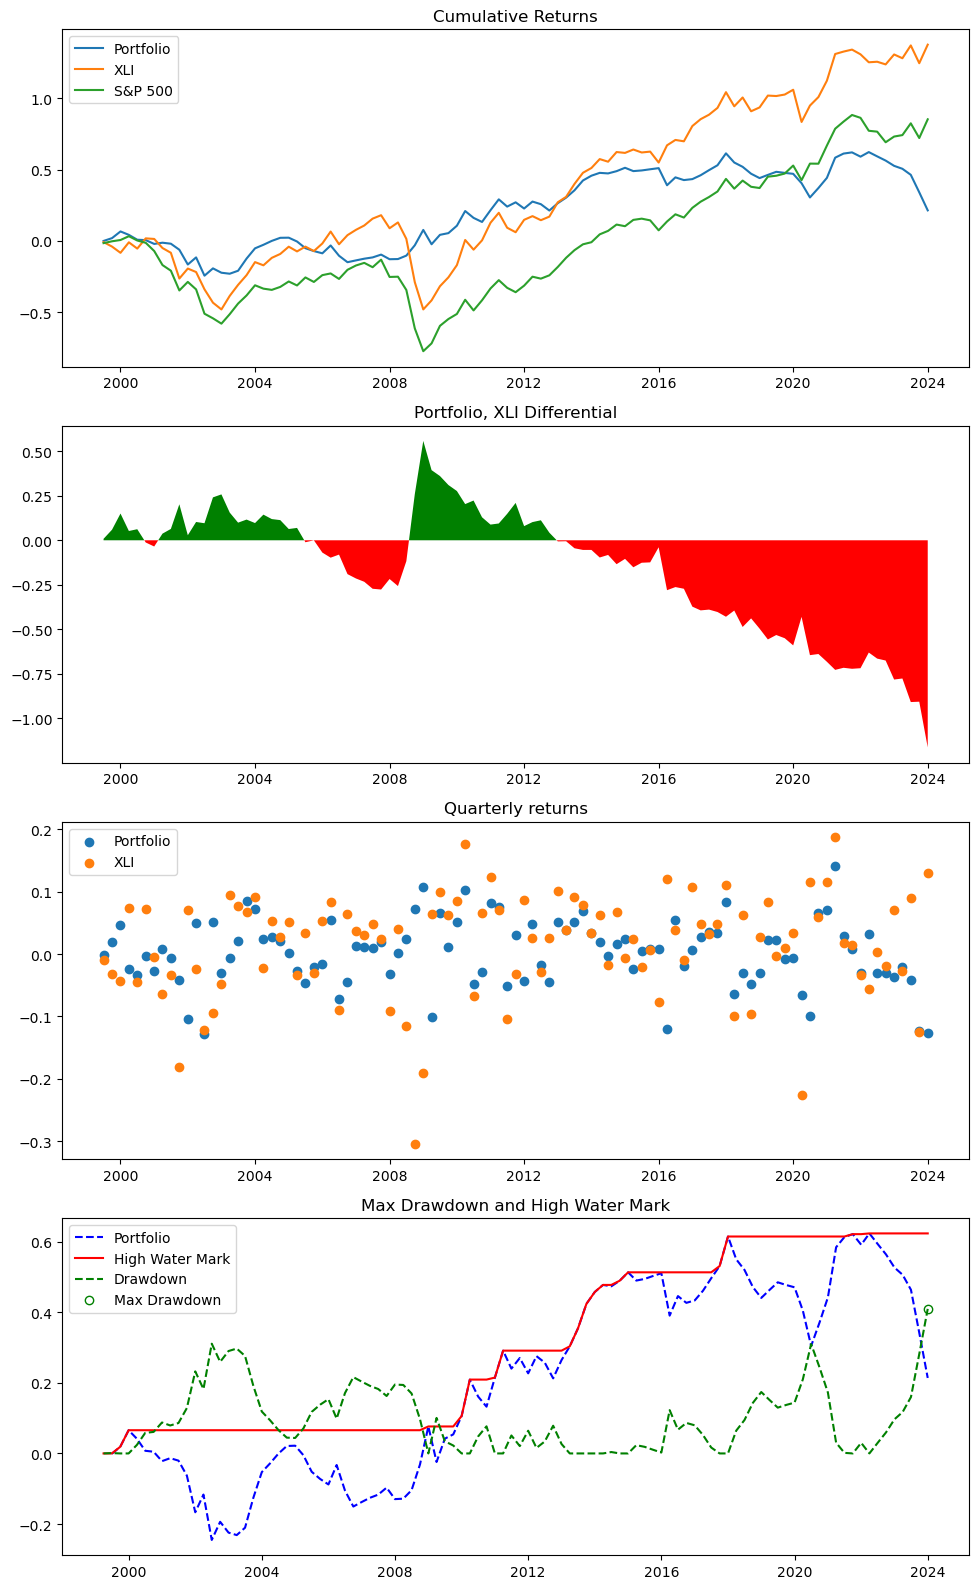

In [207]:
ret_df1 =  calc_return(df1mom, log_returns_3)
metrics_1mom, HWMs_1, mdd_track_1  = calc_metrics(ret_df1)
res = graph(ret_df1, bench_ret, HWMs_1, mdd_track_1)
vol_plot_1 = ret_df1
plt.show()

In [208]:
df2mom = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

annual_returns_filled = annual_log_returns.replace(np.nan, 0)

for i in tickers[1:]:
    df2mom[i] =  np.where(annual_returns_filled[i] > 0, 1, -1)*np.where(annual_returns_filled[i] == 0, 0, 1)
    
df2mom.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-07-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-10-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
2000-01-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
2000-04-01   -1   1   -1   -1   -1  -1   -1    0  -1    1  ...   -1     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    0    0     0     0    0     0  
1999-07-01    0    0    0    0     0     0    0     0  
1999-10-01    0    0    0    0     0     0    0     0  
2000-01-01    0    0    0    0     0     0    0     0  
2000-04-01   -1    0   -1    0     0     1    1     0  

[5 rows x 77 columns]

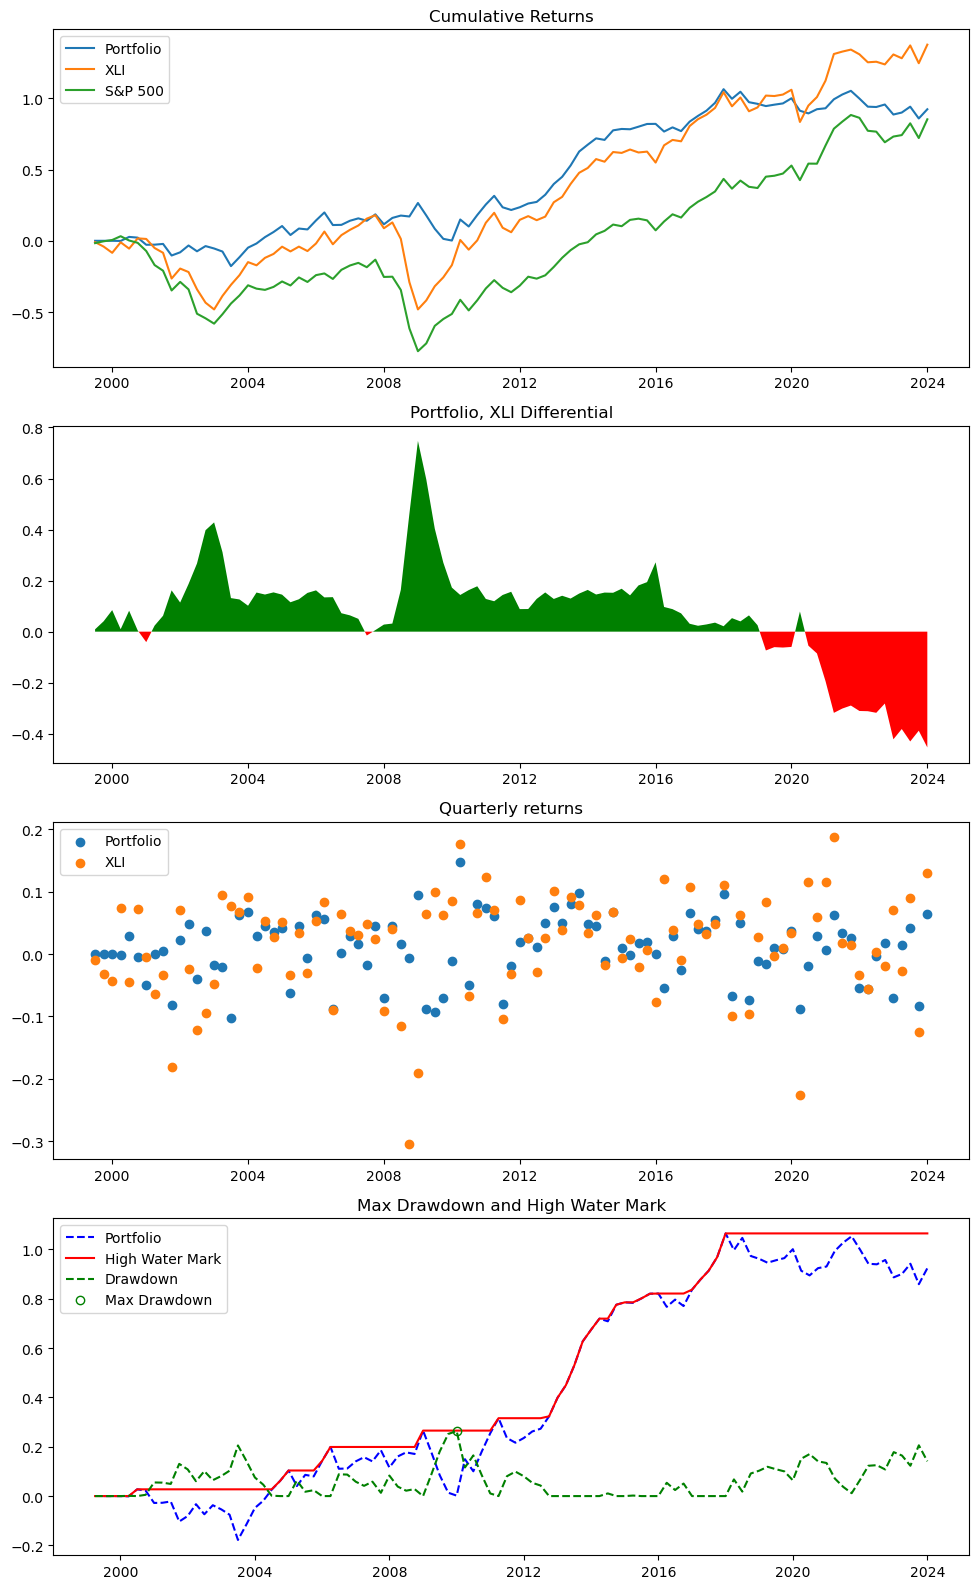

In [209]:
ret_df2 =  calc_return(df2mom, log_returns_3)
metrics_2mom, HWMs_2, mdd_track_2  = calc_metrics(ret_df2)
res = graph(ret_df2, bench_ret, HWMs_2, mdd_track_2)
vol_plot_2 = ret_df2
plt.show()

In [210]:
#Bad strat, maybe because return mean may be skewed by ipo's and such
df3mom = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

annual_returns_filled = annual_log_returns.replace(np.nan, 0)

for i in tickers[1:]:
    df3mom[i] =  np.where(annual_returns_filled[i] > annual_returns_filled['Mean'], 1, -1)*np.where(annual_returns_filled[i] == annual_returns_filled['Mean'], 0, 1)
    
df3mom.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-07-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-10-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
2000-01-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
2000-04-01   -1   1   -1   -1    1   1    1    1   1    1  ...   -1     1   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    0    0     0     0    0     0  
1999-07-01    0    0    0    0     0     0    0     0  
1999-10-01    0    0    0    0     0     0    0     0  
2000-01-01    0    0    0    0     0     0    0     0  
2000-04-01   -1    1   -1    1     1     1    1     1  

[5 rows x 77 columns]

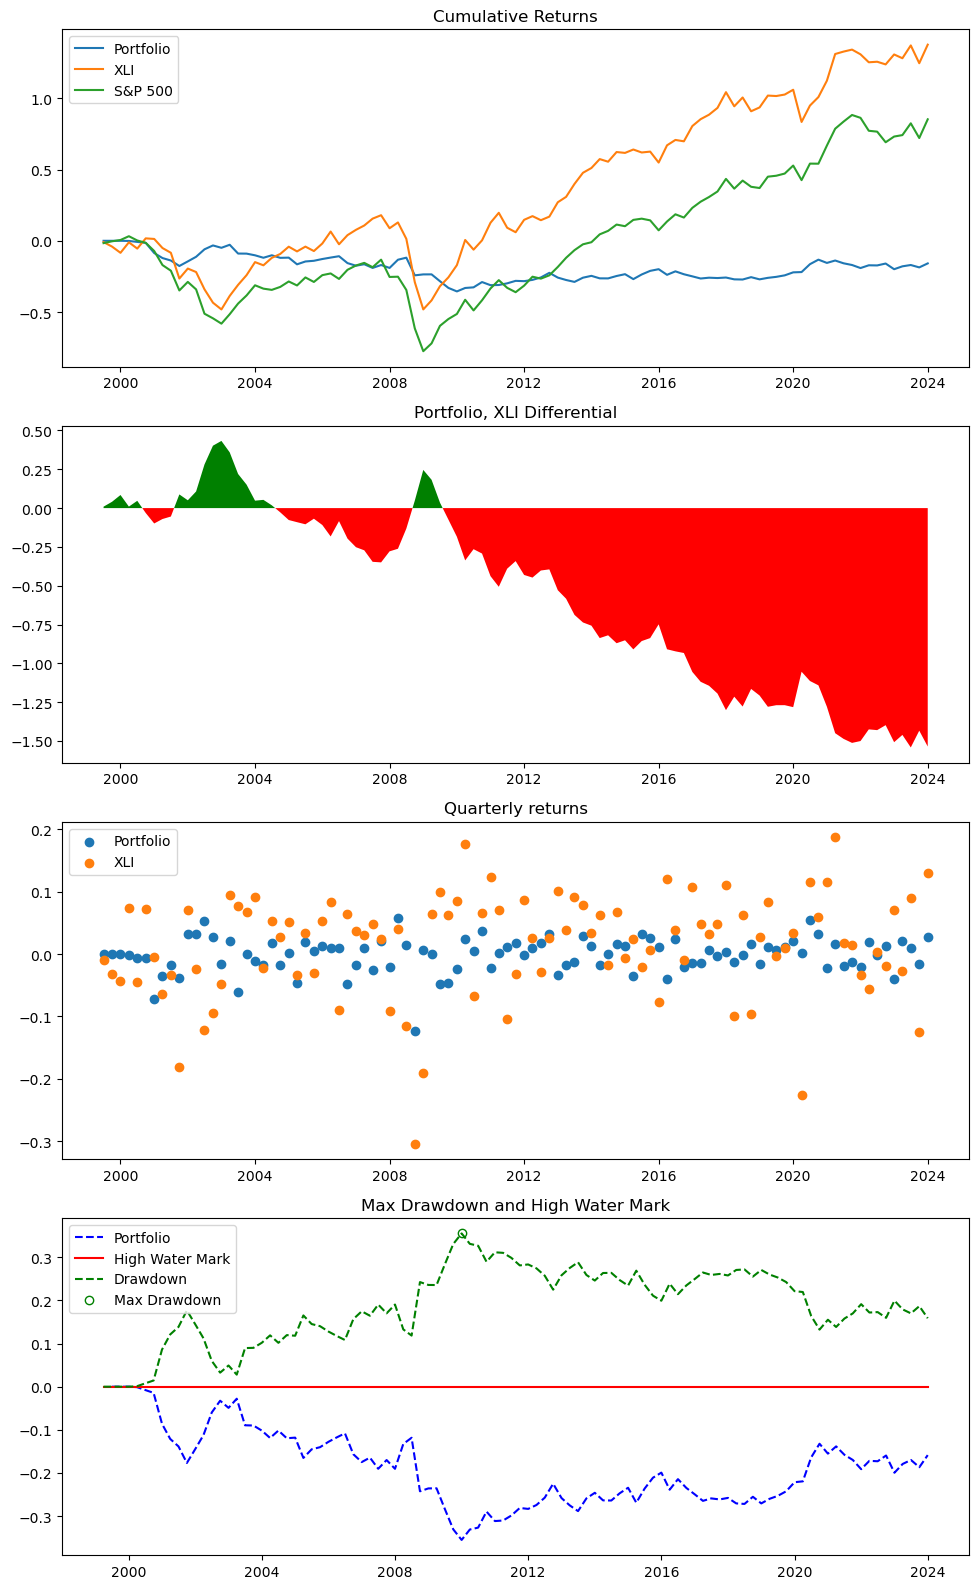

In [211]:
ret_df3 =  calc_return(df3mom, log_returns_3)
metrics_3mom, HWMs_3, mdd_track_3  = calc_metrics(ret_df3)
res = graph(ret_df3, bench_ret, HWMs_3, mdd_track_3)
plt.show()

In [212]:
df4mom = pd.DataFrame(df2mom.values*target_weight_df.values, index = log_returns_3.index, columns = tickers[1:])
df4mom.head(6)

CAT        GE       UNP       RTX       HON        BA  \
Date                                                                     
1999-04-01         0         0         0         0         0         0   
1999-07-01         0         0         0         0         0         0   
1999-10-01       0.0       0.0       0.0       0.0       0.0       0.0   
2000-01-01       0.0       0.0       0.0       0.0       0.0       0.0   
2000-04-01 -1.098497  0.970681 -0.617999 -0.788357  -0.65473 -1.111412   
2000-07-01 -1.175331  0.910607 -0.631983 -0.845608 -0.380887  0.788588   

                 ETN  UPS        DE       ADP  ...       ROL ALLE       ITT  \
Date                                           ...                            
1999-04-01         0    0         0         0  ...         0    0         0   
1999-07-01         0    0         0         0  ...         0    0         0   
1999-10-01       0.0    0       0.0       0.0  ...       0.0    0       0.0   
2000-01-01       0.0    0       0.0       0.0  ...       0.0    0       0.0   
2000-04-01 -0.558011    0 -0.780509  0.804483  ... -2.241677    0 -1.727193   
2000-07-01 -0.532055  0.0  0.834942  0.770199  ...  -1.72962    0 -1.594108   

           HII       AOS AAL PAYC      CHRW       RHI GNRC  
Date                                                        
1999-04-01   0         0   0    0         0         0    0  
1999-07-01   0         0   0    0         0         0    0  
1999-10-01   0       0.0   0    0       0.0       0.0    0  
2000-01-01   0       0.0   0    0       0.0       0.0    0  
2000-04-01   0 -0.617961   0    0  0.911735   0.51674    0  
2000-07-01   0 -0.576468   0    0  0.879159  0.533609    0  

[6 rows x 77 columns]

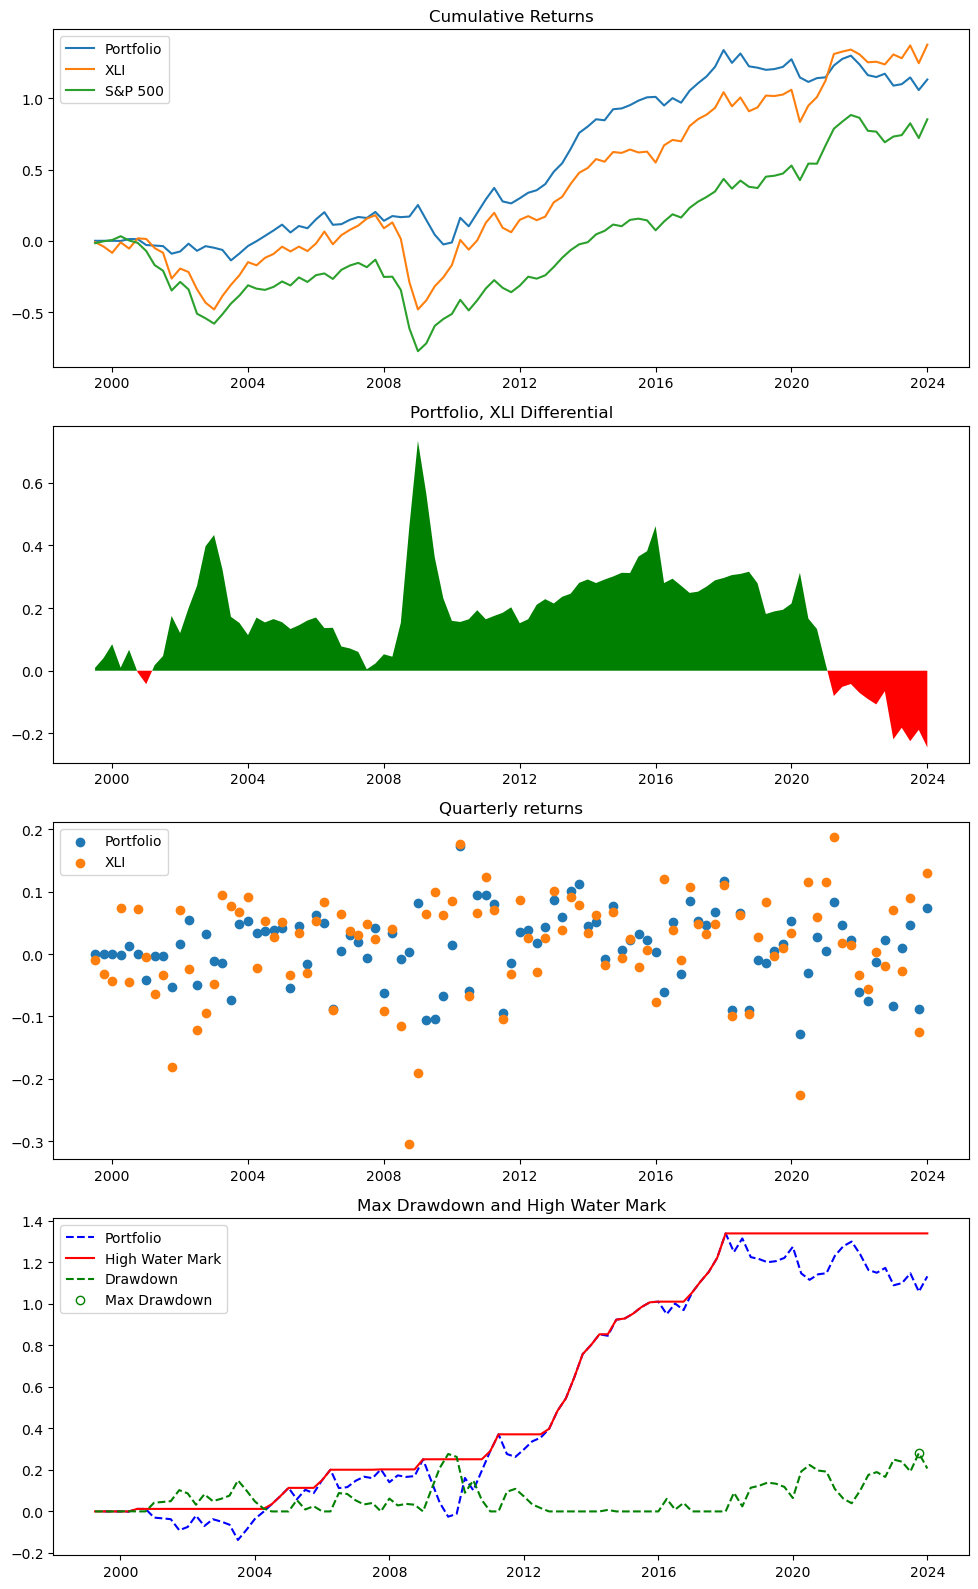

In [213]:
ret_df4 =  calc_return(df4mom, log_returns_3)
metrics_4mom, HWMs_4, mdd_track_4  = calc_metrics(ret_df4)
res = graph(ret_df4, bench_ret, HWMs_4, mdd_track_4)
plt.show()

In [214]:
metrics_4mom

CAT        GE       UNP       RTX       HON  \
Annualized Return     0.050076  0.061896  0.064946 -0.001488  0.046226   
Annualized Vol        0.304858  0.358336  0.307591  0.297588  0.203907   
Sharpe Ratio          0.164261  0.172732  0.211143 -0.005001  0.226702   
Skewness              0.535060 -0.378696 -0.762656 -1.038673  0.617199   
Excess Kurtosis       0.997947  3.893201  2.784771  1.764418  2.061867   
High Water Mark       1.239386  3.337470  2.131500  1.465480  2.446691   
Max Drawdown          0.787668  2.292563  1.459982  1.532879  1.291036   
XLI Beta              0.133688 -0.134478  0.760423  0.177982  0.171220   
Annualized XLI Alpha  0.042636  0.070005  0.023284 -0.011408  0.037165   
S&P Beta              0.071958 -0.200747  0.916298 -0.007319  0.075242   
Annualized S&P Alpha  0.047596  0.069441  0.034015 -0.001251  0.044099   

                            BA       ETN       UPS        DE       ADP  ...  \
Annualized Return     0.016588  0.101351 -0.033875  0.060153  0.095261  ...   
Annualized Vol        0.325771  0.260218  0.371718  0.321693  0.260099  ...   
Sharpe Ratio          0.050920  0.389486 -0.091130  0.186989  0.366248  ...   
Skewness              1.340620  0.185328 -0.596184 -0.643566 -0.012126  ...   
Excess Kurtosis       7.167003  0.518423  4.353718  1.608468  0.055210  ...   
High Water Mark       1.753808  2.533781  0.543585  2.022398  3.094304  ...   
Max Drawdown          1.441862  0.637833  1.992405  1.129731  0.748452  ...   
XLI Beta             -0.157278  0.373695  0.098152  0.909789  0.229689  ...   
Annualized XLI Alpha  0.025508  0.081579 -0.039679  0.010130  0.083441  ...   
S&P Beta             -0.074932  0.371520 -0.104658  0.978307  0.218963  ...   
Annualized S&P Alpha  0.019339  0.089568 -0.030609  0.027037  0.088675  ...   

                           ALLE       ITT       HII       AOS       AAL  \
Annualized Return      0.012544 -0.048970  0.049310  0.087596  0.017170   
Annualized Vol         0.360276  0.380207  0.229075  0.262396  0.245349   
Sharpe Ratio           0.034817 -0.128797  0.215256  0.333831  0.069981   
Skewness               2.296162 -0.487112 -0.536292 -0.134803  0.119054   
Excess Kurtosis       17.685810  0.922833  3.880847  0.179958  3.599245   
High Water Mark        2.457511  0.677905  2.349823  2.856314  1.373968   
Max Drawdown           2.143914  2.584776  1.117080  0.871639  0.944725   
XLI Beta               0.232079  0.821449  0.178422  0.450474 -0.243404   
Annualized XLI Alpha  -0.000245 -0.095179  0.039878  0.063411  0.030889   
S&P Beta               0.301815  1.021199  0.036240  0.472771 -0.228777   
Annualized S&P Alpha   0.002266 -0.084667  0.048559  0.072183  0.025230   

                          PAYC      CHRW       RHI      GNRC  Portfolio  
Annualized Return     0.089857  0.031591  0.025224  0.098446   0.045303  
Annualized Vol        0.233102  0.271756  0.251303  0.311281   0.113255  
Sharpe Ratio          0.385482  0.116247  0.100373  0.316260   0.400005  
Skewness             -0.464099 -0.399453 -0.355290  1.155915  -0.236146  
Excess Kurtosis       5.283681  0.704669  0.408658  5.445593  -0.055654  
High Water Mark       2.549502  1.283499  0.882642  2.643579   1.339472  
Max Drawdown          0.510819  0.857985  0.947454  0.840005   0.280974  
XLI Beta              0.318601 -0.065162 -0.150124  0.108819   0.328643  
Annualized XLI Alpha  0.073034  0.035536  0.033834  0.093384   0.027471  
S&P Beta              0.405148 -0.040835 -0.283520  0.027952   0.343931  
Annualized S&P Alpha  0.076798  0.033318  0.035252  0.098477   0.033904  

[11 rows x 78 columns]

# The Combo Strategies

In [215]:
df1combo = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

log_returns_filled = log_returns_3.replace(np.nan, 0)

for i in tickers[1:]:
    df1combo[i] =  np.where(df1[i] == df1['MEAN PE'], 0, 1)*np.where((df1[i] < df1['MEAN PE']),1,0)*np.where(log_returns_filled[i] > 0*log_returns_filled['Mean'], 1, 0)*np.where(df1[i] == -1, 0, 1)*np.where(log_returns_filled[i] == 0, 0, 1) + np.where(df1[i] == df1['MEAN PE'], 0, 1)*np.where((df1[i] > df1['MEAN PE']),-1,0)*np.where(log_returns_filled[i] < 0*log_returns_filled['Mean'], 1, 0)*np.where(df1[i] == -1, 0, 1)*np.where(log_returns_filled[i] == 0, 0, 1)
    
df1combo.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-07-01    0   1    0    0    1   1    1    0   0    0  ...    1     0   
1999-10-01    0   0    0    0    0   1    0    0   0    0  ...   -1     0   
2000-01-01    0  -1    0   -1   -1   0    0    0   1   -1  ...   -1     0   
2000-04-01    0   0    1    1    1   0    1    0  -1    1  ...    0     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    0    0     0     0    0     0  
1999-07-01    0    0    1    0     0     1    1     0  
1999-10-01   -1    0    0    0     0    -1    1     0  
2000-01-01    0    0    0    0     0     0    1     0  
2000-04-01    0    0    1    0     0     1    1     0  

[5 rows x 77 columns]

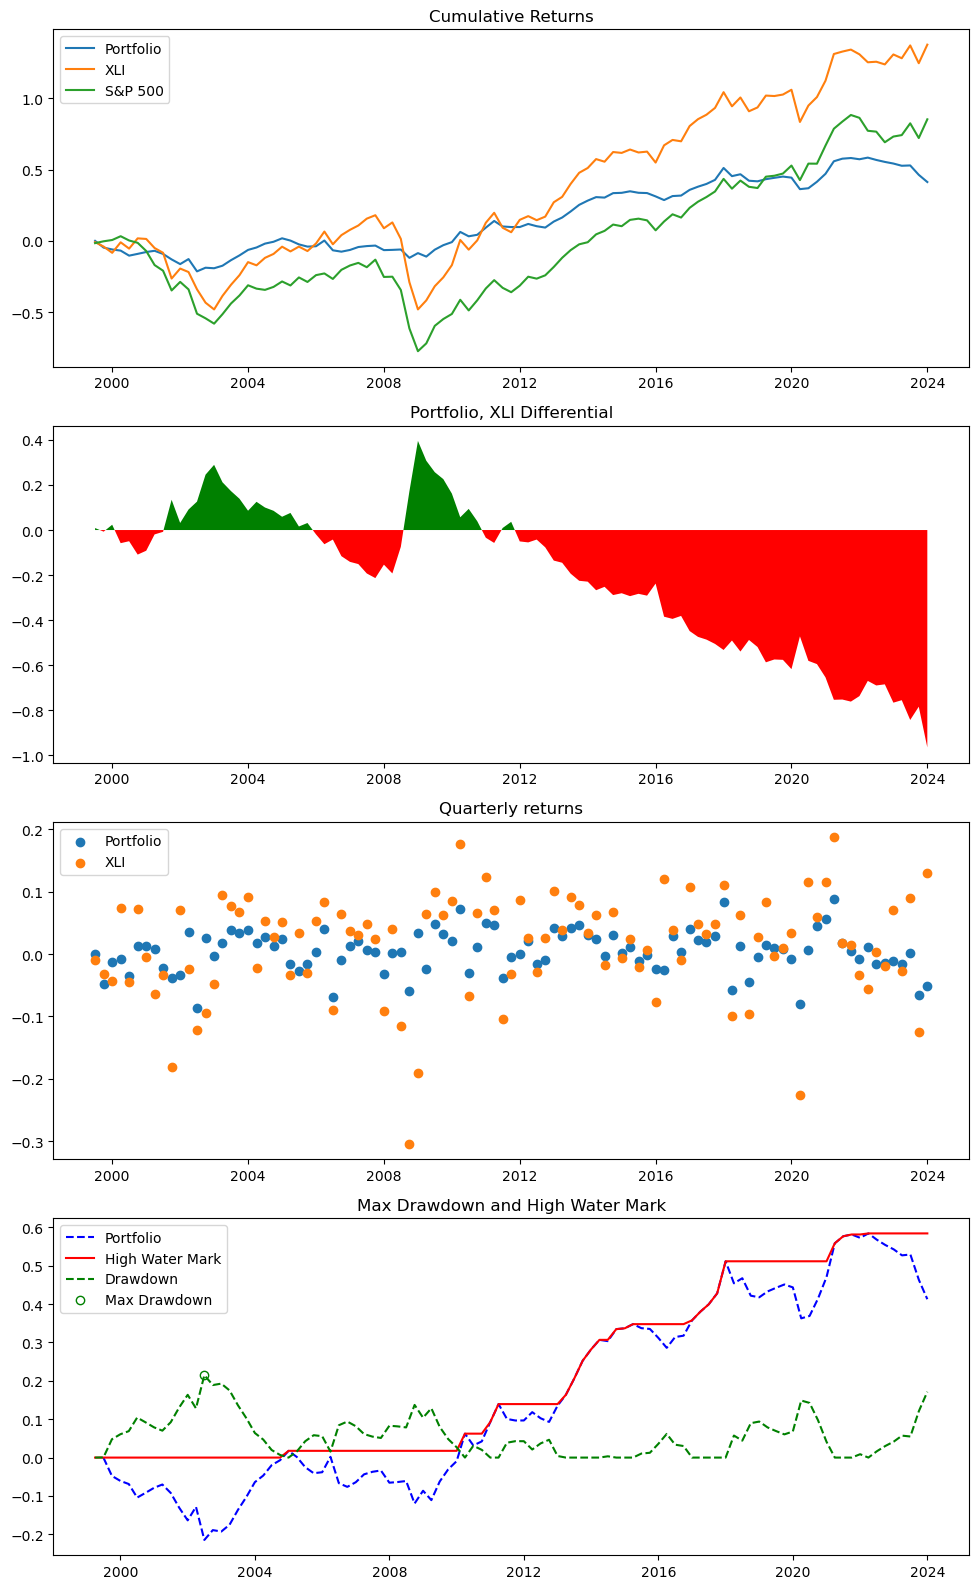

In [216]:
ret_df1 =  calc_return(df1combo, log_returns_3)
metrics_1combo, HWMs_1, mdd_track_1  = calc_metrics(ret_df1)
res = graph(ret_df1, bench_ret, HWMs_1, mdd_track_1)
plt.show()

In [217]:
metrics_1combo

CAT        GE       UNP       RTX       HON  \
Annualized Return     0.043251  0.050687  0.038983  0.007594 -0.026202   
Annualized Vol        0.192689  0.173729  0.142091  0.142629  0.201620   
Sharpe Ratio          0.224459  0.291757  0.274355  0.053244 -0.129957   
Skewness             -0.066594  0.979914 -0.096528 -1.483086 -1.155175   
Excess Kurtosis       0.962634  3.351981  1.973919  7.267360  6.080685   
High Water Mark       1.392404  1.331994  1.187259  1.044768  0.000000   
Max Drawdown          0.366904  0.539058  0.639190  0.854914  1.710032   
XLI Beta              0.369868  0.313414  0.402906  0.369054  0.400167   
Annualized XLI Alpha  0.022667  0.033757  0.016955 -0.012867 -0.048736   
S&P Beta              0.372177  0.371844  0.433391  0.330589  0.403265   
Annualized S&P Alpha  0.030421  0.038381  0.024437 -0.003725 -0.040368   

                             BA       ETN       UPS        DE       ADP  ...  \
Annualized Return      0.090927  0.062223 -0.015223  0.051629 -0.028936  ...   
Annualized Vol         0.235777  0.184602  0.133682  0.201740  0.137567  ...   
Sharpe Ratio           0.385650  0.337067 -0.113876  0.255919 -0.210340  ...   
Skewness               3.192584 -0.388689 -0.716476  0.214578 -0.794130  ...   
Excess Kurtosis       19.078473  1.203522  4.616507  0.500700  2.189229  ...   
High Water Mark        2.273183  1.555582  0.415696  1.651075  0.000000  ...   
Max Drawdown           0.392138  0.510322  0.796277  0.595150  0.833412  ...   
XLI Beta              -0.004075  0.508366 -0.038327  0.448346  0.076923  ...   
Annualized XLI Alpha   0.092073  0.034561 -0.013244  0.027200 -0.033509  ...   
S&P Beta               0.049424  0.466725 -0.100882  0.424341  0.124496  ...   
Annualized S&P Alpha   0.090142  0.046763 -0.011899  0.037523 -0.033520  ...   

                           ALLE       ITT       HII       AOS        AAL  \
Annualized Return     -0.022405  0.013100  0.050868  0.067617  -0.008472   
Annualized Vol         0.088480  0.193515  0.145897  0.212306   0.162809   
Sharpe Ratio          -0.253222  0.067693  0.348658  0.318490  -0.052034   
Skewness              -2.301837 -0.404699  0.668409 -0.100903   1.192297   
Excess Kurtosis       12.279867  3.492267  7.113796  1.012705  24.473952   
High Water Mark        0.123862  0.948249  1.486489  2.210604   0.810732   
Max Drawdown           0.683989  1.183707  0.342768  0.542119   1.022520   
XLI Beta               0.104820  0.494086  0.261837  0.325343   0.034095   
Annualized XLI Alpha  -0.028465 -0.014264  0.036810  0.050195  -0.010455   
S&P Beta               0.080661  0.541985  0.202199  0.402041  -0.002853   
Annualized S&P Alpha  -0.025412 -0.005451  0.044412  0.054441  -0.008459   

                           PAYC      CHRW       RHI      GNRC  Portfolio  
Annualized Return     -0.035782 -0.034683  0.049195 -0.011417   0.016508  
Annualized Vol         0.142097  0.132303  0.226523  0.184478   0.066041  
Sharpe Ratio          -0.251816 -0.262149  0.217174 -0.061890   0.249960  
Skewness              -2.219070 -0.235845  0.659505  0.273403  -0.294277  
Excess Kurtosis       13.623076  3.131152  2.957494  6.551577   0.349104  
High Water Mark        0.000000  0.000000  1.495002  0.381463   0.584163  
Max Drawdown           1.158263  0.916822  1.405229  0.903748   0.214636  
XLI Beta              -0.040084  0.021762  0.263910 -0.002043   0.262120  
Annualized XLI Alpha  -0.033913 -0.036244  0.035005 -0.011419   0.002087  
S&P Beta              -0.068946  0.019189  0.289746 -0.091140   0.269726  
Annualized S&P Alpha  -0.033767 -0.035695  0.039704 -0.008391   0.007376  

[11 rows x 78 columns]

In [218]:
df2combo = pd.DataFrame(index = log_returns_3.index, columns = tickers[1:])

annual_returns_filled = annual_log_returns.replace(np.nan, 0)

for i in tickers[1:]:
    df2combo[i] =  np.where(df1[i] == df1['MEAN PE'], 0, 1)*np.where((df1[i] < df1['MEAN PE']),1,0)*np.where(annual_returns_filled[i] > 0*annual_returns_filled['Mean'], 1, 0)*np.where(df1[i] == -1, 0, 1)*np.where(annual_returns_filled[i] == 0, 0, 1) + np.where(df1[i] == df1['MEAN PE'], 0, 1)*np.where((df1[i] > df1['MEAN PE']),-1,0)*np.where(annual_returns_filled[i] < 0*annual_returns_filled['Mean'], 1, 0)*np.where(df1[i] == -1, 0, 1)*np.where(annual_returns_filled[i] == 0, 0, 1)
    
df2combo.head()

CAT  GE  UNP  RTX  HON  BA  ETN  UPS  DE  ADP  ...  ROL  ALLE  \
Date                                                       ...              
1999-04-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-07-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
1999-10-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
2000-01-01    0   0    0    0    0   0    0    0   0    0  ...    0     0   
2000-04-01    0   0    0    0    0   0    0    0  -1    1  ...    0     0   

            ITT  HII  AOS  AAL  PAYC  CHRW  RHI  GNRC  
Date                                                   
1999-04-01    0    0    0    0     0     0    0     0  
1999-07-01    0    0    0    0     0     0    0     0  
1999-10-01    0    0    0    0     0     0    0     0  
2000-01-01    0    0    0    0     0     0    0     0  
2000-04-01    0    0    0    0     0     1    1     0  

[5 rows x 77 columns]

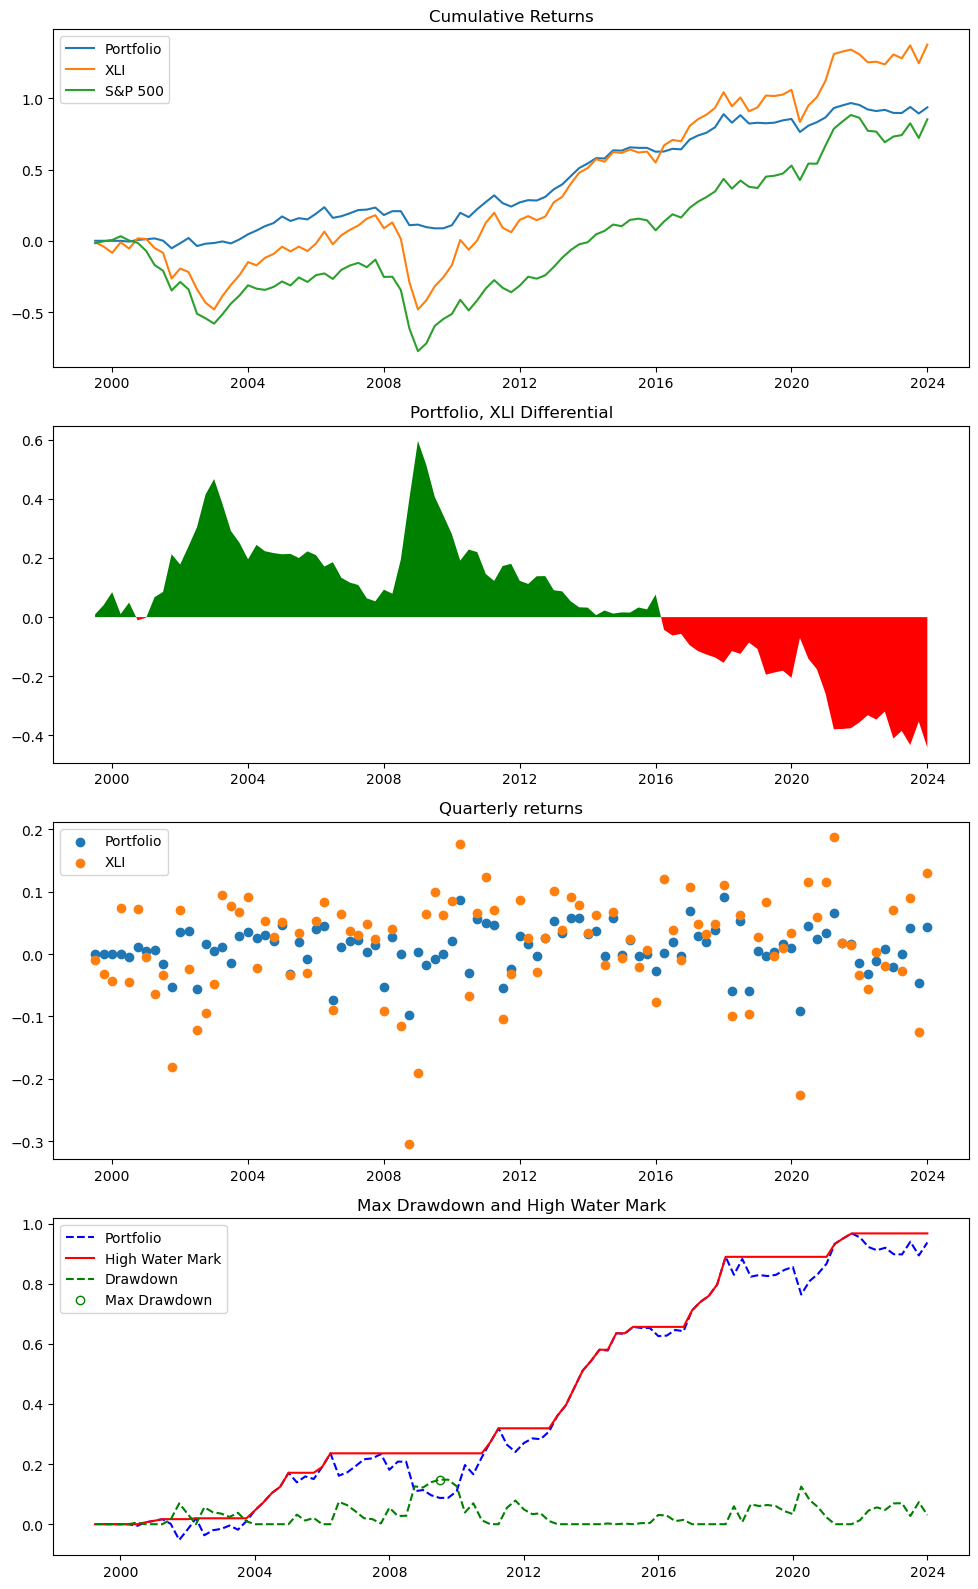

In [219]:
ret_df2 =  calc_return(df2combo, log_returns_3)
metrics_2combo, HWMs_2, mdd_track_2  = calc_metrics(ret_df2)
res = graph(ret_df2, bench_ret, HWMs_2, mdd_track_2)
plt.show()

In [220]:
metrics_2combo

CAT        GE       UNP       RTX       HON  \
Annualized Return     0.037537  0.052087  0.070593  0.000631  0.033298   
Annualized Vol        0.192006  0.127463  0.181075  0.164716  0.158751   
Sharpe Ratio          0.195501  0.408647  0.389857  0.003831  0.209748   
Skewness              0.052522  1.090770 -0.908203 -1.663518  0.098512   
Excess Kurtosis       1.100801  3.075120  4.262047  5.344047  2.107357   
High Water Mark       0.929049  1.302179  1.948431  1.070452  1.463576   
Max Drawdown          0.515159  0.218070  0.627556  1.054675  0.631133   
XLI Beta              0.490228  0.228992  0.643528  0.427533  0.444797   
Annualized XLI Alpha  0.010256  0.039870  0.035493 -0.023155  0.008881   
S&P Beta              0.509004  0.246034  0.752819  0.365660  0.438585   
Annualized S&P Alpha  0.019991  0.044132  0.045355 -0.011968  0.018515   

                             BA       ETN       UPS        DE       ADP  ...  \
Annualized Return      0.082265  0.075865 -0.002355  0.072077  0.017396  ...   
Annualized Vol         0.253111  0.166423  0.133842  0.238079  0.097956  ...   
Sharpe Ratio           0.325015  0.455855 -0.017593  0.302743  0.177594  ...   
Skewness               1.686965 -0.126538  0.432642 -1.200089 -0.139924  ...   
Excess Kurtosis       18.606728  0.799021  4.242646  5.898799  3.577823  ...   
High Water Mark        2.056619  1.896617  0.223038  2.020153  0.773018  ...   
Max Drawdown           0.650536  0.343849  0.404512  0.639717  0.338109  ...   
XLI Beta               0.146270  0.518247  0.068457  0.815541  0.125539  ...   
Annualized XLI Alpha   0.074956  0.047790 -0.006188  0.027419  0.010586  ...   
S&P Beta               0.226217  0.536443  0.000560  0.862003  0.151105  ...   
Annualized S&P Alpha   0.075298  0.058139 -0.002398  0.043090  0.012363  ...   

                           ALLE       ITT       HII       AOS        AAL  \
Annualized Return     -0.024558  0.015668  0.054472  0.101097  -0.007577   
Annualized Vol         0.094516  0.182153  0.148579  0.193537   0.172748   
Sharpe Ratio          -0.259833  0.086016  0.366619  0.522363  -0.043862   
Skewness              -2.659245 -0.697735  0.217477  0.738891   1.016985   
Excess Kurtosis       13.010902  4.634740  4.616335  4.243042  19.108650   
High Water Mark        0.313538  0.833662  1.773316  2.795154   0.758589   
Max Drawdown           0.927497  0.889935  0.417028  0.575809   0.948017   
XLI Beta               0.077234  0.573192  0.234633  0.368268   0.058994   
Annualized XLI Alpha  -0.029105 -0.016072  0.041965  0.081623  -0.010937   
S&P Beta               0.073042  0.676914  0.163608  0.407455   0.021673   
Annualized S&P Alpha  -0.027324 -0.007508  0.049382  0.088072  -0.008401   

                           PAYC      CHRW       RHI       GNRC  Portfolio  
Annualized Return      0.021179  0.014123  0.035907   0.110723   0.037476  
Annualized Vol         0.078112  0.117677  0.158308   0.303099   0.070680  
Sharpe Ratio           0.271138  0.120014  0.226815   0.365304   0.530226  
Skewness               3.479228  0.634656 -0.034629   3.172427  -0.583004  
Excess Kurtosis       24.045945  3.004646  4.851413  13.060711   0.722466  
High Water Mark        0.529481  0.464456  1.203515   3.056759   0.967287  
Max Drawdown           0.190730  0.291431  0.624562   0.438198   0.148329  
XLI Beta               0.043435 -0.034877  0.034441  -0.020548   0.339596  
Annualized XLI Alpha   0.018976  0.016207  0.034353   0.112985   0.018956  
S&P Beta               0.068255 -0.004516  0.002249  -0.156956   0.368779  
Annualized S&P Alpha   0.019040  0.014421  0.036192   0.117252   0.025142  

[11 rows x 78 columns]

In [221]:
df3combo = pd.DataFrame(df2combo.values*target_weight_df.values, index = log_returns_3.index, columns = tickers[1:])
df3combo.head(6)

CAT   GE  UNP  RTX  HON        BA  ETN  UPS        DE       ADP  \
Date                                                                          
1999-04-01    0    0    0    0    0         0    0    0         0         0   
1999-07-01    0    0    0    0    0         0    0    0         0         0   
1999-10-01  0.0  0.0  0.0  0.0  0.0       0.0  0.0    0       0.0       0.0   
2000-01-01  0.0  0.0  0.0  0.0  0.0       0.0  0.0    0       0.0       0.0   
2000-04-01  0.0  0.0  0.0  0.0  0.0       0.0  0.0    0 -0.780509  0.804483   
2000-07-01  0.0  0.0  0.0  0.0  0.0  0.788588  0.0  0.0       0.0       0.0   

            ...      ROL ALLE  ITT HII  AOS AAL PAYC      CHRW      RHI GNRC  
Date        ...                                                               
1999-04-01  ...        0    0    0   0    0   0    0         0        0    0  
1999-07-01  ...        0    0    0   0    0   0    0         0        0    0  
1999-10-01  ...      0.0    0  0.0   0  0.0   0    0       0.0      0.0    0  
2000-01-01  ...      0.0    0  0.0   0  0.0   0    0       0.0      0.0    0  
2000-04-01  ...      0.0    0  0.0   0  0.0   0    0  0.911735  0.51674    0  
2000-07-01  ... -1.72962    0  0.0   0  0.0   0    0       0.0      0.0    0  

[6 rows x 77 columns]

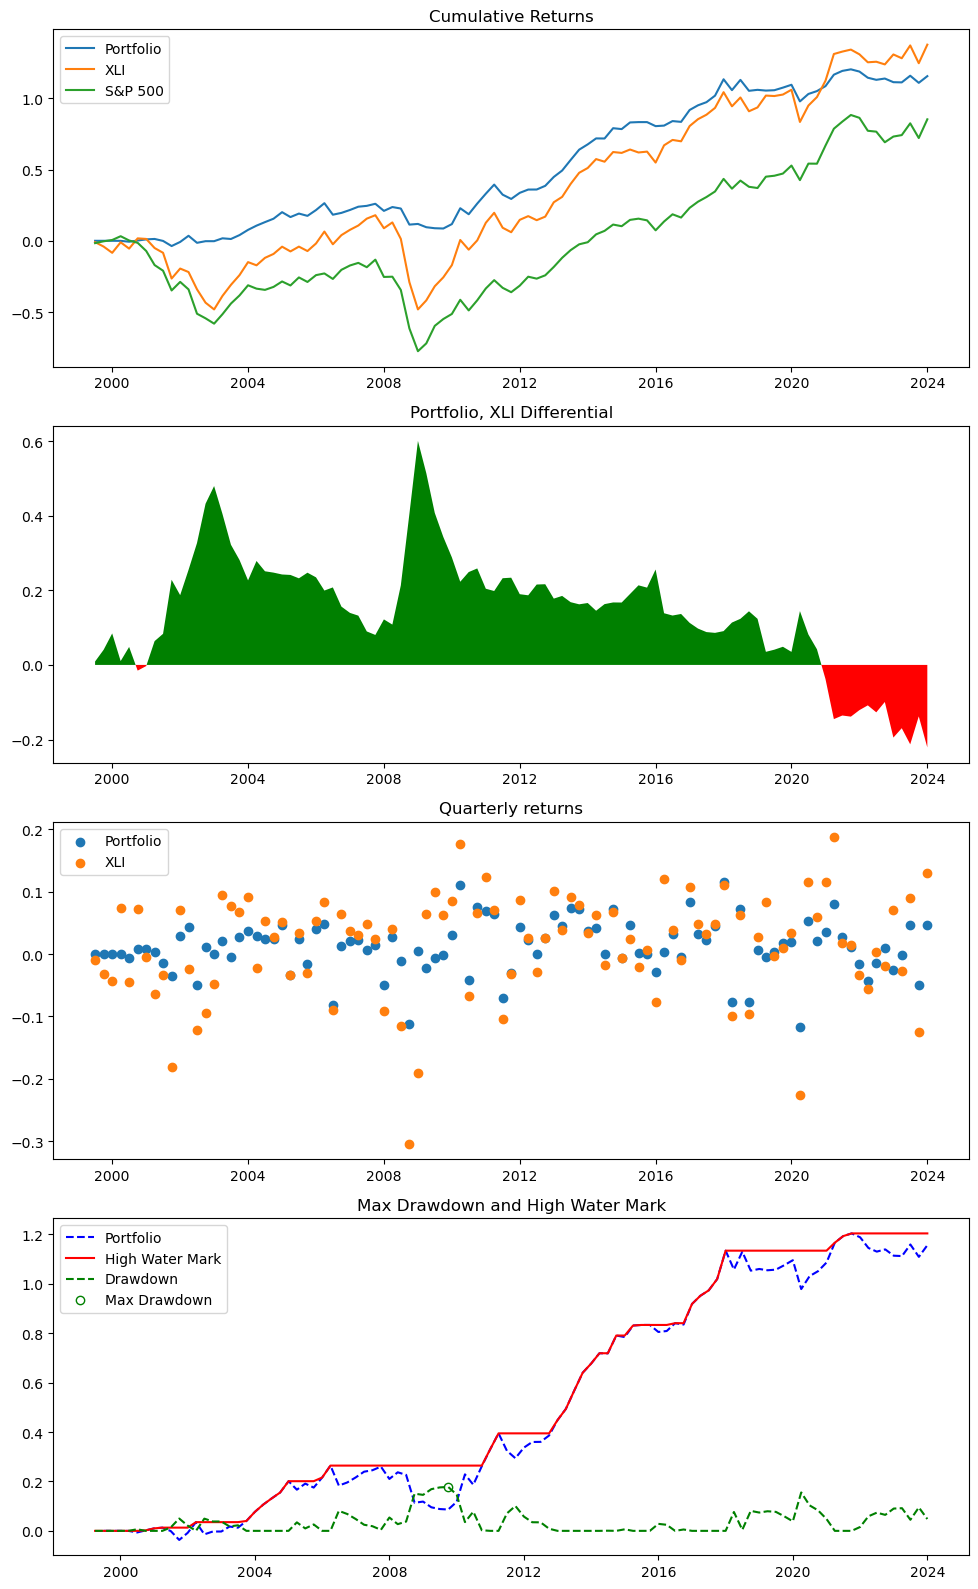

In [222]:
ret_df3 =  calc_return(df3combo, log_returns_3)
metrics_3combo, HWMs_3, mdd_track_3  = calc_metrics(ret_df3)
res = graph(ret_df3, bench_ret, HWMs_3, mdd_track_3)
vol_plot_4 = ret_df3
plt.show()

In [223]:
metrics_3combo

CAT        GE       UNP       RTX       HON  \
Annualized Return     0.040450  0.061039  0.096232  0.004906  0.034308   
Annualized Vol        0.198695  0.158650  0.265942  0.243341  0.144446   
Sharpe Ratio          0.203579  0.384741  0.361852  0.020162  0.237511   
Skewness              0.248745  1.111875 -1.255589 -1.587399 -0.129981   
Excess Kurtosis       1.307962  3.871773  6.365355  6.031030  1.552645   
High Water Mark       1.001140  1.525978  2.690628  1.806645  1.593084   
Max Drawdown          0.554573  0.274057  0.969190  1.683989  0.735395   
XLI Beta              0.508866  0.316967  0.944562  0.603851  0.435683   
Annualized XLI Alpha  0.012131  0.044016  0.044638 -0.028649  0.010408   
S&P Beta              0.530761  0.340470  1.112359  0.497035  0.416901   
Annualized S&P Alpha  0.022154  0.049919  0.058858 -0.012178  0.020283   

                             BA       ETN       UPS        DE       ADP  ...  \
Annualized Return      0.090604  0.088698 -0.003918  0.086965  0.035769  ...   
Annualized Vol         0.246623  0.185338  0.258490  0.282842  0.167074  ...   
Sharpe Ratio           0.367379  0.478573 -0.015156  0.307469  0.214093  ...   
Skewness               3.402970 -0.036551  0.322660 -0.934021 -0.095328  ...   
Excess Kurtosis       22.931839  0.741911  4.369172  4.330854  4.591418  ...   
High Water Mark        2.265110  2.217448  0.395020  2.445002  1.492586  ...   
Max Drawdown           0.425564  0.372987  0.804503  0.705901  0.598352  ...   
XLI Beta               0.064291  0.607783  0.122011  0.951462  0.213324  ...   
Annualized XLI Alpha   0.087942  0.055770 -0.010747  0.034894  0.024259  ...   
S&P Beta               0.164095  0.635788 -0.010819  1.002366  0.259423  ...   
Annualized S&P Alpha   0.085863  0.067677 -0.003584  0.053290  0.027188  ...   

                           ALLE       ITT       HII       AOS        AAL  \
Annualized Return     -0.008970  0.018720  0.066296  0.106562  -0.009386   
Annualized Vol         0.302133  0.266834  0.196133  0.193725   0.088911   
Sharpe Ratio          -0.029689  0.070156  0.338017  0.550070  -0.105560   
Skewness               3.976036 -0.793214 -0.088644  0.542442  -0.996560   
Excess Kurtosis       37.245507  6.218598  5.765148  3.673658  15.636849   
High Water Mark        1.585464  1.276236  2.241259  2.986329   0.329234   
Max Drawdown           1.809715  1.394856  0.592182  0.478914   0.563872   
XLI Beta               0.189277  0.832802  0.318105  0.387549   0.050407   
Annualized XLI Alpha  -0.019594 -0.027437  0.049263  0.086071  -0.012286   
S&P Beta               0.234092  0.985760  0.221223  0.436673   0.033091   
Annualized S&P Alpha  -0.017130 -0.015072  0.059340  0.092586  -0.010621   

                           PAYC      CHRW       RHI       GNRC  Portfolio  
Annualized Return      0.017514  0.014904  0.033274   0.094887   0.046249  
Annualized Vol         0.064063  0.162707  0.152441   0.248777   0.084181  
Sharpe Ratio           0.273380  0.091600  0.218273   0.381413   0.549396  
Skewness               3.225400  0.350497  0.028726   3.295561  -0.457629  
Excess Kurtosis       21.852753  2.202142  4.774518  13.352688   0.910164  
High Water Mark        0.437839  0.551397  1.175655   2.554604   1.204112  
Max Drawdown           0.160176  0.364585  0.518550   0.350466   0.177876  
XLI Beta               0.035436 -0.001201  0.093255   0.024910   0.401533  
Annualized XLI Alpha   0.015718  0.015121  0.028420   0.094459   0.024370  
S&P Beta               0.055861  0.048535  0.082905  -0.071034   0.434795  
Annualized S&P Alpha   0.015765  0.013381  0.030752   0.098294   0.031728  

[11 rows x 78 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


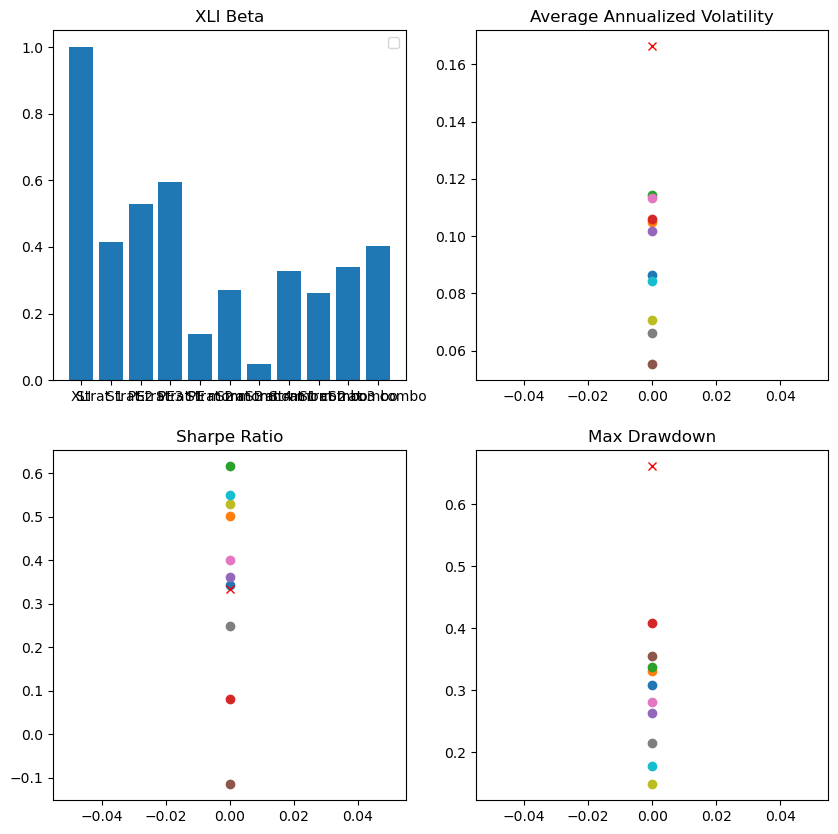

In [224]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))

labels = ['XLI','Strat 1 PE','Strat 2 PE','Strat 3 PE','Strat 1 mom','Strat 2 mom','Strat 3 mom','Strat 4 mom','Strat 1 combo','Strat 2 combo','Strat 3 combo']
data= [metrics_bench[0].iloc[7],metrics_1PE['Portfolio'].iloc[7],metrics_2PE['Portfolio'].iloc[7],
       metrics_3PE['Portfolio'].iloc[7],metrics_1mom['Portfolio'].iloc[7], metrics_2mom['Portfolio'].iloc[7],
      metrics_3mom['Portfolio'].iloc[7],metrics_4mom['Portfolio'].iloc[7],metrics_1combo['Portfolio'].iloc[7],
      metrics_2combo['Portfolio'].iloc[7],metrics_3combo['Portfolio'].iloc[7]]

ax1.bar(labels,data)
'''
ax1.plot(0, metrics_bench[0].iloc[7], 'rx', label ='XLI')
ax1.bar(1, metrics_1PE['Portfolio'].iloc[7], label ='Strat 1 PE')
ax1.bar(2, metrics_2PE['Portfolio'].iloc[7], label ='Strat 2 PE')
ax1.scatter(3, metrics_3PE['Portfolio'].iloc[7], label ='Strat 3 PE')
ax1.scatter(4, metrics_1mom['Portfolio'].iloc[7], label ='Strat 1 mom')
ax1.scatter(5, metrics_2mom['Portfolio'].iloc[7], label ='Strat 2 mom')
ax1.scatter(6, metrics_3mom['Portfolio'].iloc[7], label ='Strat 3 mom')
ax1.scatter(7, metrics_4mom['Portfolio'].iloc[7], label ='Strat 4 mom')
ax1.scatter(8, metrics_1combo['Portfolio'].iloc[7], label ='Strat 1 combo')
ax1.scatter(9, metrics_2combo['Portfolio'].iloc[7], label ='Strat 2 combo')
ax1.scatter(10, metrics_3combo['Portfolio'].iloc[7], label ='Strat 3 combo')  
'''
ax1.set_title("XLI Beta")
ax1.legend()
    

ax2.plot(0, metrics_bench[0].iloc[1],'rx', label ='XLI')
ax2.scatter(0, metrics_1PE['Portfolio'].iloc[1], label ='Strat 1 PE')
ax2.scatter(0, metrics_2PE['Portfolio'].iloc[1], label ='Strat 2 PE')
ax2.scatter(0, metrics_3PE['Portfolio'].iloc[1], label ='Strat 3 PE')
ax2.scatter(0, metrics_1mom['Portfolio'].iloc[1], label ='Strat 1 mom')
ax2.scatter(0, metrics_2mom['Portfolio'].iloc[1], label ='Strat 2 mom')
ax2.scatter(0, metrics_3mom['Portfolio'].iloc[1], label ='Strat 3 mom')
ax2.scatter(0, metrics_4mom['Portfolio'].iloc[1], label ='Strat 4 mom')
ax2.scatter(0, metrics_1combo['Portfolio'].iloc[1], label ='Strat 1 combo')
ax2.scatter(0, metrics_2combo['Portfolio'].iloc[1], label ='Strat 2 combo')
ax2.scatter(0, metrics_3combo['Portfolio'].iloc[1], label ='Strat 3 combo')  
ax2.set_title("Average Annualized Volatility")
   

ax3.plot(0, metrics_bench[0].iloc[2],'rx', label ='XLI')
ax3.scatter(0, metrics_1PE['Portfolio'].iloc[2], label ='Strat 1 PE')
ax3.scatter(0, metrics_2PE['Portfolio'].iloc[2], label ='Strat 2 PE')
ax3.scatter(0, metrics_3PE['Portfolio'].iloc[2], label ='Strat 3 PE')
ax3.scatter(0, metrics_1mom['Portfolio'].iloc[2], label ='Strat 1 mom')
ax3.scatter(0, metrics_2mom['Portfolio'].iloc[2], label ='Strat 2 mom')
ax3.scatter(0, metrics_3mom['Portfolio'].iloc[2], label ='Strat 3 mom')
ax3.scatter(0, metrics_4mom['Portfolio'].iloc[2], label ='Strat 4 mom')
ax3.scatter(0, metrics_1combo['Portfolio'].iloc[2], label ='Strat 1 combo')
ax3.scatter(0, metrics_2combo['Portfolio'].iloc[2], label ='Strat 2 combo')
ax3.scatter(0, metrics_3combo['Portfolio'].iloc[2], label ='Strat 3 combo')  
ax3.set_title("Sharpe Ratio")
  

ax4.plot(0, metrics_bench[0].iloc[6],'rx', label ='XLI')
ax4.scatter(0, metrics_1PE['Portfolio'].iloc[6], label ='Strat 1 PE')
ax4.scatter(0, metrics_2PE['Portfolio'].iloc[6], label ='Strat 2 PE')
ax4.scatter(0, metrics_3PE['Portfolio'].iloc[6], label ='Strat 3 PE')
ax4.scatter(0, metrics_1mom['Portfolio'].iloc[6], label ='Strat 1 mom')
ax4.scatter(0, metrics_2mom['Portfolio'].iloc[6], label ='Strat 2 mom')
ax4.scatter(0, metrics_3mom['Portfolio'].iloc[6], label ='Strat 3 mom')
ax4.scatter(0, metrics_4mom['Portfolio'].iloc[6], label ='Strat 4 mom')
ax4.scatter(0, metrics_1combo['Portfolio'].iloc[6], label ='Strat 1 combo')
ax4.scatter(0, metrics_2combo['Portfolio'].iloc[6], label ='Strat 2 combo')
ax4.scatter(0, metrics_3combo['Portfolio'].iloc[6], label ='Strat 3 combo')  
ax4.set_title("Max Drawdown")
 

#fig.tight_layout()
plt.show()

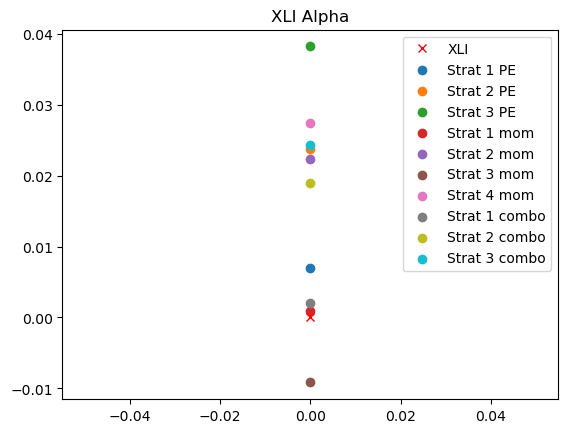

In [225]:
fig, ((ax5)) = plt.subplots(1)
ax5.plot(0, metrics_bench[0].iloc[8], 'rx', label ='XLI')
ax5.scatter(0, metrics_1PE['Portfolio'].iloc[8], label ='Strat 1 PE')
ax5.scatter(0, metrics_2PE['Portfolio'].iloc[8], label ='Strat 2 PE')
ax5.scatter(0, metrics_3PE['Portfolio'].iloc[8], label ='Strat 3 PE')
ax5.scatter(0, metrics_1mom['Portfolio'].iloc[8], label ='Strat 1 mom')
ax5.scatter(0, metrics_2mom['Portfolio'].iloc[8], label ='Strat 2 mom')
ax5.scatter(0, metrics_3mom['Portfolio'].iloc[8], label ='Strat 3 mom')
ax5.scatter(0, metrics_4mom['Portfolio'].iloc[8], label ='Strat 4 mom')
ax5.scatter(0, metrics_1combo['Portfolio'].iloc[8], label ='Strat 1 combo')
ax5.scatter(0, metrics_2combo['Portfolio'].iloc[8], label ='Strat 2 combo')
ax5.scatter(0, metrics_3combo['Portfolio'].iloc[8], label ='Strat 3 combo')  
ax5.set_title("XLI Alpha")
ax5.legend()
plt.show()

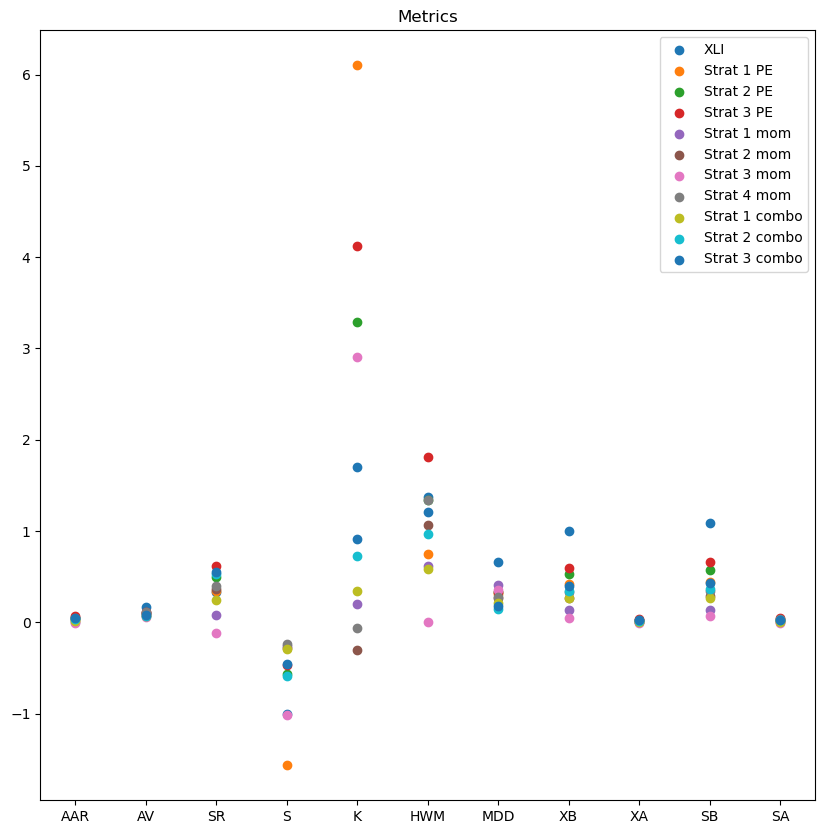

In [226]:
fig, ((ax1)) = plt.subplots(1,figsize = (10,10))

x = ['AAR','AV', 'SR','S','K','HWM', 'MDD','XB','XA','SB','SA']
ax1.scatter(x, metrics_bench[0], label ='XLI')
ax1.scatter(x, metrics_1PE['Portfolio'], label ='Strat 1 PE')
ax1.scatter(x, metrics_2PE['Portfolio'], label ='Strat 2 PE')
ax1.scatter(x, metrics_3PE['Portfolio'], label ='Strat 3 PE')
ax1.scatter(x, metrics_1mom['Portfolio'], label ='Strat 1 mom')
ax1.scatter(x, metrics_2mom['Portfolio'], label ='Strat 2 mom')
ax1.scatter(x, metrics_3mom['Portfolio'], label ='Strat 3 mom')
ax1.scatter(x, metrics_4mom['Portfolio'], label ='Strat 4 mom')
ax1.scatter(x, metrics_1combo['Portfolio'], label ='Strat 1 combo')
ax1.scatter(x, metrics_2combo['Portfolio'], label ='Strat 2 combo')
ax1.scatter(x, metrics_3combo['Portfolio'], label ='Strat 3 combo')  
ax1.set_title("Metrics")
ax1.legend()

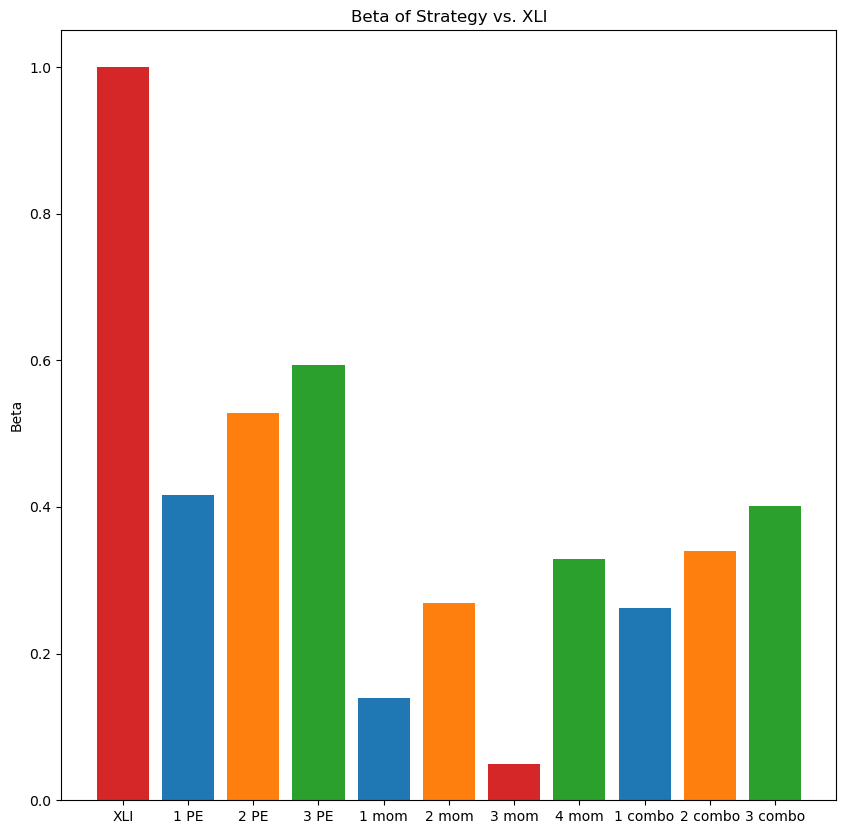

In [227]:
labels = ['XLI','1 PE','2 PE','3 PE','1 mom','2 mom','3 mom','4 mom','1 combo','2 combo','3 combo']
data= [metrics_bench[0].iloc[7],metrics_1PE['Portfolio'].iloc[7],metrics_2PE['Portfolio'].iloc[7],
       metrics_3PE['Portfolio'].iloc[7],metrics_1mom['Portfolio'].iloc[7], metrics_2mom['Portfolio'].iloc[7],
      metrics_3mom['Portfolio'].iloc[7],metrics_4mom['Portfolio'].iloc[7],metrics_1combo['Portfolio'].iloc[7],
      metrics_2combo['Portfolio'].iloc[7],metrics_3combo['Portfolio'].iloc[7]]

bar_colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:blue', 'tab:orange','tab:red', 'tab:green',
             'tab:blue', 'tab:orange', 'tab:green']
fig, ((ax1)) = plt.subplots(1,figsize = (10,10))
ax1.bar(labels,data, color=bar_colors)
ax1.set_ylabel('Beta')
ax1.set_title('Beta of Strategy vs. XLI')
plt.show()

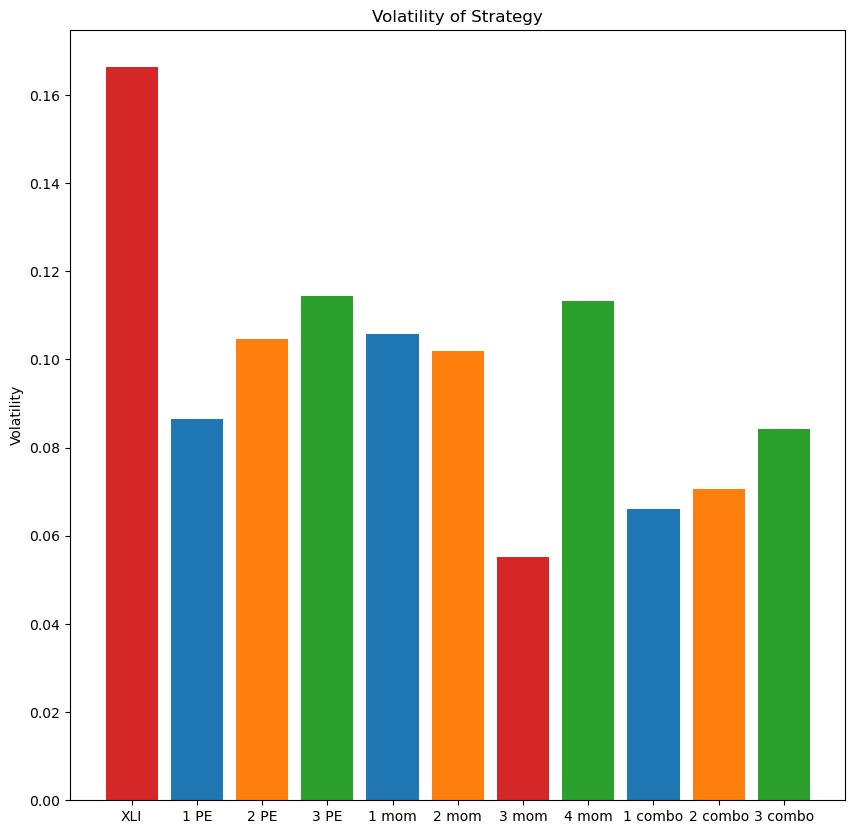

In [228]:
labels = ['XLI','1 PE','2 PE','3 PE','1 mom','2 mom','3 mom','4 mom','1 combo','2 combo','3 combo']
data= [metrics_bench[0].iloc[1],metrics_1PE['Portfolio'].iloc[1],metrics_2PE['Portfolio'].iloc[1],
       metrics_3PE['Portfolio'].iloc[1],metrics_1mom['Portfolio'].iloc[1], metrics_2mom['Portfolio'].iloc[1],
      metrics_3mom['Portfolio'].iloc[1],metrics_4mom['Portfolio'].iloc[1],metrics_1combo['Portfolio'].iloc[1],
      metrics_2combo['Portfolio'].iloc[1],metrics_3combo['Portfolio'].iloc[1]]

bar_colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:blue', 'tab:orange','tab:red', 'tab:green',
             'tab:blue', 'tab:orange', 'tab:green']
fig, ((ax1)) = plt.subplots(1,figsize = (10,10))
ax1.bar(labels,data, color=bar_colors)
ax1.set_ylabel('Volatility')
ax1.set_title('Volatility of Strategy')
plt.show()

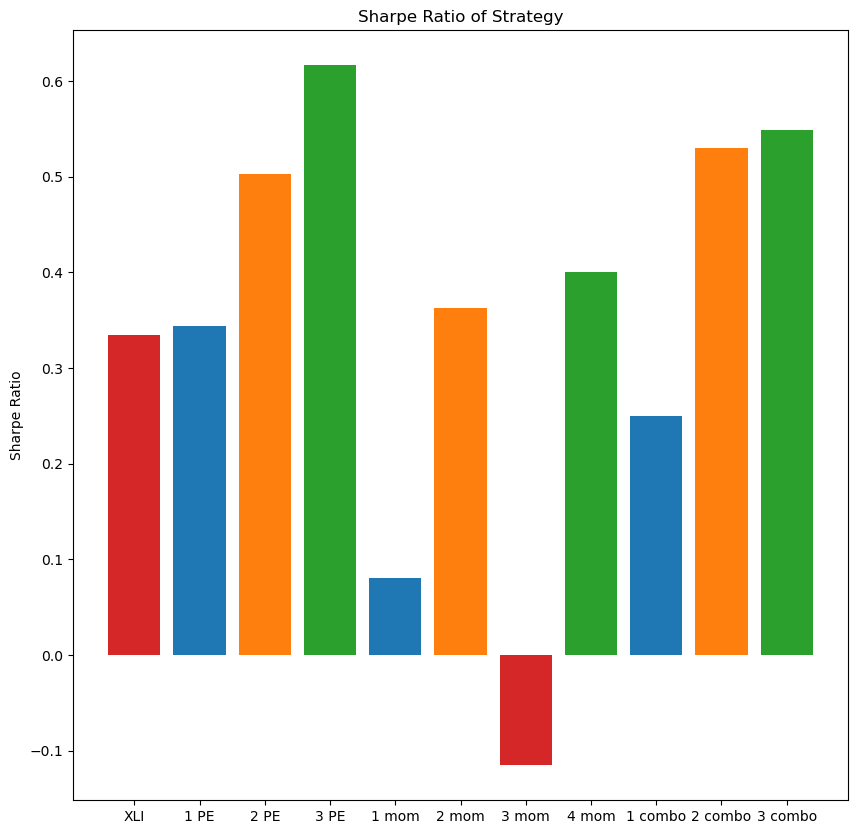

In [229]:
labels = ['XLI','1 PE','2 PE','3 PE','1 mom','2 mom','3 mom','4 mom','1 combo','2 combo','3 combo']
data= [metrics_bench[0].iloc[2],metrics_1PE['Portfolio'].iloc[2],metrics_2PE['Portfolio'].iloc[2],
       metrics_3PE['Portfolio'].iloc[2],metrics_1mom['Portfolio'].iloc[2], metrics_2mom['Portfolio'].iloc[2],
      metrics_3mom['Portfolio'].iloc[2],metrics_4mom['Portfolio'].iloc[2],metrics_1combo['Portfolio'].iloc[2],
      metrics_2combo['Portfolio'].iloc[2],metrics_3combo['Portfolio'].iloc[2]]

bar_colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:blue', 'tab:orange','tab:red', 'tab:green',
             'tab:blue', 'tab:orange', 'tab:green']
fig, ((ax1)) = plt.subplots(1,figsize = (10,10))
ax1.bar(labels,data, color=bar_colors)
ax1.set_ylabel('Sharpe Ratio')
ax1.set_title('Sharpe Ratio of Strategy')
plt.show()

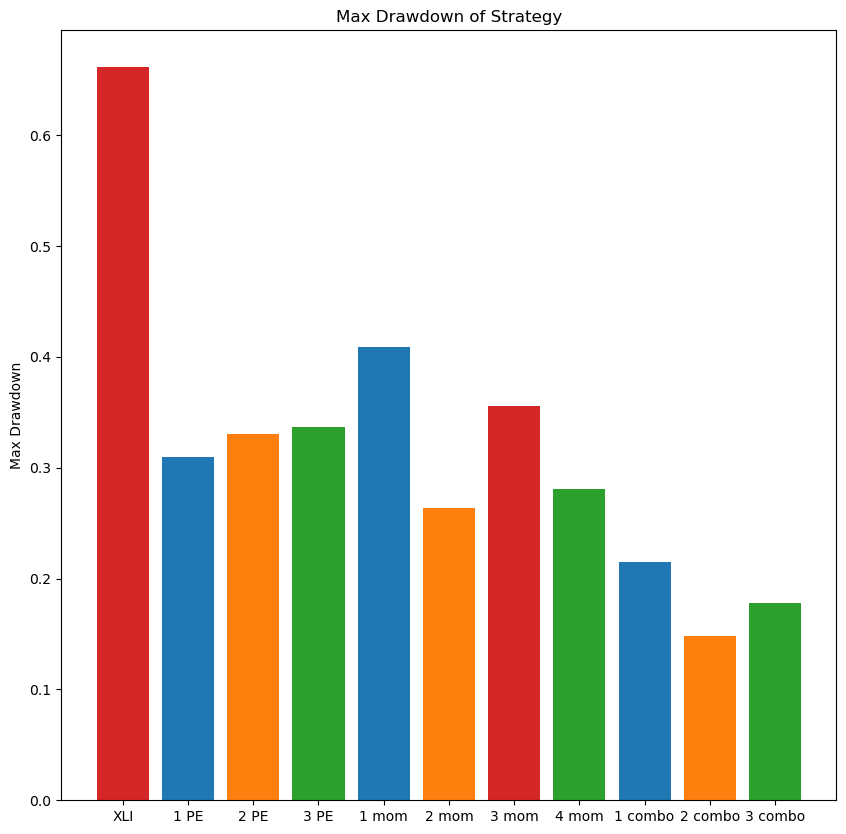

In [230]:
labels = ['XLI','1 PE','2 PE','3 PE','1 mom','2 mom','3 mom','4 mom','1 combo','2 combo','3 combo']
data= [metrics_bench[0].iloc[6],metrics_1PE['Portfolio'].iloc[6],metrics_2PE['Portfolio'].iloc[6],
       metrics_3PE['Portfolio'].iloc[6],metrics_1mom['Portfolio'].iloc[6], metrics_2mom['Portfolio'].iloc[6],
      metrics_3mom['Portfolio'].iloc[6],metrics_4mom['Portfolio'].iloc[6],metrics_1combo['Portfolio'].iloc[6],
      metrics_2combo['Portfolio'].iloc[6],metrics_3combo['Portfolio'].iloc[6]]

bar_colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:blue', 'tab:orange','tab:red', 'tab:green',
             'tab:blue', 'tab:orange', 'tab:green']
fig, ((ax1)) = plt.subplots(1,figsize = (10,10))
ax1.bar(labels,data, color=bar_colors)
ax1.set_ylabel('Max Drawdown')
ax1.set_title('Max Drawdown of Strategy')
plt.show()

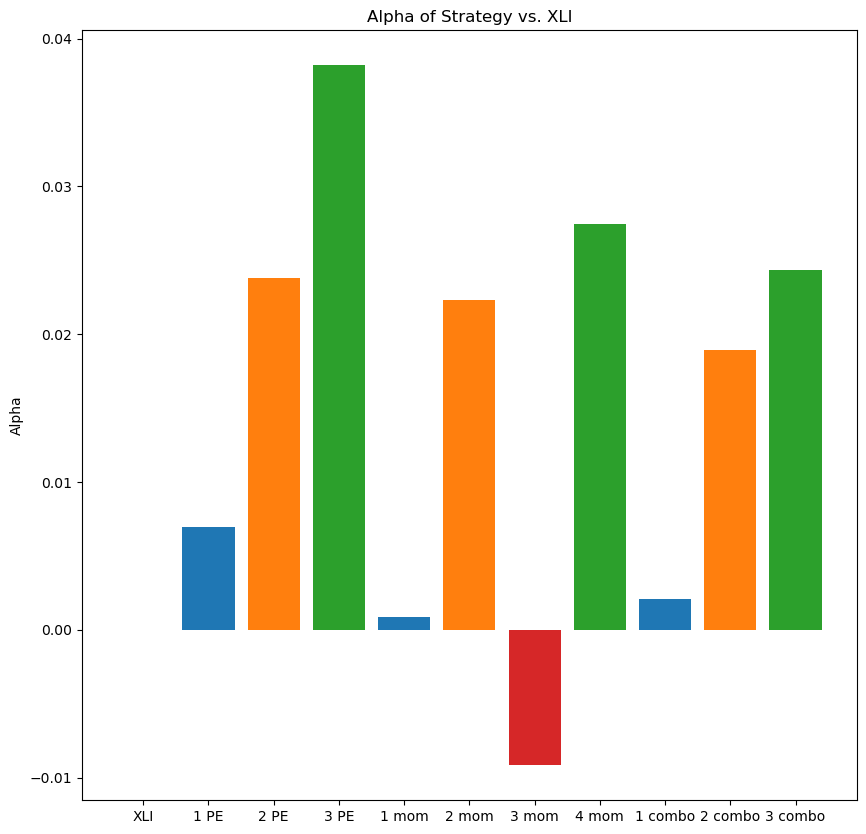

In [231]:
labels = ['XLI','1 PE','2 PE','3 PE','1 mom','2 mom','3 mom','4 mom','1 combo','2 combo','3 combo']
data= [metrics_bench[0].iloc[8],metrics_1PE['Portfolio'].iloc[8],metrics_2PE['Portfolio'].iloc[8],
       metrics_3PE['Portfolio'].iloc[8],metrics_1mom['Portfolio'].iloc[8], metrics_2mom['Portfolio'].iloc[8],
      metrics_3mom['Portfolio'].iloc[8],metrics_4mom['Portfolio'].iloc[8],metrics_1combo['Portfolio'].iloc[8],
      metrics_2combo['Portfolio'].iloc[8],metrics_3combo['Portfolio'].iloc[8]]

bar_colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:blue', 'tab:orange','tab:red', 'tab:green',
             'tab:blue', 'tab:orange', 'tab:green']
fig, ((ax1)) = plt.subplots(1,figsize = (10,10))
ax1.bar(labels,data, color=bar_colors)
ax1.set_ylabel('Alpha')
ax1.set_title('Alpha of Strategy vs. XLI')
plt.show()

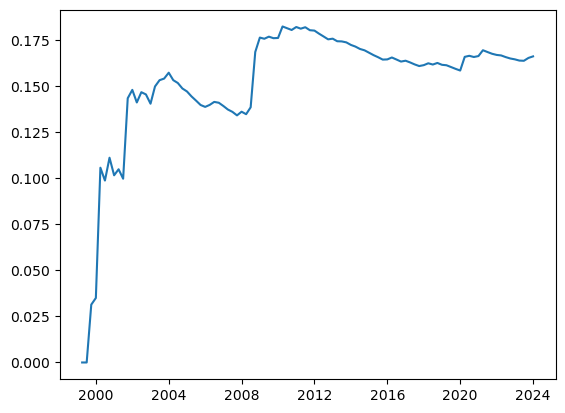

In [232]:
plt.plot(bench_vol)

In [245]:
vol_pe3 = pd.DataFrame(index = log_returns_3.index, columns = ['Portfolio'])
for j in range(len(log_returns_3)):
        vol_pe3.iloc[j] = vol_plot['Portfolio'].iloc[:j+1].std()*np.sqrt(4)
vol_pe3 = vol_pe3.fillna(0)
vol_pe3

Portfolio
Date                 
1999-04-01   0.000000
1999-07-01   0.000000
1999-10-01   0.001414
2000-01-01   0.023894
2000-04-01   0.023407
...               ...
2023-01-01   0.116683
2023-04-01   0.116275
2023-07-01   0.115863
2023-10-01   0.115511
2024-01-01   0.114924

[100 rows x 1 columns]

In [246]:
vol_mom1 = vol_plot_1['Portfolio'].std()
vol_mom1 = pd.DataFrame(index = log_returns_3.index, columns = ['Portfolio'])
for j in range(len(log_returns_3)):
        vol_mom1.iloc[j] = vol_plot_1['Portfolio'].iloc[:j+1].std()*np.sqrt(4)
vol_mom1 = vol_mom1.fillna(0)
vol_mom1

Portfolio
Date                 
1999-04-01   0.000000
1999-07-01   0.000000
1999-10-01   0.029417
2000-01-01   0.048092
2000-04-01   0.060562
...               ...
2023-01-01   0.101336
2023-04-01   0.100943
2023-07-01   0.100880
2023-10-01   0.103620
2024-01-01   0.106360

[100 rows x 1 columns]

In [247]:
vol_mom2 = vol_plot_2['Portfolio'].std()
vol_mom2 = pd.DataFrame(index = log_returns_3.index, columns = ['Portfolio'])
for j in range(len(log_returns_3)):
        vol_mom2.iloc[j] = vol_plot_2['Portfolio'].iloc[:j+1].std()*np.sqrt(4)
vol_mom2 = vol_mom2.fillna(0)
vol_mom2

Portfolio
Date                 
1999-04-01   0.000000
1999-07-01   0.000000
1999-10-01   0.000000
2000-01-01   0.000000
2000-04-01   0.000982
...               ...
2023-01-01   0.101901
2023-04-01   0.101368
2023-07-01   0.101046
2023-10-01   0.102247
2024-01-01   0.102344

[100 rows x 1 columns]

In [248]:
vol_combo3 = vol_plot_4['Portfolio'].std()
vol_combo3 = pd.DataFrame(index = log_returns_3.index, columns = ['Portfolio'])
for j in range(len(log_returns_3)):
        vol_combo3.iloc[j] = vol_plot_4['Portfolio'].iloc[:j+1].std()*np.sqrt(4)
vol_combo3 = vol_combo3.fillna(0)
vol_combo3

Portfolio
Date                 
1999-04-01   0.000000
1999-07-01   0.000000
1999-10-01   0.000000
2000-01-01   0.000000
2000-04-01   0.000298
...               ...
2023-01-01   0.084752
2023-04-01   0.084347
2023-07-01   0.084211
2023-10-01   0.084705
2024-01-01   0.084577

[100 rows x 1 columns]

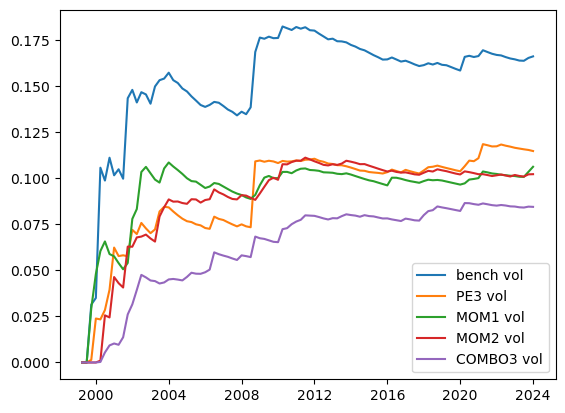

In [240]:
bench_vol_1y = pd.Series(index = bench_ret.index)
for j in range(3, len(log_returns_3)):
        bench_vol_1y.iloc[j] = bench_ret.iloc[j-3:j+1].std()*np.sqrt(4)
bench_vol_1y

Date
1999-04-01         NaN
1999-07-01         NaN
1999-10-01         NaN
2000-01-01    0.035053
2000-04-01    0.105866
                ...   
2023-01-01    0.105614
2023-04-01    0.087519
2023-07-01    0.119726
2023-10-01    0.197515
2024-01-01    0.231477
Freq: 3MS, Length: 100, dtype: float64

In [190]:
bench_ret.iloc[0:4]

Date
1999-04-01         NaN
1999-07-01   -0.009187
1999-10-01   -0.031422
2000-01-01   -0.043773
Freq: 3MS, dtype: float64

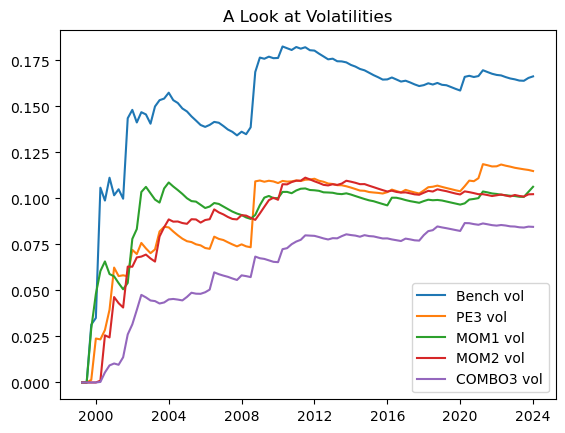

In [252]:
plt.plot(vol_combo3.index, bench_vol, label ='Bench vol')
plt.plot(vol_combo3.index,vol_pe3, label ='PE3 vol')
plt.plot(vol_combo3.index,vol_mom1, label ='MOM1 vol')
plt.plot(vol_combo3.index,vol_mom2, label ='MOM2 vol')
plt.plot(vol_combo3.index,vol_combo3, label ='COMBO3 vol')
#plt.plot(vol_combo3.index, bench_vol_1y, label ='1y historical vol')
plt.legend()
plt.title('A Look at Volatilities')
plt.show()

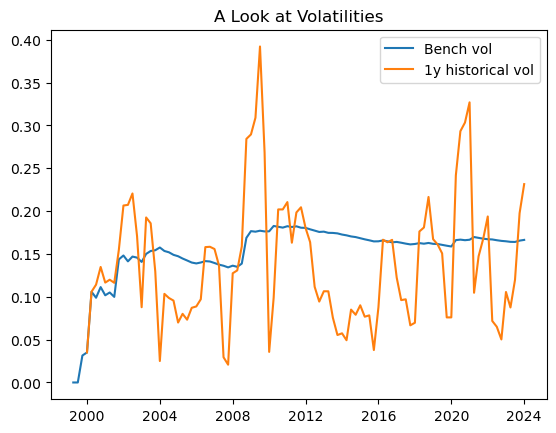

In [253]:
plt.plot(vol_combo3.index, bench_vol, label ='Bench vol')
plt.plot(vol_combo3.index, bench_vol_1y, label ='1y historical vol')
plt.legend()
plt.title('A Look at Volatilities')
plt.show()